In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from pathlib import Path
from results import *
from evaluate import *

plt.style.use("ggplot")
FIGSIZE = (13, 8)
DPI = 300
POINT_SIZE = 60
CMAP = plt.rcParams["axes.prop_cycle"].by_key()["color"]
lw = 0
alpha = 0.75

Load the result json files into a custom class that gives easy access to evaluation metrics.

In [82]:
results = [Result.from_json(p) for p in Path("../analysis/").rglob("*evaluation/results.json")]

Turn results into a dataframe for plotting

In [83]:
results_dicts = [r.as_dict() for r in results]
results_df = pd.DataFrame(results_dicts)

In [84]:
results_df

denovo_precision  denovo_recall  overall_recall  overall_precision  \
0                 0.0            0.0           0.248           0.659574   
1                 0.0            0.0           0.183           0.564815   
2                 0.0            0.0           0.240           0.650407   
3                 0.0            0.0           0.519           0.856436   
4                 0.0            0.0           0.430           0.814394   
..                ...            ...             ...                ...   
283               0.0            0.0           0.880           0.977778   
284               0.0            0.0           0.900           0.978261   
285               0.0            0.0           0.900           0.978261   
286               0.0            0.0           0.880           0.977778   
287               0.0            0.0           0.900           0.978261   

     overall_accuracy  overall_error_rate  denovo_kmer_size  num_snps  \
0            0.219858            0.780142                13      1000   
1            0.160386            0.839614                15      1000   
2            0.212578            0.787422                11      1000   
3            0.477461            0.522539                13      1000   
4            0.391621            0.608379                15      1000   
..                ...                 ...               ...       ...   
283          0.862745            0.137255                15       100   
284          0.882353            0.117647                11       100   
285          0.882353            0.117647                13       100   
286          0.862745            0.137255                15       100   
287          0.882353            0.117647                11       100   

     coverage  max_nesting read_quality  conf_threshold  
0          15            5    imperfect               0  
1          15            5    imperfect               0  
2          15            5    imperfect               0  
3          30            5    imperfect               0  
4          30            5    imperfect               0  
..        ...          ...          ...             ...  
283        60            3      perfect               0  
284        60            3      perfect               0  
285       100            3      perfect               0  
286       100            3      perfect               0  
287       100            3      perfect               0  

[288 rows x 12 columns]

# Metric definitions
The first thing we need to do is define some terminology that will be used for this analysis.

## True Positive (TP)
### Correct variant allele or position call
This is defined as an entry in `pandora`'s VCF which, when taken with flanking sequence, maps over a variant position in the reference panel and has the **correct** base call at the expected position. *Note:* Mismatches are allowed in the flanks.

## False Positive (FP)
### Incorrect variant allele or position call
This is defined as an entry in `pandora`'s VCF which, when taken with flanking sequence, maps over a variant position in the reference panel and has the **incorrect** base call at the expected position. *Note:* Mismatches are allowed in the flanks.

## False Negative (FN)
### Incorrect reference genotype or no call
This is defined as an entry in the reference panel which does not have any variants from `pandora`'s VCF that map across its variant position.  
*Note:* a `pandora` variant call can map to an entry in the reference panel but may not map across the middle position (which is the variant position).

## True Negative (TN)
### Correct reference genotype or no call
This is basically any position we have left the same as the reference correctly. True negatives would only really be relevant if we decided to apply the variant calls from `pandora` onto the consensus sequence from `pandora` and do a base-by-base comparison of that to the reference sequence.  
We will not consider TNs for the remainder of this analysis.

## Accuracy
### Ratio of correct calls to total calls and variants
**Calculation:** TP+~~TN~~/TP+FP+~~TN~~+FN  


## Specificity
### Non-variants not called as variants relative to the total non-variants
**Calculation:** TN/TN+FP

Not being used in this analysis due to the reliance on TNs.

## Sensitivity / Recall
### True variants called relative to all variants
**Calculation:** TP/TP+FN  


## Precision 
### True variants called relative to total calls 
**Calculation:** TP/TP+FP  


## False positive rate
### Non-variants called relative to the total non-variants
**Calculation:** FP/TN+FP  

Not being used in this analysis due to the reliance on TNs.

# Analysis
This analysis is looking at the results from running the simulations on 100 genes with varying parameters. The aim is decide on which parameter defaults should be used for running the simulations on a much larger sample of genes.  

To begin with, let's plot the precision (y) and recall (x) but focusing purely on the candidate paths produced by *de novo* discovery. In this context, recall is defined as the percentage of simulated mutations where the mutant allele was included amongst the *de novo* slices. Precision is thus defined as the percentage of *de novo* slices that include a variant from the reference panel.  
For the plotting, we will colour (hue) the plot by the read quality. That is, were the simulated reads perfect (no errors) or imperfect (error profile from ONT R9 *E. coli* data).

Next, lets look at a precision recall plot again, but this time using the entries in the VCF produced by `pandora`.

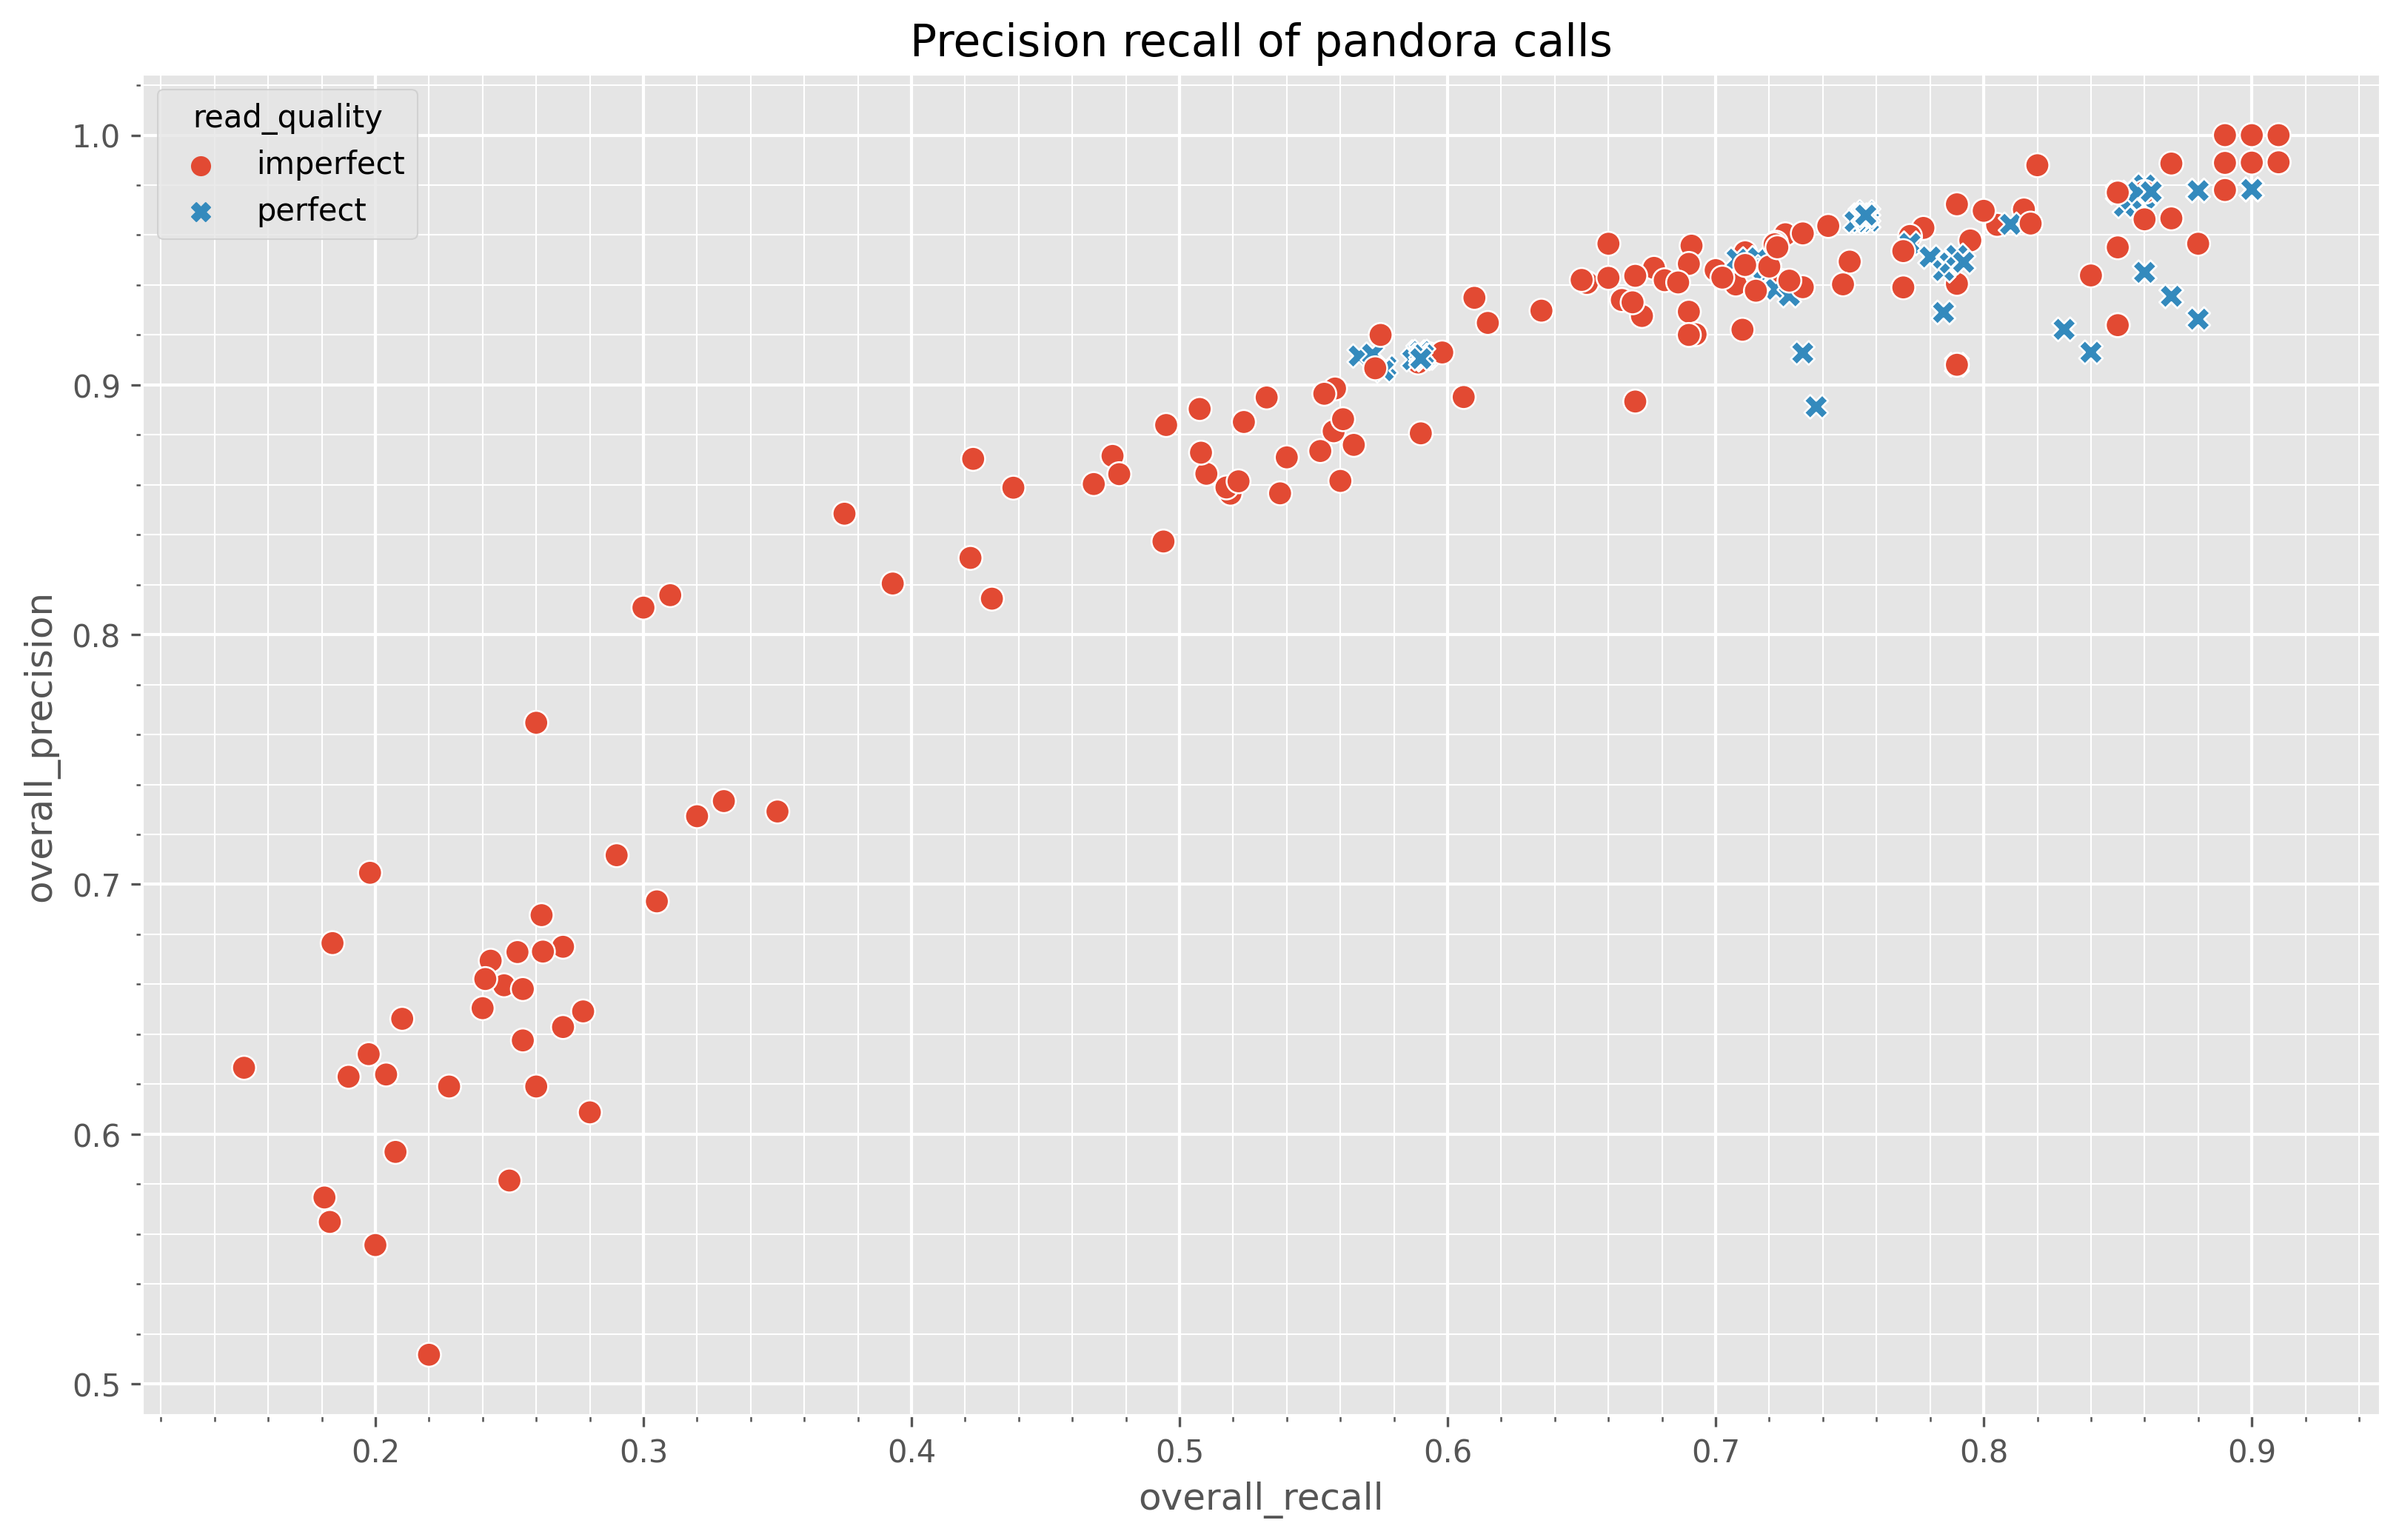

In [97]:
x = "overall_recall"
y = "overall_precision"
hue = "read_quality"
data = results_df
pal = CMAP[:len(set(data[hue]))]

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
plot = sns.scatterplot(x=x, 
                       y=y, 
                       data=data, 
                       ax=ax, 
                       style=hue,
                       palette=pal, 
                       hue=hue, 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

In [98]:
data.groupby([hue])[[x, y]].describe().T

read_quality              imperfect     perfect
overall_recall    count  144.000000  144.000000
                  mean     0.572861    0.797392
                  std      0.224376    0.095230
                  min      0.151000    0.567000
                  25%      0.368750    0.755750
                  50%      0.612500    0.801250
                  75%      0.732500    0.880000
                  max      0.910000    0.900000
overall_precision count  144.000000  144.000000
                  mean     0.859710    0.957324
                  std      0.127200    0.024289
                  min      0.511628    0.891239
                  25%      0.815441    0.946088
                  50%      0.916489    0.967969
                  75%      0.948682    0.977778
                  max      1.000000    0.980057

From both of these plots it is fairly clear that read quality makes a very big difference to the precision-recall relationship. As such, we can partition the data into perfect and imperfect sets to dig in to more detail about how the other parameters effect this relationship.

In [99]:
imperfect_df = results_df.query("read_quality == 'imperfect'")
perfect_df = results_df.query("read_quality == 'perfect'")

## Effect of coverage
Let's first take a look at how coverage effects the precision-recall relationship.

These two plots show an interesting difference. For the perfect reads, there does not seem to be a requirement for any particular level of coverage, suggesting that for perfect reads, other parameters likely explain the variation. But for the imperfect reads it is very obvious that as you increase coverage, the number of variants you are able to discover increases also.  

From this we can also say that, in the best case, for imperfect reads with 100x coverage we are able to correctly discover ~77% of variants and that ~95% of the *de novo* slices contain a variant.  
For perfect reads, we can also say that, in the best case, we are able to correctly discover about 84% of variants and that ~98% of the *de novo* slices contain a variant. Additionally, coverage doesn't seem to play too big a role in this relationship, although it should be noted that, oddly, 60x coverage doesn't have as good results as the other coverage levels.  

*Note:* For these plot, precision actually goes above 1.0. The reason for this is that in some cases we find multiple variants in the one *de novo* slice.

And now looking at the same thing from the VCF output of `pandora`

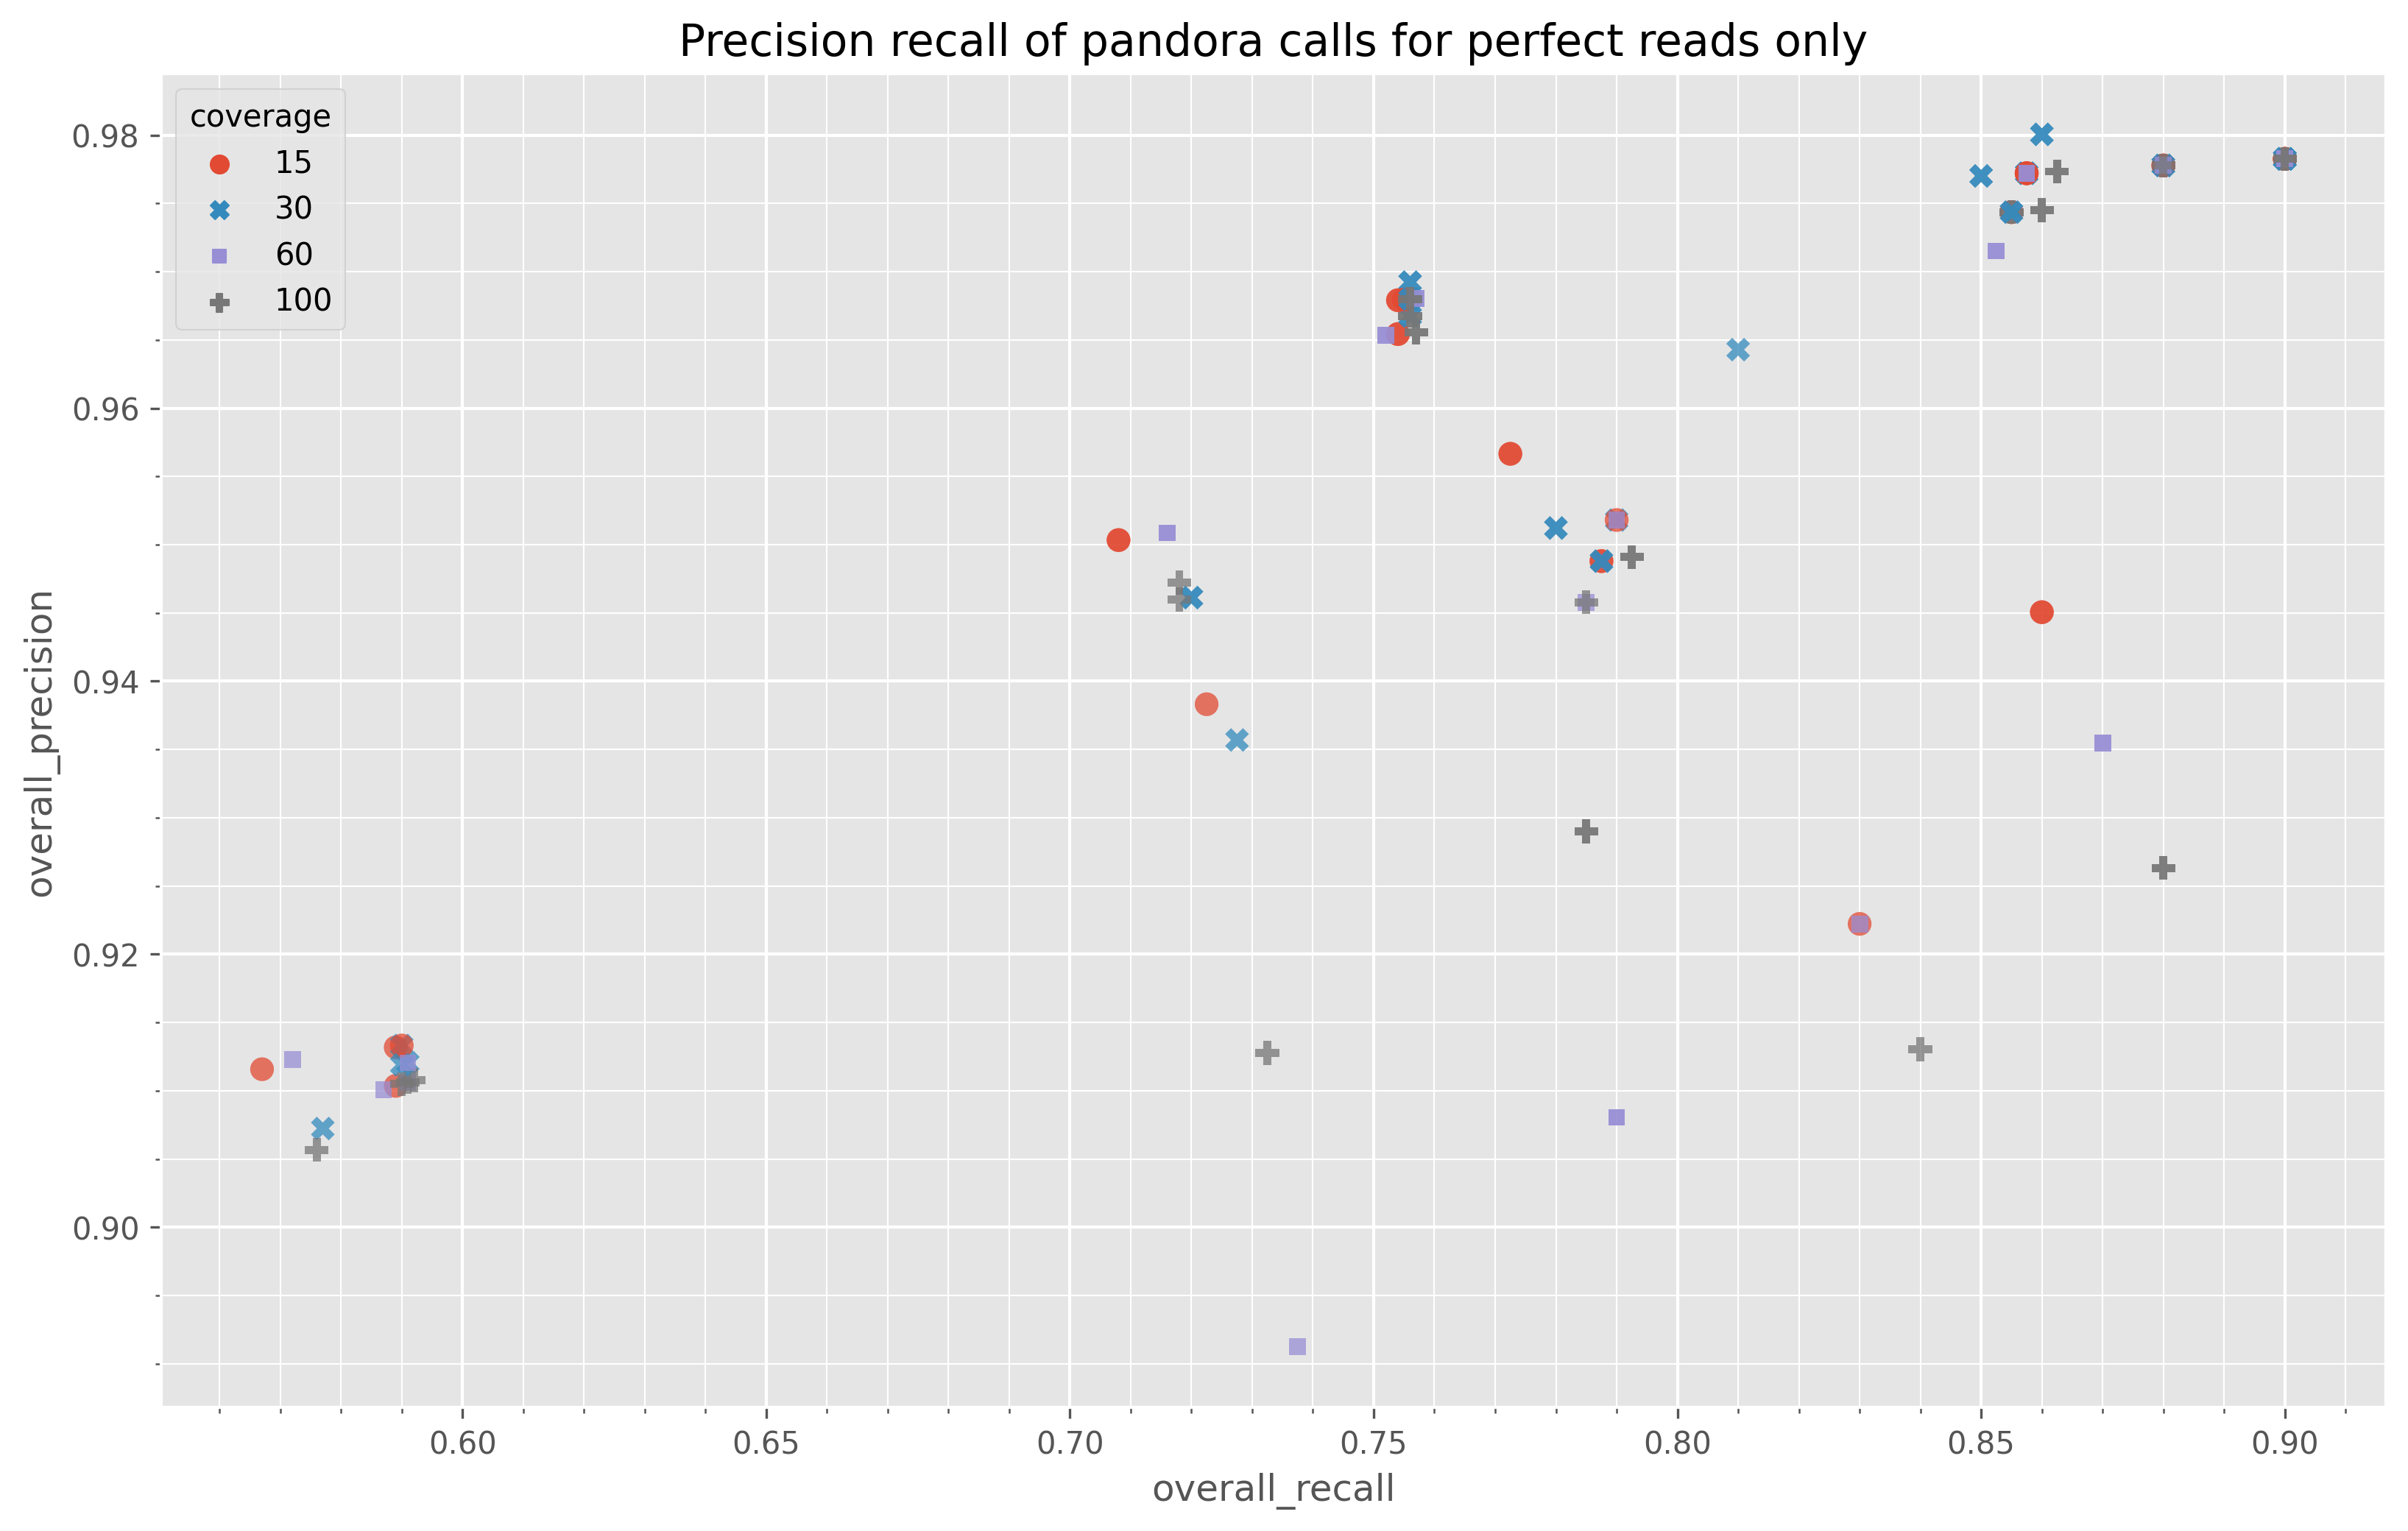

In [100]:
x="overall_recall"
y="overall_precision"
hue="coverage"
data = perfect_df
pal = CMAP[:len(set(data[hue]))]

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
plot = sns.scatterplot(x=x, 
                       y=y, 
                       data=data, 
                       ax=ax, 
                       style=hue,
                       palette=pal, 
                       hue=hue, 
                       legend="full", 
                       linewidth=lw,
                       alpha=alpha,
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

In [101]:
data.groupby([hue])[[x, y]].describe().T

coverage                       15         30         60         100
overall_recall    count  36.000000  36.000000  36.000000  36.000000
                  mean    0.795542   0.796431   0.797861   0.799736
                  std     0.097198   0.095049   0.096140   0.096528
                  min     0.567000   0.577000   0.572000   0.576000
                  25%     0.754000   0.756000   0.755000   0.756000
                  50%     0.810000   0.800000   0.810000   0.816250
                  75%     0.865000   0.865000   0.872500   0.880000
                  max     0.900000   0.900000   0.900000   0.900000
overall_precision count  36.000000  36.000000  36.000000  36.000000
                  mean    0.959041   0.961574   0.954040   0.954641
                  std     0.021958   0.021832   0.027296   0.025813
                  min     0.910355   0.907233   0.891239   0.905660
                  25%     0.948795   0.950613   0.935484   0.928994
                  50%     0.967908   0.969231   0.967990   0.966752
                  75%     0.977350   0.977778   0.977350   0.977447
                  max     0.978261   0.980057   0.978261   0.978261

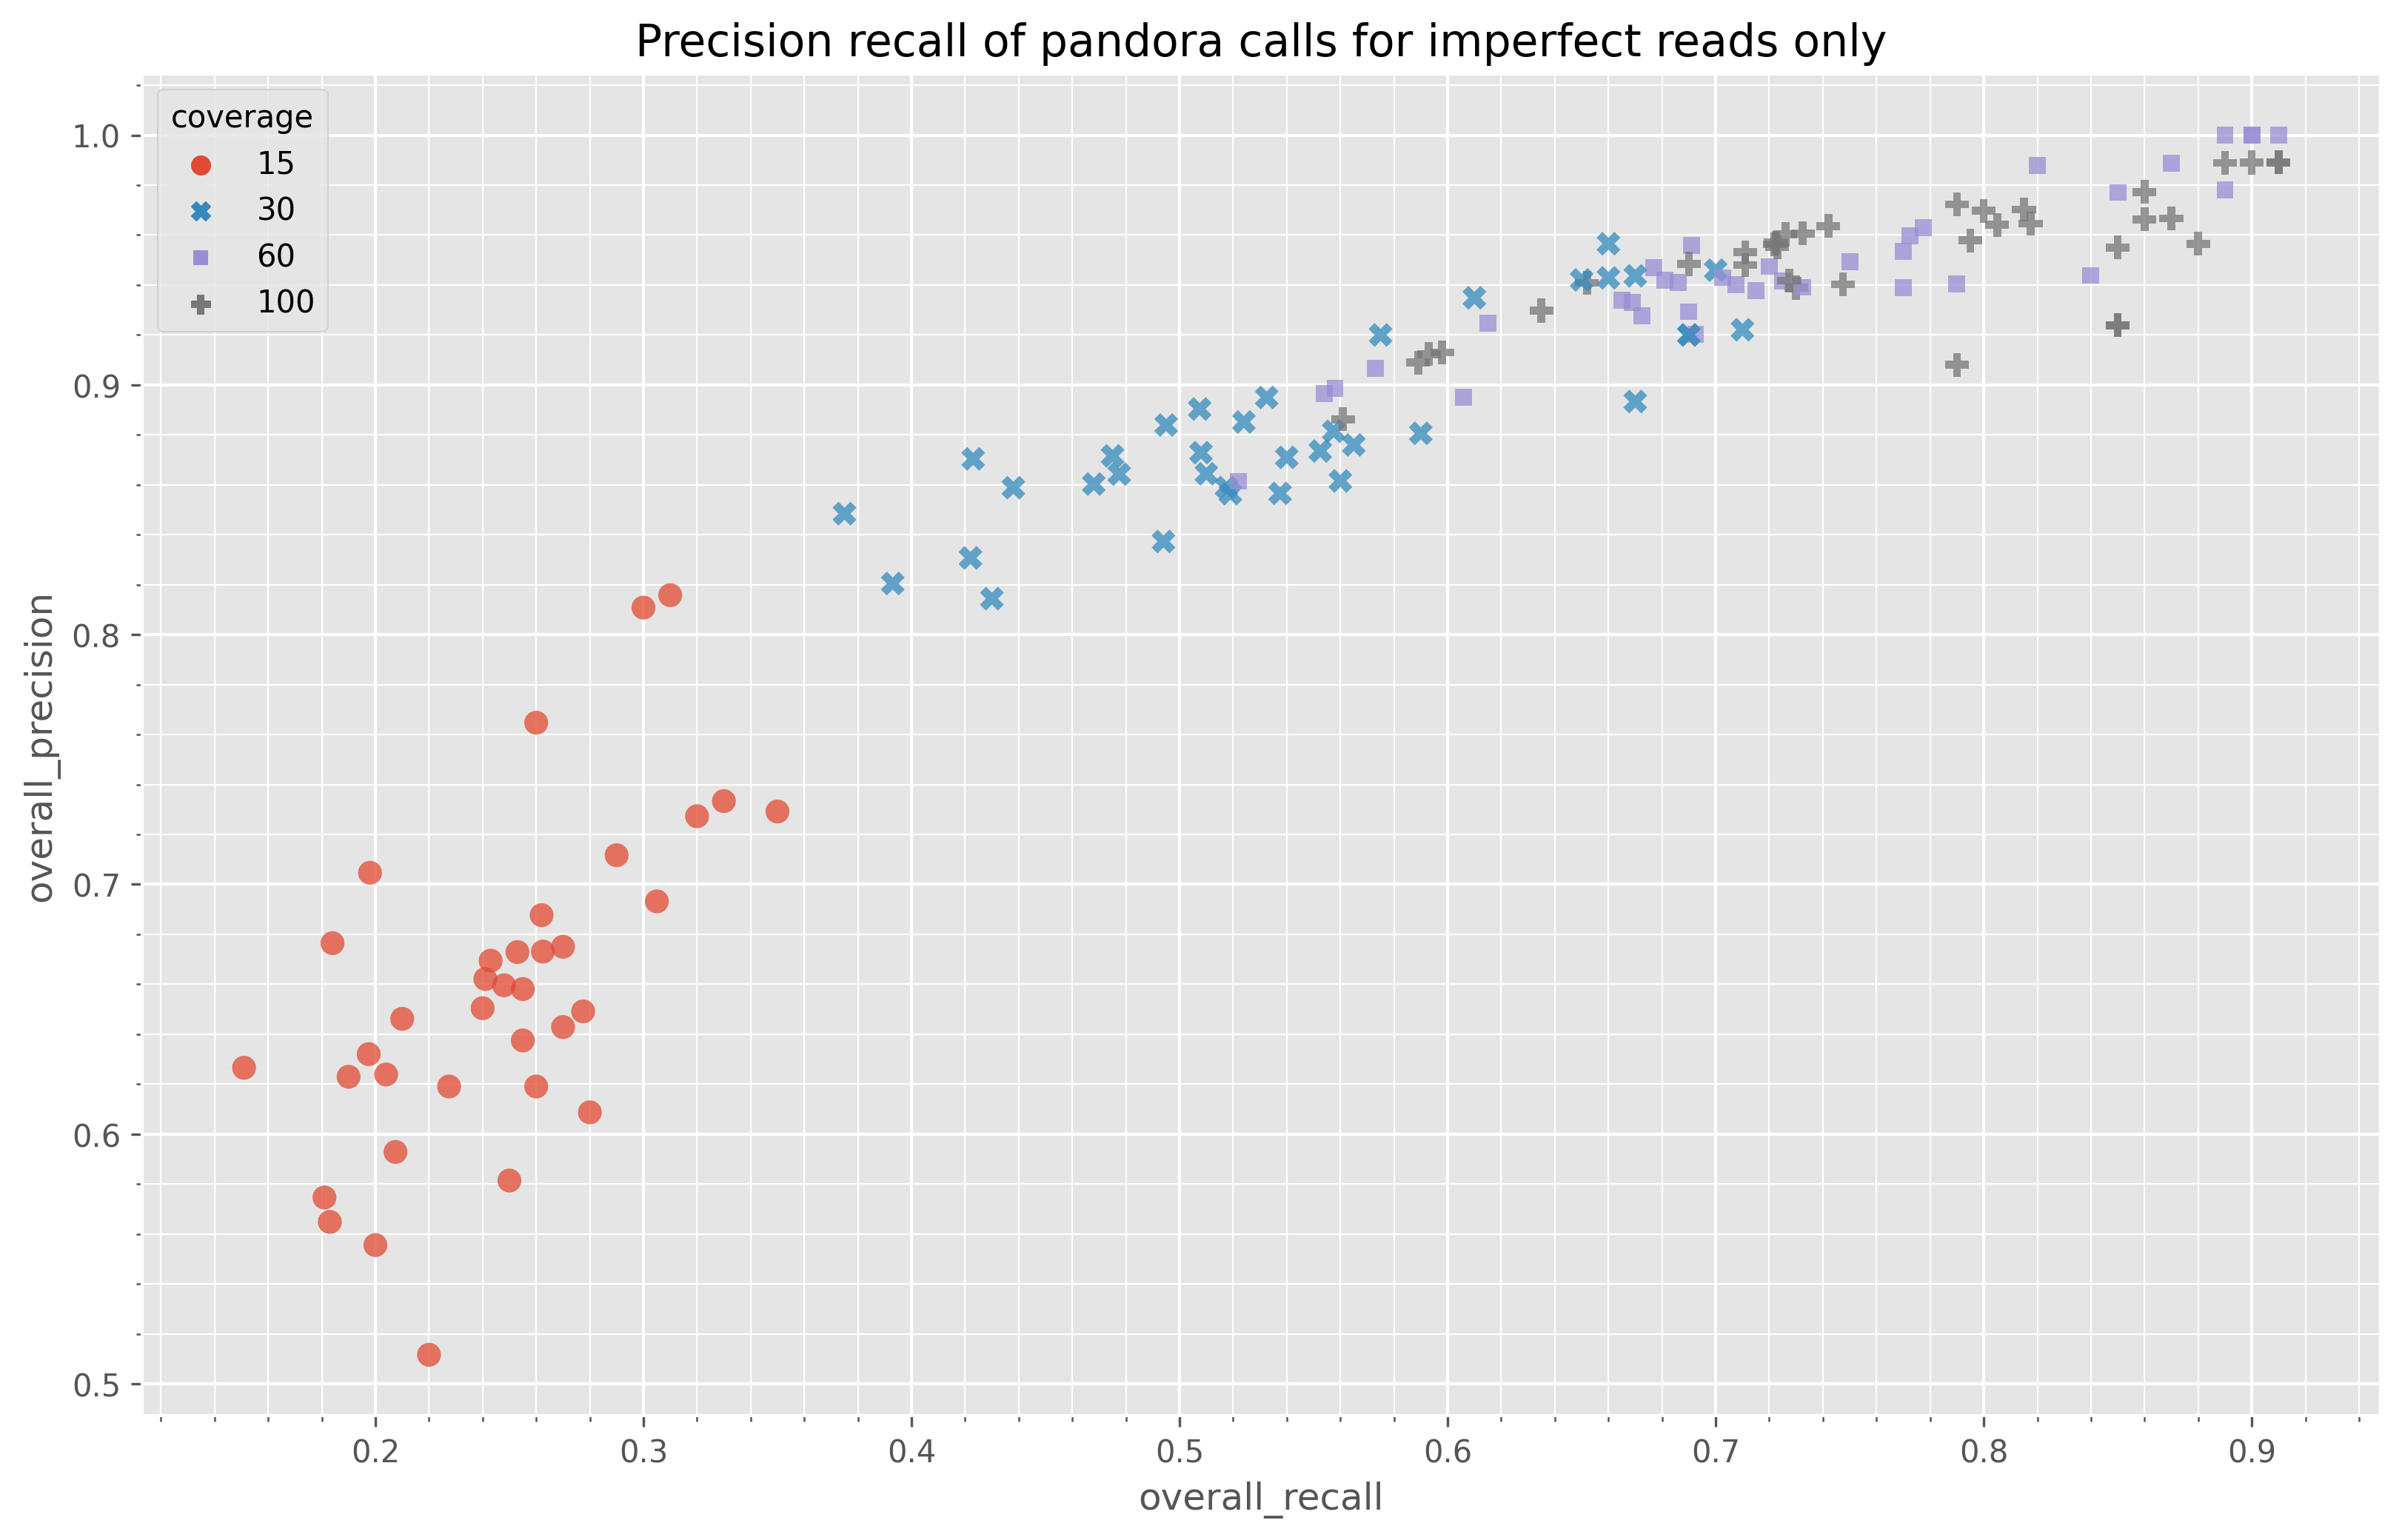

In [102]:
data = imperfect_df
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
plot = sns.scatterplot(x=x, 
                       y=y, 
                       data=data, 
                       ax=ax, 
                       style=hue,
                       palette=pal, 
                       hue=hue, 
                       legend="full", 
                       linewidth=lw,
                       alpha=alpha,
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

In [103]:
data.groupby([hue])[[x, y]].describe().T

coverage                       15         30         60         100
overall_recall    count  36.000000  36.000000  36.000000  36.000000
                  mean    0.246819   0.547125   0.732069   0.765431
                  std     0.046845   0.093065   0.105333   0.097505
                  min     0.151000   0.375000   0.522000   0.561000
                  25%     0.206625   0.489875   0.675875   0.719250
                  50%     0.251500   0.535000   0.717500   0.768750
                  75%     0.271875   0.620000   0.797500   0.850000
                  max     0.350000   0.710000   0.910000   0.910000
overall_precision count  36.000000  36.000000  36.000000  36.000000
                  mean    0.657884   0.884040   0.945608   0.951306
                  std     0.065834   0.037139   0.032164   0.025149
                  min     0.511628   0.814394   0.861386   0.886256
                  25%     0.621975   0.859951   0.932114   0.939915
                  50%     0.654236   0.874743   0.941734   0.956407
                  75%     0.689043   0.920000   0.960433   0.966386
                  max     0.815789   0.956522   1.000000   0.989130

For the `pandora` calls we see a very similar relationship as before: coverage doesn't effect the precision-recall relationship for perfect reads, but absolutelty does for imperfect reads.  

From this we can also say that, in the best case, for imperfect reads with $\geq$60x coverage ~90% of calls are correct (precision) and ~90% of the variants were, correctly, called (recall).
For perfect reads, we can also say that, in the best case, ~91% of calls are correct (precision) and ~92% of the variants were, correctly, called (recall). Additionally, coverage doesn't seem to play too big a role in this relationship, although it should be noted that, oddly, 60x coverage doesn't have as good results as the other coverage levels.

## Effect of maximum nesting level
When building the PRG one of the setting which can altered is the maximum level of nesting allowed in your graph. Here we assess how this parameter impacts the precision-recall relationship.

When looking at the candidate paths produced by *de novo* the maximum PRG nesting level doesn't appear to have a dramatic effect on the precision recall relationship.  
One thing that is consistent for imperfect reads is probably that a maximum nesting level of 3 seems to produce worse results and for perfect reads a level of 10 produces the worst results.  

In summary, the discover of variants doesn't seem to depend too much on the maximum nesting level, although a value of 5 might be slightly beneficial.

And now looking at the same thing from the VCF output of `pandora`

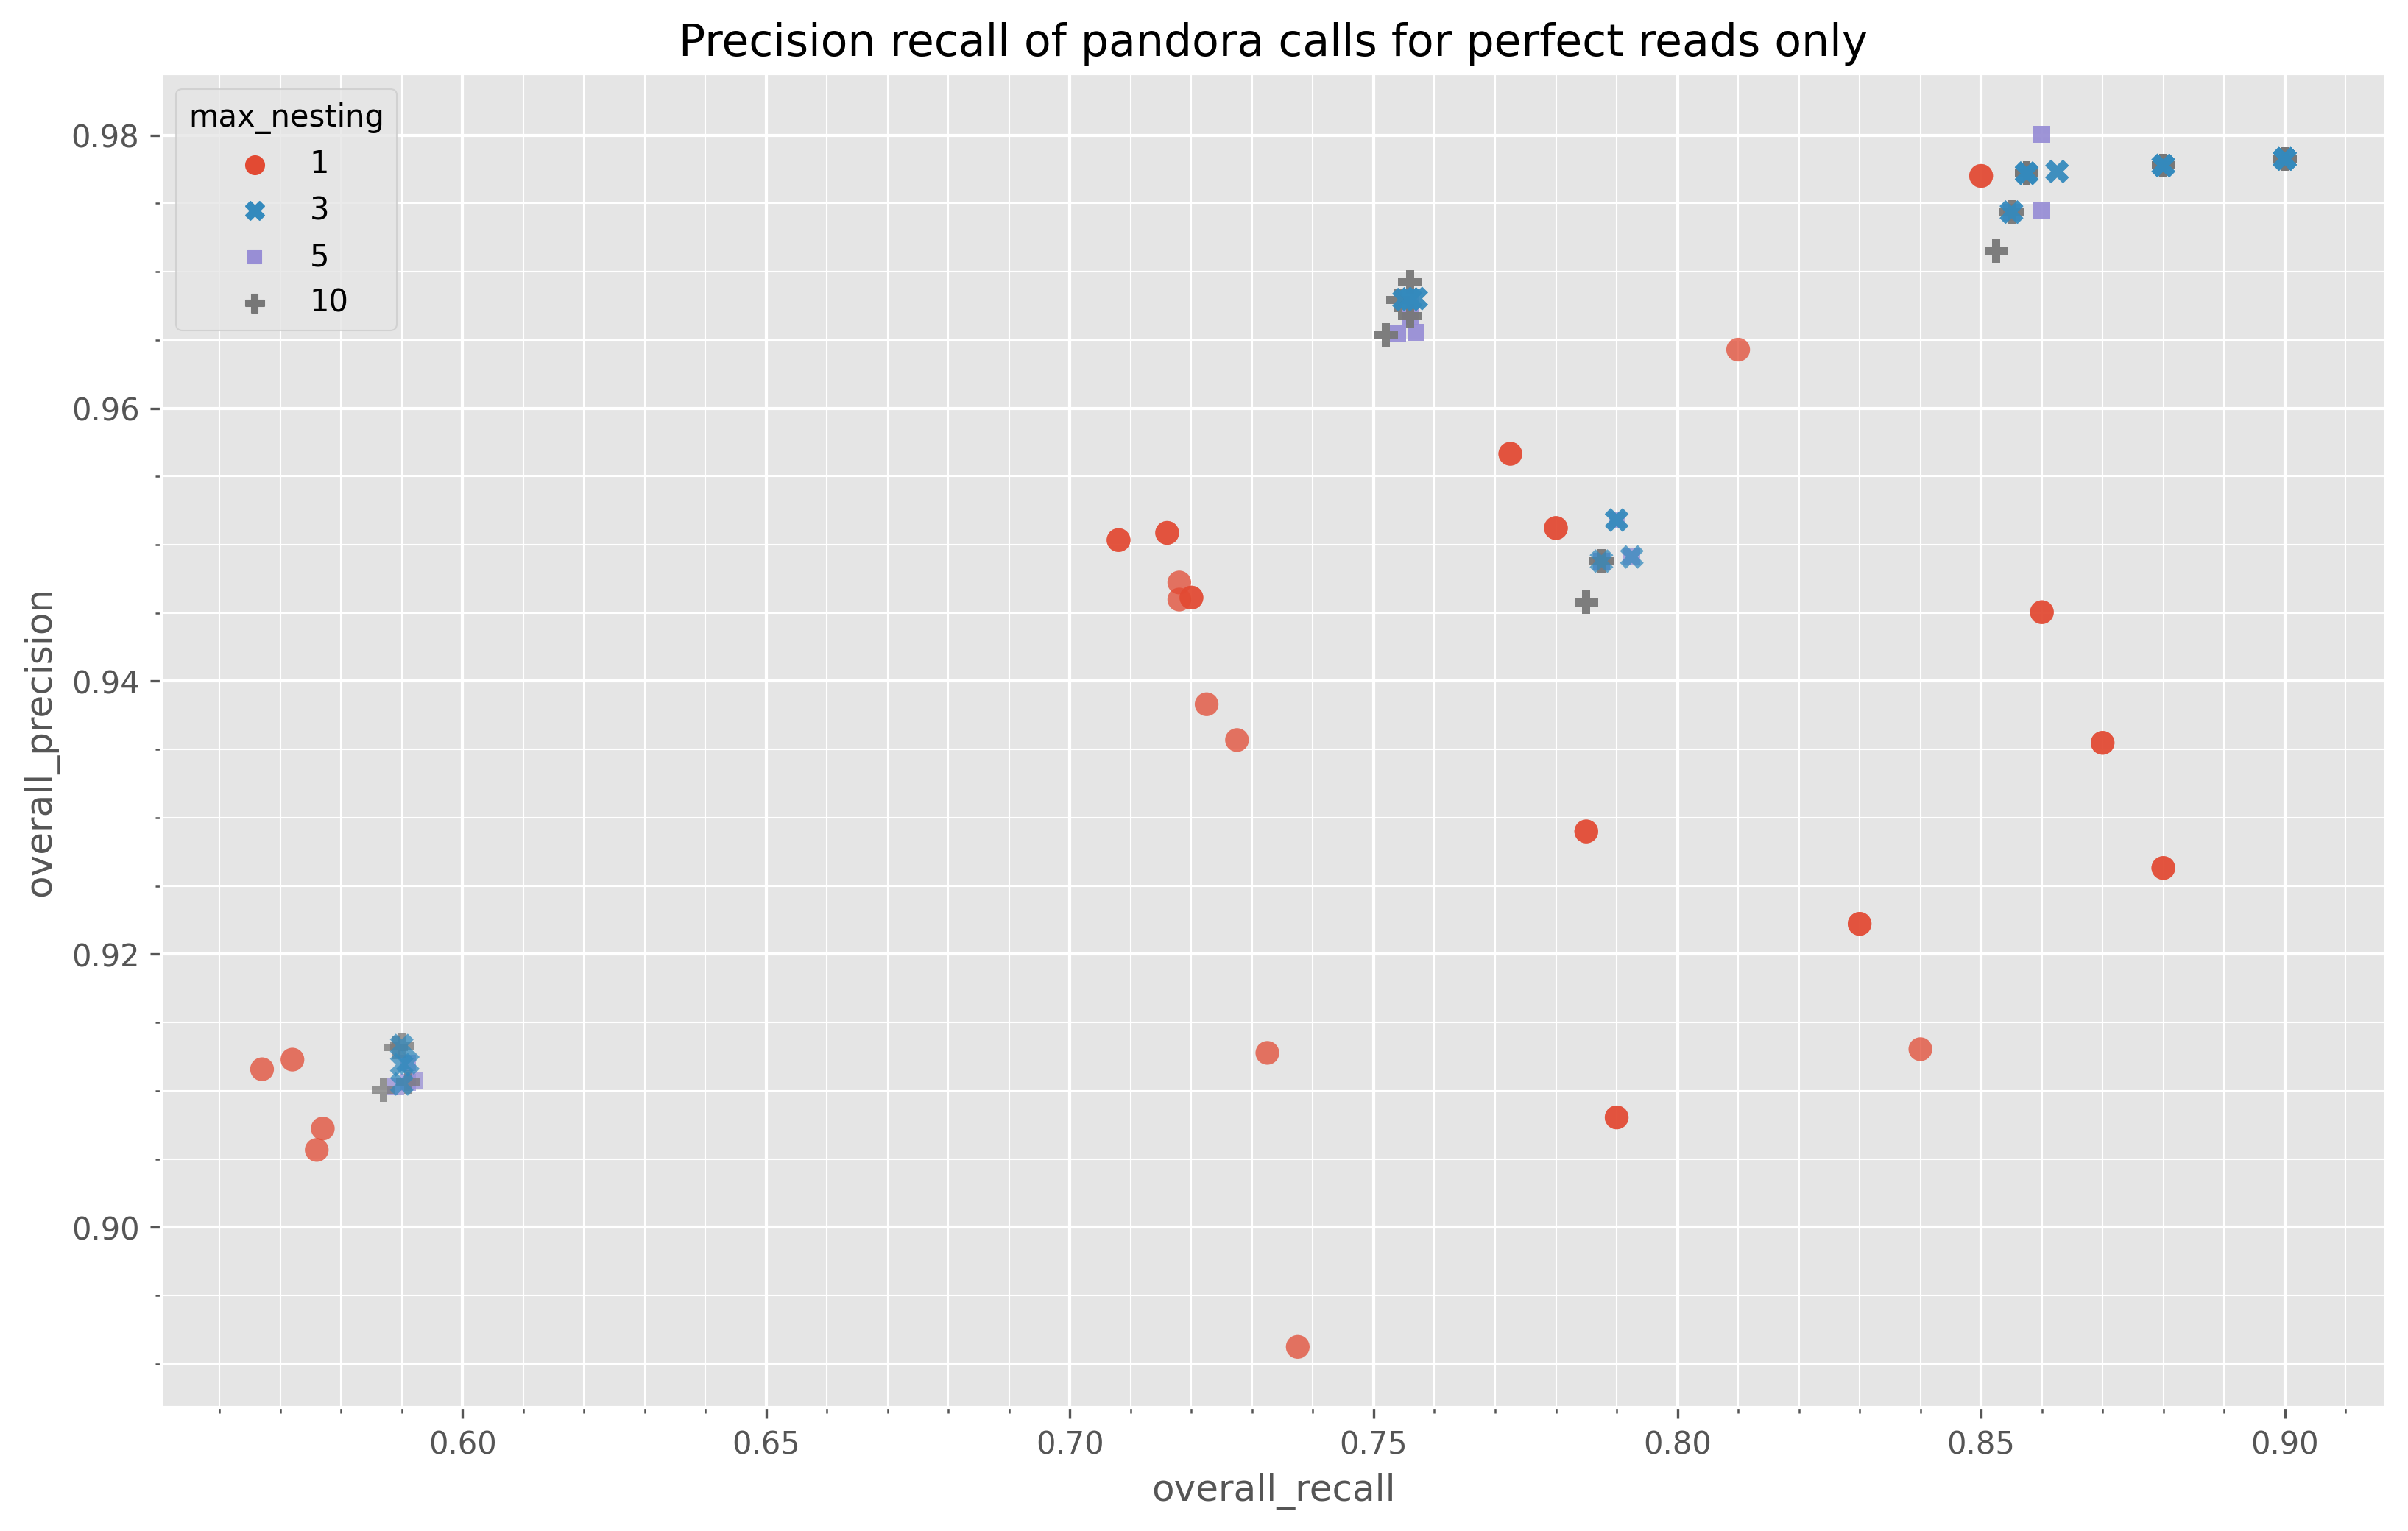

In [93]:
x="overall_recall"
y="overall_precision"
hue="max_nesting"
data = perfect_df
pal = CMAP[:len(set(data[hue]))]

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
plot = sns.scatterplot(x=x, 
                       y=y, 
                       data=data, 
                       ax=ax, 
                       style=hue,
                       palette=pal, 
                       hue=hue, 
                       legend="full", 
                       linewidth=lw,
                       alpha=alpha,
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

In [94]:
data.groupby([hue])[[x, y]].describe().T

max_nesting                     1          3          5          10
overall_recall    count  36.000000  36.000000  36.000000  36.000000
                  mean    0.761694   0.809833   0.809625   0.808417
                  std     0.088096   0.095781   0.095626   0.096044
                  min     0.567000   0.590000   0.589000   0.587000
                  25%     0.718000   0.756000   0.756000   0.756000
                  50%     0.776250   0.856250   0.855000   0.853750
                  75%     0.832500   0.880000   0.880000   0.880000
                  max     0.880000   0.900000   0.900000   0.900000
overall_precision count  36.000000  36.000000  36.000000  36.000000
                  mean    0.935610   0.965072   0.964375   0.964238
                  std     0.020794   0.020934   0.021176   0.021076
                  min     0.891239   0.910494   0.910355   0.910078
                  25%     0.919928   0.967949   0.965429   0.965340
                  50%     0.937002   0.975783   0.974359   0.972934
                  75%     0.950467   0.977778   0.978261   0.977778
                  max     0.977011   0.978261   0.980057   0.978261

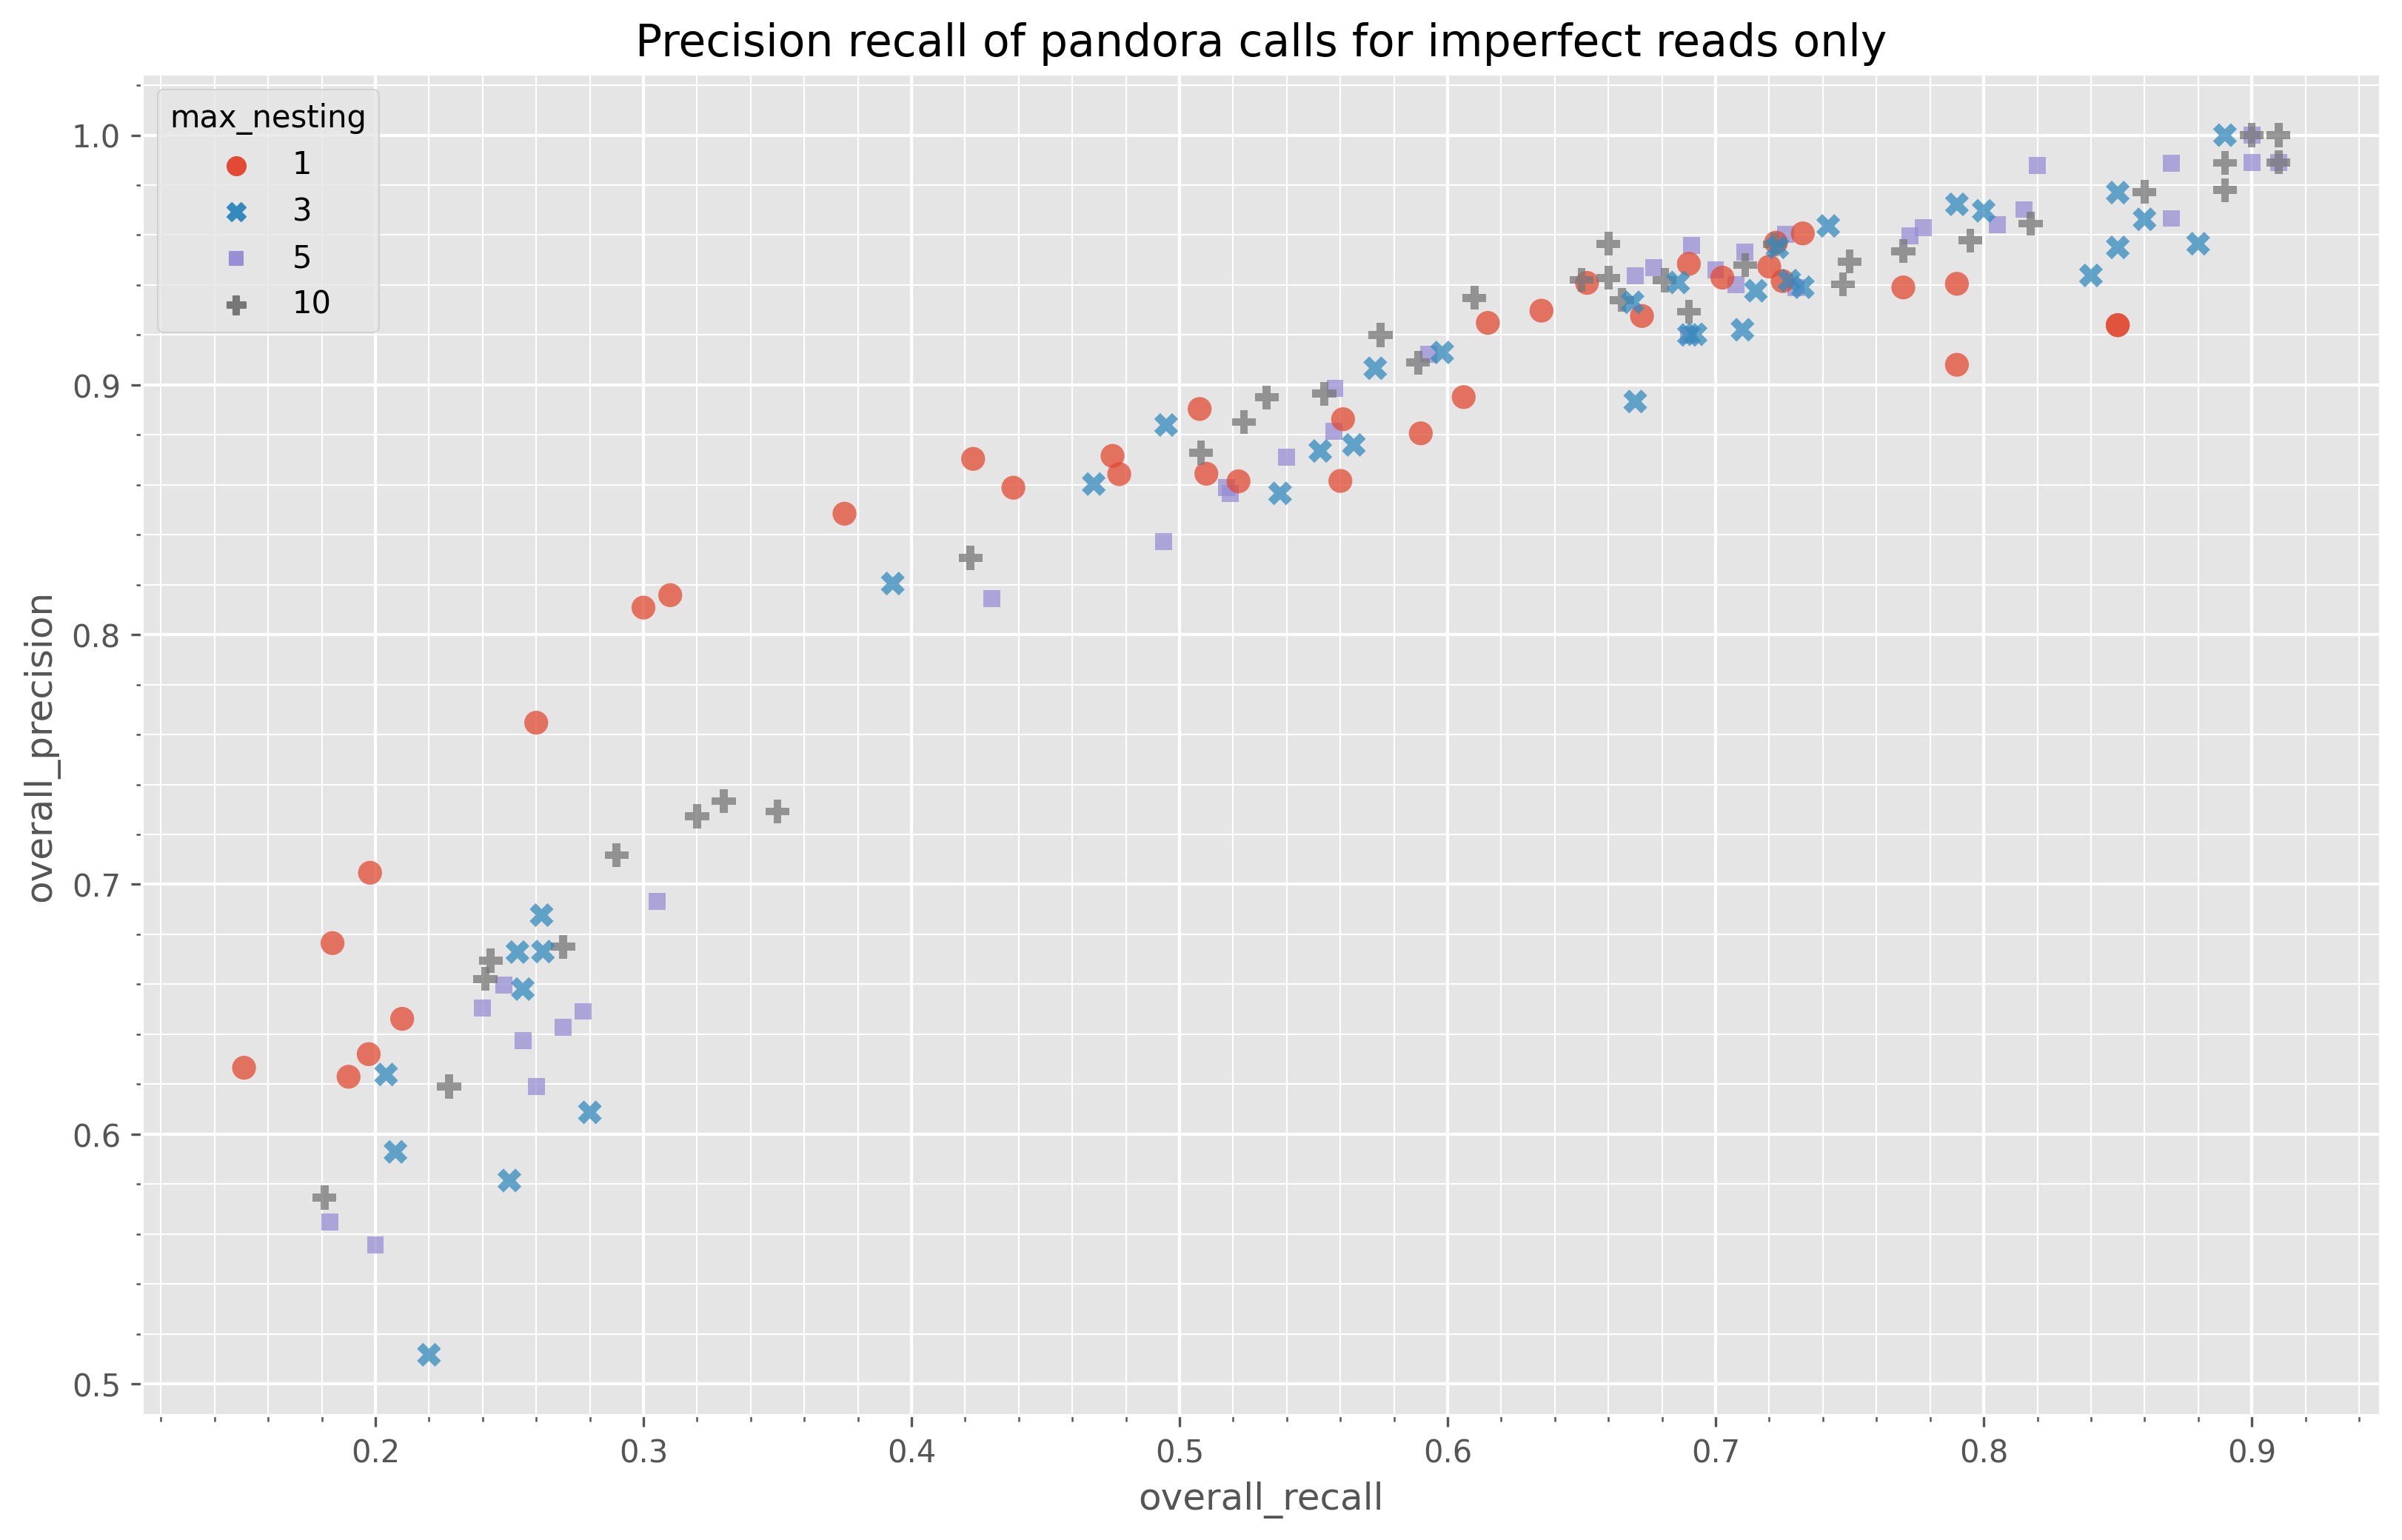

In [95]:
data = imperfect_df

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
plot = sns.scatterplot(x=x, 
                       y=y, 
                       data=data, 
                       ax=ax, 
                       style=hue,
                       palette=pal, 
                       hue=hue, 
                       legend="full", 
                       linewidth=lw,
                       alpha=alpha,
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

In [96]:
data.groupby([hue])[[x, y]].describe().T

max_nesting                     1          3          5          10
overall_recall    count  36.000000  36.000000  36.000000  36.000000
                  mean    0.526736   0.580375   0.588611   0.595722
                  std     0.213573   0.228677   0.232482   0.225167
                  min     0.151000   0.204000   0.183000   0.181000
                  25%     0.358750   0.364750   0.398750   0.404000
                  50%     0.560500   0.669500   0.673500   0.655000
                  75%     0.706875   0.734875   0.773750   0.755000
                  max     0.850000   0.890000   0.910000   0.910000
overall_precision count  36.000000  36.000000  36.000000  36.000000
                  mean    0.855817   0.850228   0.857923   0.874870
                  std     0.103458   0.140540   0.141923   0.123129
                  min     0.622951   0.511628   0.555556   0.574603
                  25%     0.840260   0.787260   0.784091   0.806365
                  50%     0.883426   0.916489   0.929453   0.934427
                  75%     0.932047   0.946629   0.960950   0.956349
                  max     0.960656   1.000000   1.000000   1.000000

It appears as though a maximum nesting level of 3 or 5 tends to be more commonly in the top right quadrant for imperfect reads.

In summary, the discover of variants doesn't seem to depend too much on the maximum nesting level, although a value of 3 or 5 might be slightly beneficial. **We would advocate the use of 5 as a default**.

## Effect of the number of SNPs
Bacterial species vary in their mutation rate and therefore we thought it would be useful to assess whether more or less SNPs per gene effects `pandora`'s ability to discover *de novo* mutations.  

*Note:* the number of SNPs in the plots is the number of SNPs per gene multiplied by the number of genes in total (50 in this case).

The relationship for the perfect reads can be summed up as the less SNPs per gene there is, the less candidate slices that contain a variant. Interestingly, 3 and 5 SNPs per gene fall around 100% of slices containing variants (precision). Once you get to 10 SNPs per gene the precision moves over 100%, meaning multiple SNPs are being found in the same slice. For the 1 SNP per gene we are finding 50-80% of slices contain a variant. This is probably a fairly expected relationship; the more SNPs there are, the more likely it is that a slice will contain a SNP. For the perfect reads it appears that the number of SNPs per gene has no effect on the recall.  

For the imperfect reads we see very much the same relationship as the perfect reads: precision increases with increasing number of SNPs per gene, however, the differences are more pronounced. We see that, at best, for the 1 SNP per gene samples we have ~55% of slices containing a variant, meaning we are running *de novo* discovery twice for every variant we find. In the average case for the 10 SNPs per gene samples, we get a variant every time we run *de novo* discovery. Again, the recall, i.e the percentage of variants we discover, does not seem to be exerting any effect on the number of SNPs, but you can very clearly see the impact that coverage has here. Each colour in the plot has a very distinct second-order polynomial relationship and if you lay coverage information over this you can see this relationship is defined purely by the amount of coverage (see below).

And now looking at the same thing from the VCF output of `pandora`

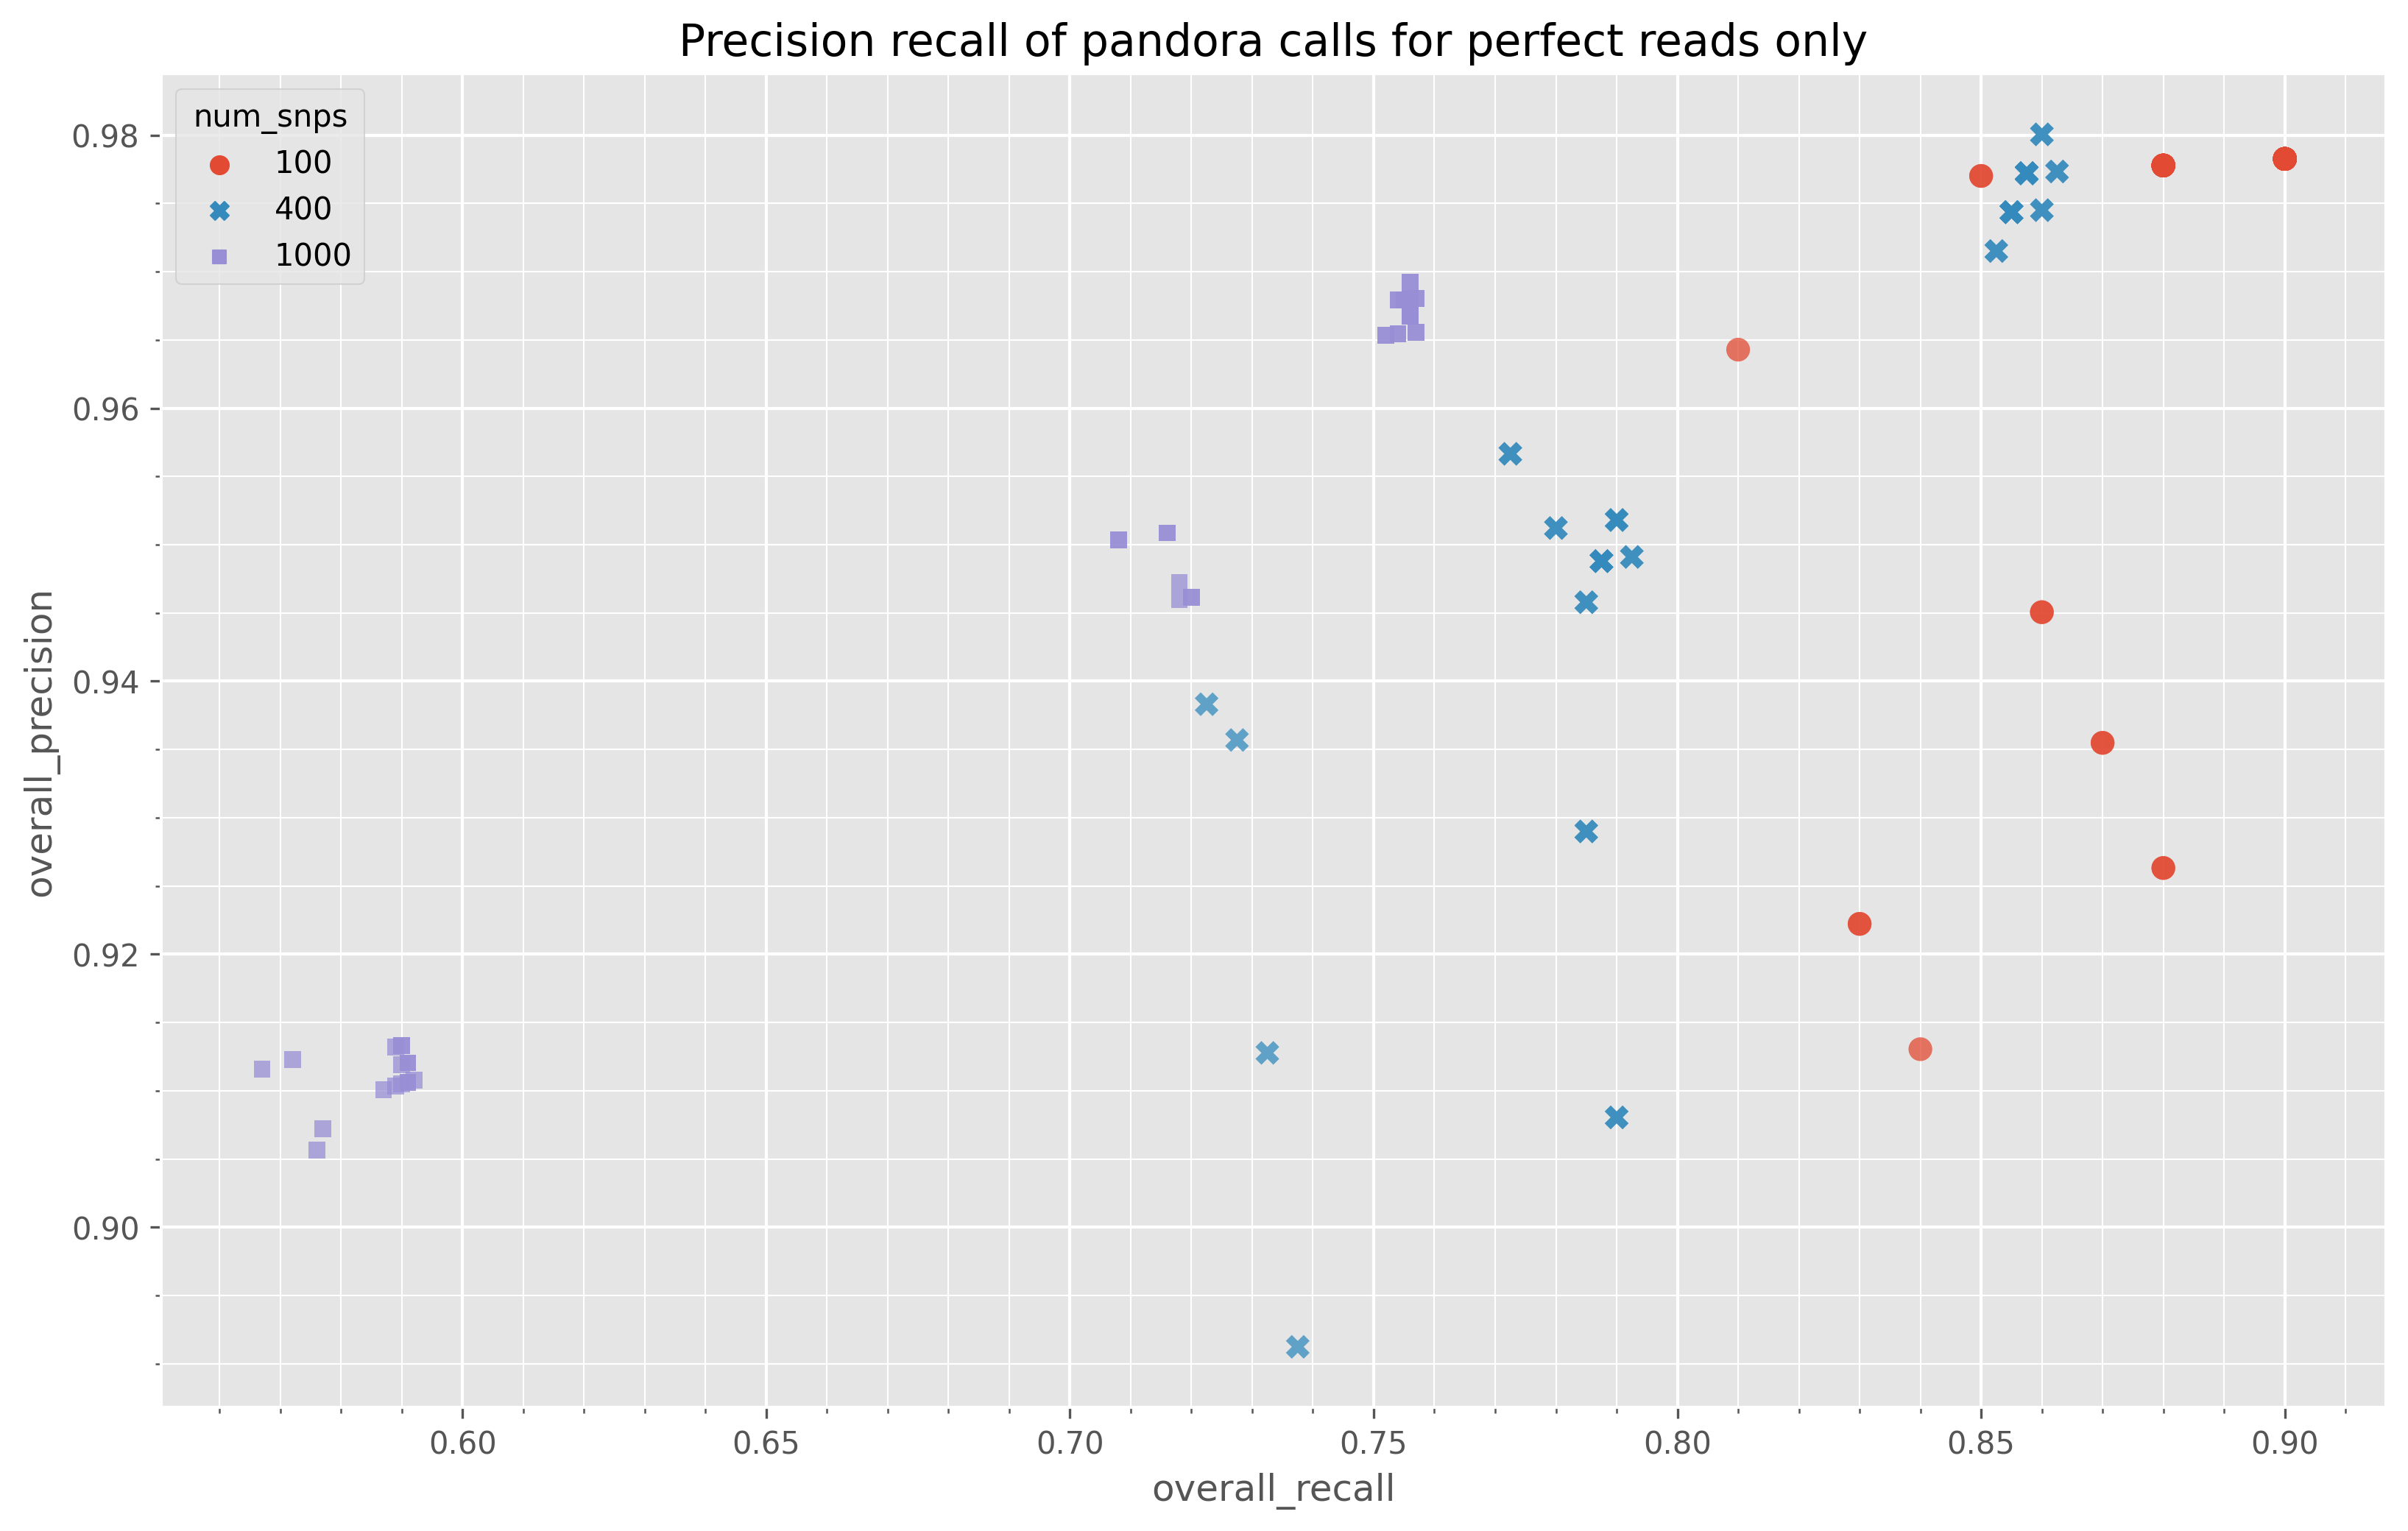

In [104]:
x = "overall_recall"
y = "overall_precision"
hue = "num_snps"
data = perfect_df
pal = CMAP[:len(set(data[hue]))]

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
plot = sns.scatterplot(x=x, 
                       y=y, 
                       data=data, 
                       ax=ax, 
                       style=hue,
                       palette=pal, 
                       hue=hue, 
                       legend="full", 
                       linewidth=lw,
                       alpha=alpha,
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

In [105]:
data.groupby([hue])[[x, y]].describe().T

num_snps                      100        400        1000
overall_recall    count  48.000000  48.000000  48.000000
                  mean    0.883125   0.816823   0.692229
                  std     0.022328   0.043545   0.077531
                  min     0.810000   0.722500   0.567000
                  25%     0.880000   0.786875   0.591000
                  50%     0.890000   0.822500   0.736000
                  75%     0.900000   0.857500   0.756000
                  max     0.900000   0.862500   0.757000
overall_precision count  48.000000  48.000000  48.000000
                  mean    0.968773   0.957841   0.945358
                  std     0.019393   0.022061   0.025530
                  min     0.913043   0.891239   0.905660
                  25%     0.977586   0.948795   0.912220
                  50%     0.978019   0.964083   0.958102
                  75%     0.978261   0.975180   0.967918
                  max     0.978261   0.980057   0.969231

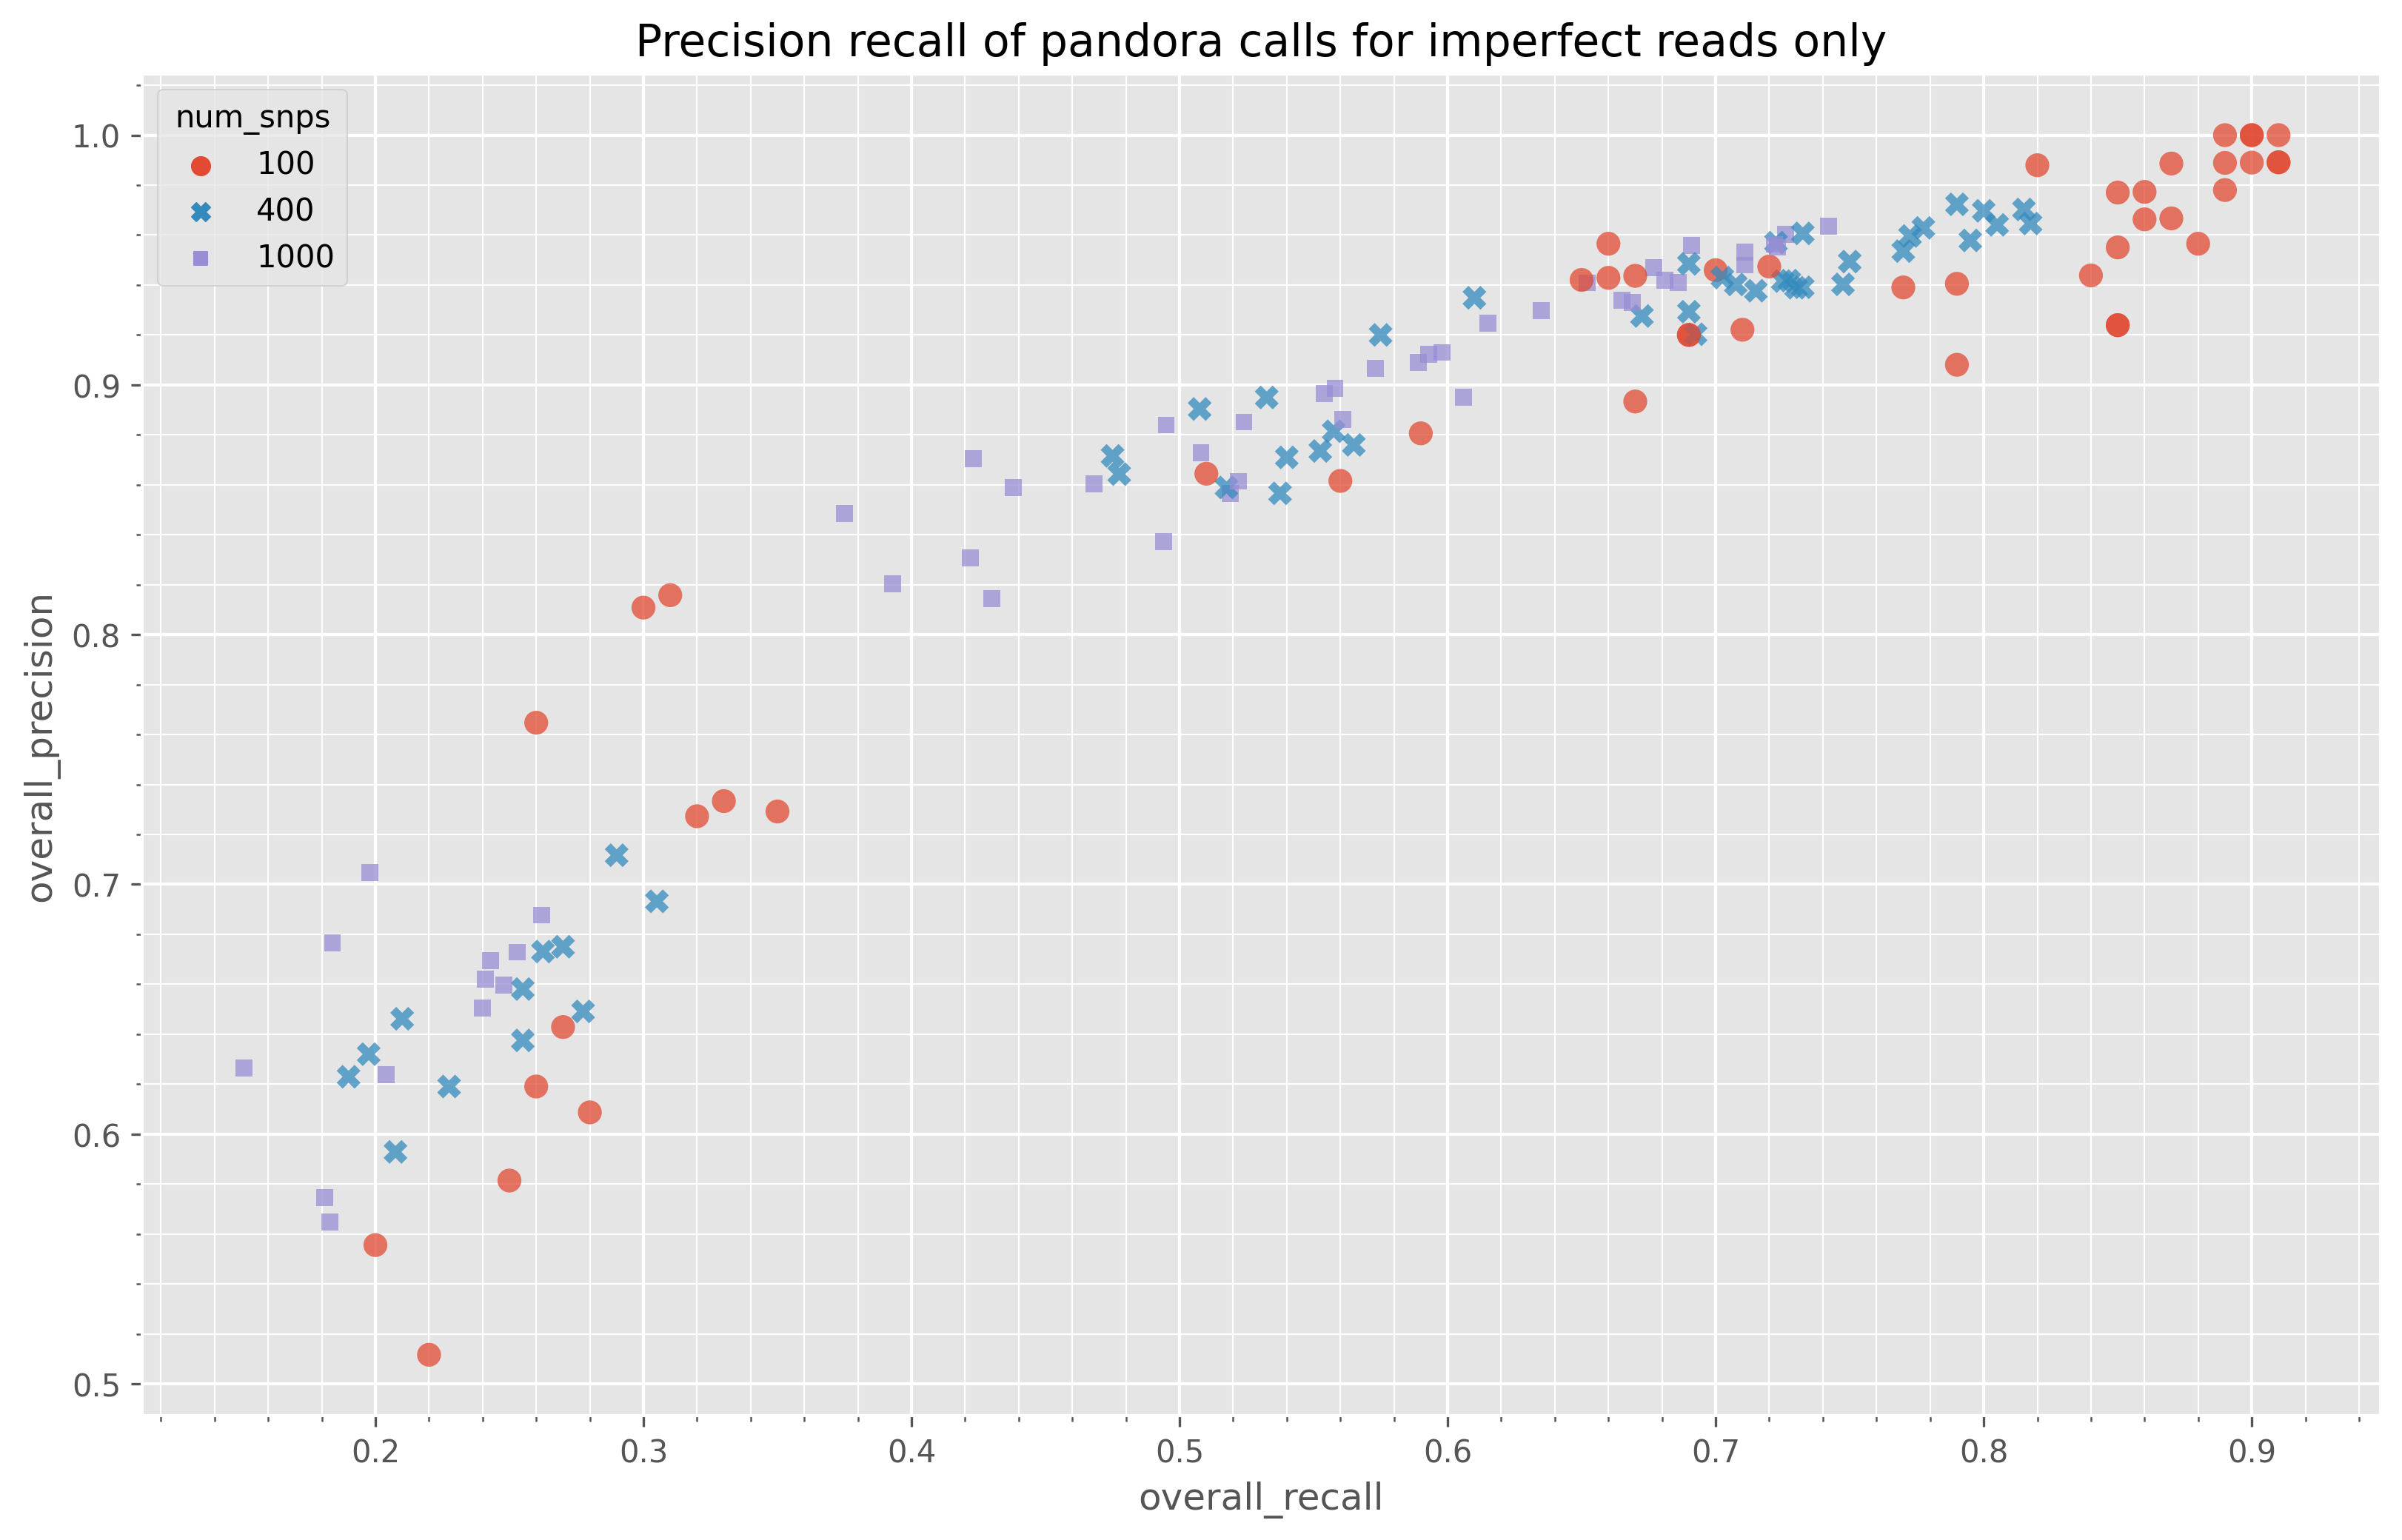

In [106]:
data = imperfect_df
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
plot = sns.scatterplot(x=x, 
                       y=y, 
                       data=data, 
                       ax=ax, 
                       style=hue,
                       palette=pal, 
                       hue=hue, 
                       legend="full", 
                       linewidth=lw,
                       alpha=alpha,
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

In [108]:
data.groupby([hue])[[x, y]].describe().T

num_snps                      100        400        1000
overall_recall    count  48.000000  48.000000  48.000000
                  mean    0.660000   0.568229   0.490354
                  std     0.243800   0.210719   0.186027
                  min     0.200000   0.190000   0.151000
                  25%     0.470000   0.432500   0.346750
                  50%     0.715000   0.641250   0.523000
                  75%     0.862500   0.732500   0.655250
                  max     0.910000   0.817500   0.742000
overall_precision count  48.000000  48.000000  48.000000
                  mean    0.881862   0.858203   0.839063
                  std     0.134435   0.126054   0.119694
                  min     0.511628   0.592857   0.564815
                  25%     0.850101   0.820344   0.786952
                  50%     0.941253   0.923926   0.884532
                  75%     0.977077   0.948682   0.933288
                  max     1.000000   0.972308   0.963636

The effect of the number of SNPs per gene on the precision-recall relationship for `pandora` calls is quite interesting.  
For perfect reads, we see that the more SNPs per gene we have, the less variants we are able to call. Inversely, the more SNPs per gene we have the *more* variants we call correctly. There is a fairly distinct separation between the 10 SNP per gene samples and other groupings.  

For the imperfect reads we actually see a similar relationship than for the perfect reads. We do see a similar relationship with respect to precision (% of variants we call correct) albeit a fairly marginal difference between the number of SNPs per gene. And the recall (% variants we call) is greater the less SNPs per gene we have.  

Given that 10 SNPs per gene is a fairly extreme case (we would expect ~4 for *E. coli* and ~1 for MTB), the number of SNPs per gene doesn't seem to impact the ability of *de novo* discovery. 

## Effect of *de novo* k-mer size
After `pandora` has identified the slices in the graph which could be *de novo* mutations we build a de Bruijn graph from the reads mapping to these slices. Here we look at the effect of altering the k-mer size used for the de Bruijn graph.

These results suggest that the k-mer sizes used here do not differ from each other in their ability to discover *de novo* variants in the graph.

And now looking at the same thing from the VCF output of `pandora`

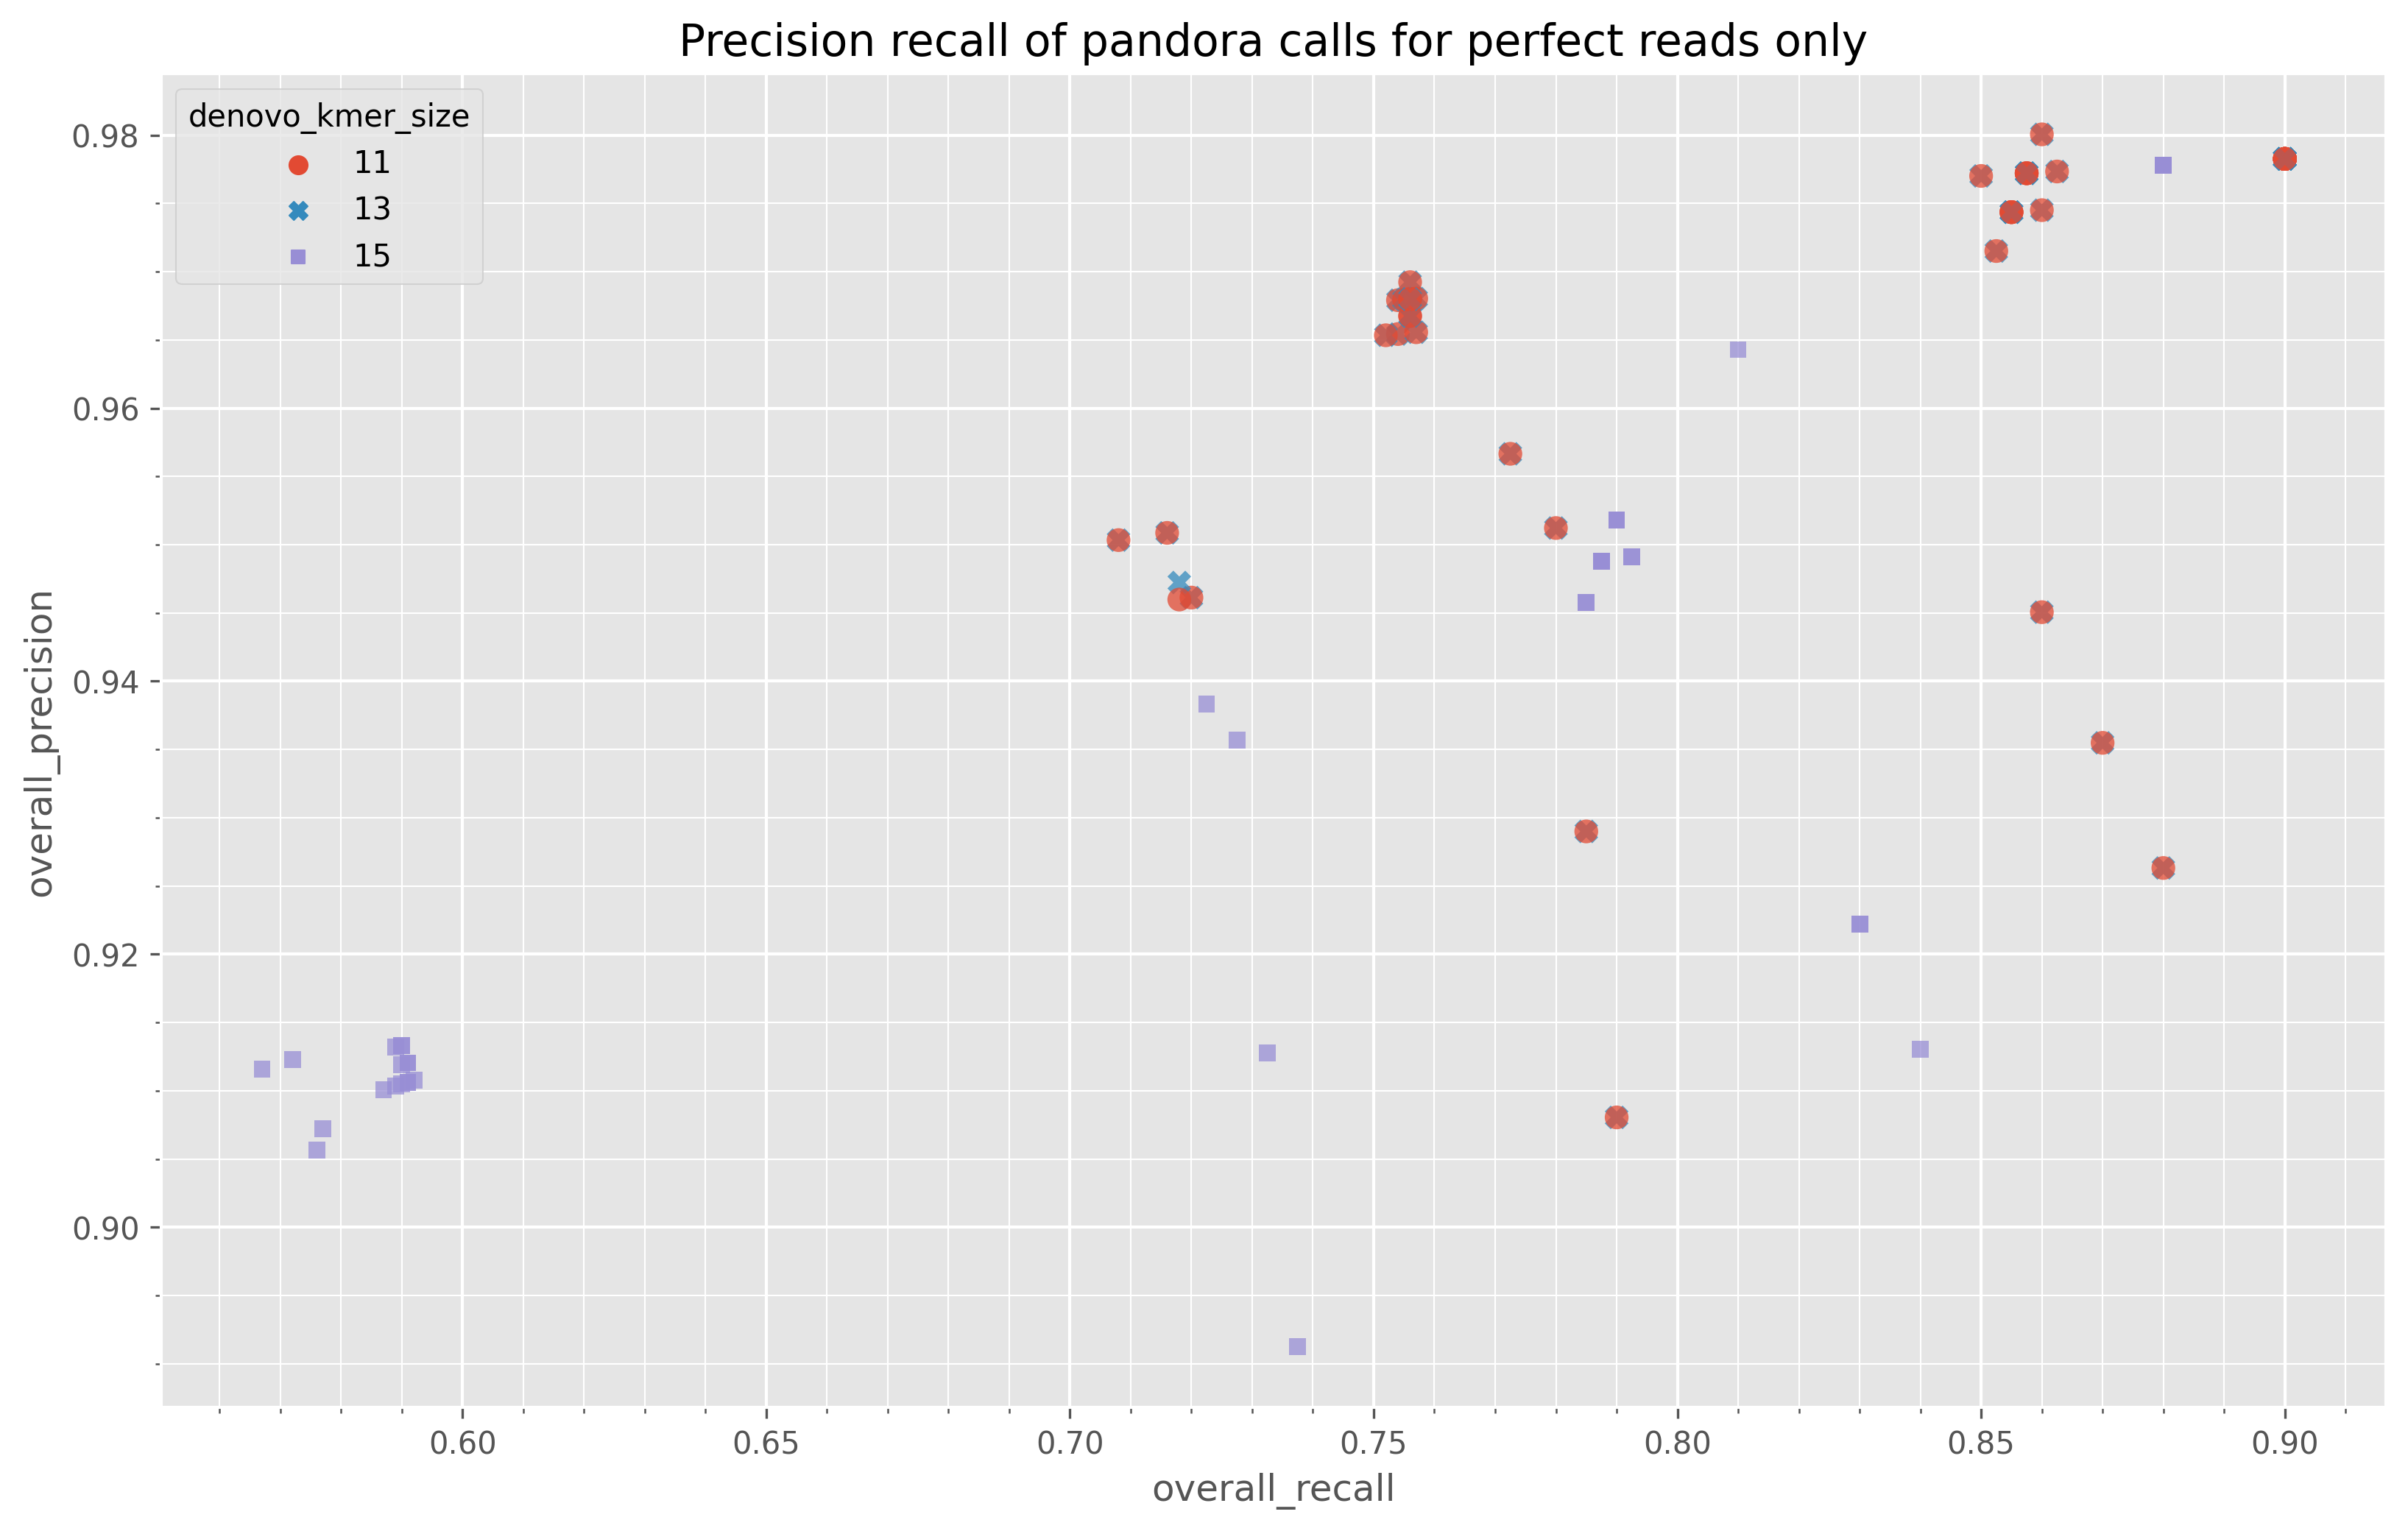

In [110]:
x="overall_recall"
y="overall_precision"
hue="denovo_kmer_size"
data = perfect_df
pal = CMAP[:len(set(data[hue]))]

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
plot = sns.scatterplot(x=x, 
                       y=y, 
                       data=data, 
                       ax=ax, 
                       style=hue,
                       palette=pal, 
                       hue=hue, 
                       legend="full", 
                       linewidth=lw,
                       alpha=alpha,
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

In [111]:
data.groupby([hue])[[x, y]].describe().T

denovo_kmer_size                11         13         15
overall_recall    count  48.000000  48.000000  48.000000
                  mean    0.824990   0.824990   0.742198
                  std     0.065333   0.065333   0.119953
                  min     0.708000   0.708000   0.567000
                  25%     0.756000   0.756000   0.591000
                  50%     0.855000   0.855000   0.787500
                  75%     0.885000   0.885000   0.850000
                  max     0.900000   0.900000   0.880000
overall_precision count  48.000000  48.000000  48.000000
                  mean    0.966204   0.966230   0.939537
                  std     0.016255   0.016223   0.027979
                  min     0.908046   0.908046   0.891239
                  25%     0.965407   0.965407   0.912037
                  50%     0.972934   0.972934   0.945783
                  75%     0.978261   0.978261   0.967659
                  max     0.980057   0.980057   0.977778

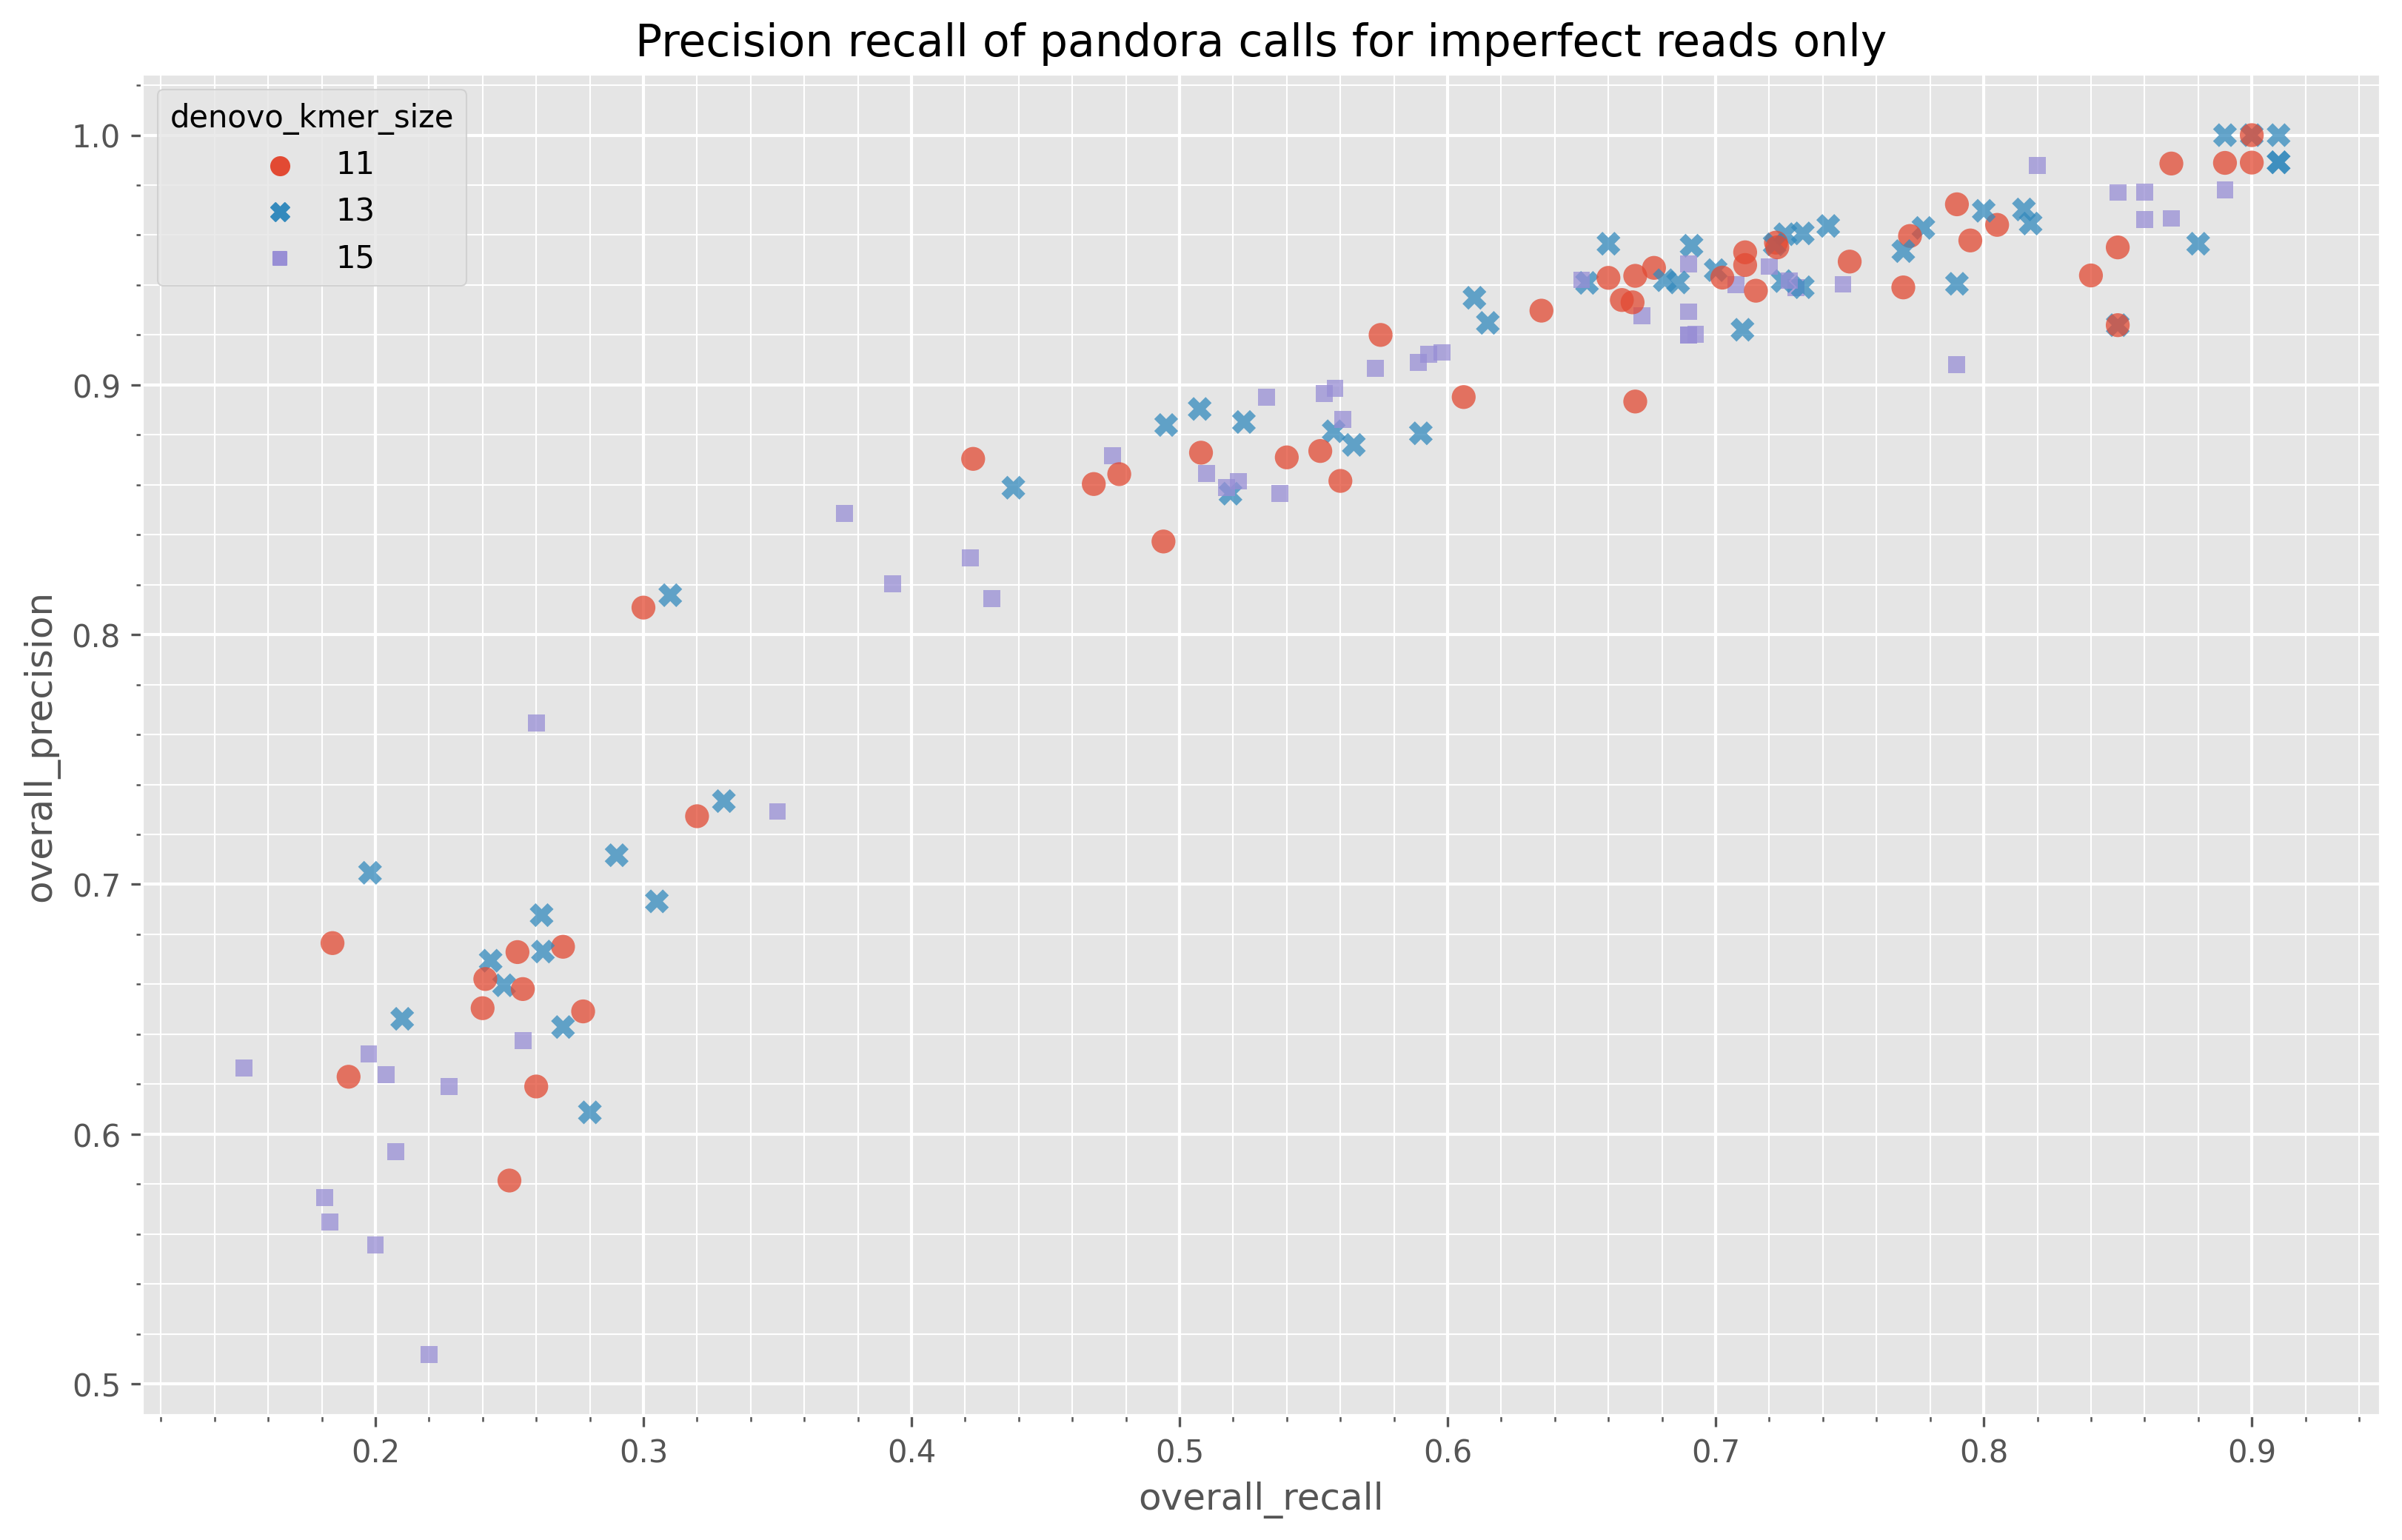

In [112]:
data = imperfect_df
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
plot = sns.scatterplot(x=x, 
                       y=y, 
                       data=data, 
                       ax=ax, 
                       style=hue,
                       palette=pal, 
                       hue=hue, 
                       legend="full", 
                       linewidth=lw,
                       alpha=alpha,
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

In [113]:
data.groupby([hue])[[x, y]].describe().T

denovo_kmer_size                11         13         15
overall_recall    count  48.000000  48.000000  48.000000
                  mean    0.582458   0.600198   0.535927
                  std     0.224093   0.225591   0.223196
                  min     0.184000   0.198000   0.151000
                  25%     0.397250   0.411000   0.368750
                  50%     0.662500   0.670500   0.559500
                  75%     0.755000   0.771875   0.696250
                  max     0.900000   0.910000   0.890000
overall_precision count  48.000000  48.000000  48.000000
                  mean    0.864177   0.876335   0.838616
                  std     0.123854   0.118371   0.138272
                  min     0.581395   0.608696   0.511628
                  25%     0.830669   0.846274   0.801972
                  50%     0.926817   0.936984   0.897495
                  75%     0.950296   0.957471   0.939230
                  max     1.000000   1.000000   0.987952

The k-mer size using for *de novo* discovery does not appear to have a strong influence on the precision-recall relationship. There is perhaps a slight advangtage to using a *k* value of 11 or 13.  

In summary, the default *de novo* k-mer size of 11 is fine to stay as it is, but the use of 13 would unlikely make much difference to the results.

# Recall and error rate relationship
Here we will look at the parameter effects on the recall-error rate relationship.  

*Note:* The error rate here is defined as 1 - accuracy. In addition, as we are ignoring true negatives, this metric will look much higher than you would normally see as we are only looking at sites where we have added a variant, and not every site in the genome.

## Effect of coverage

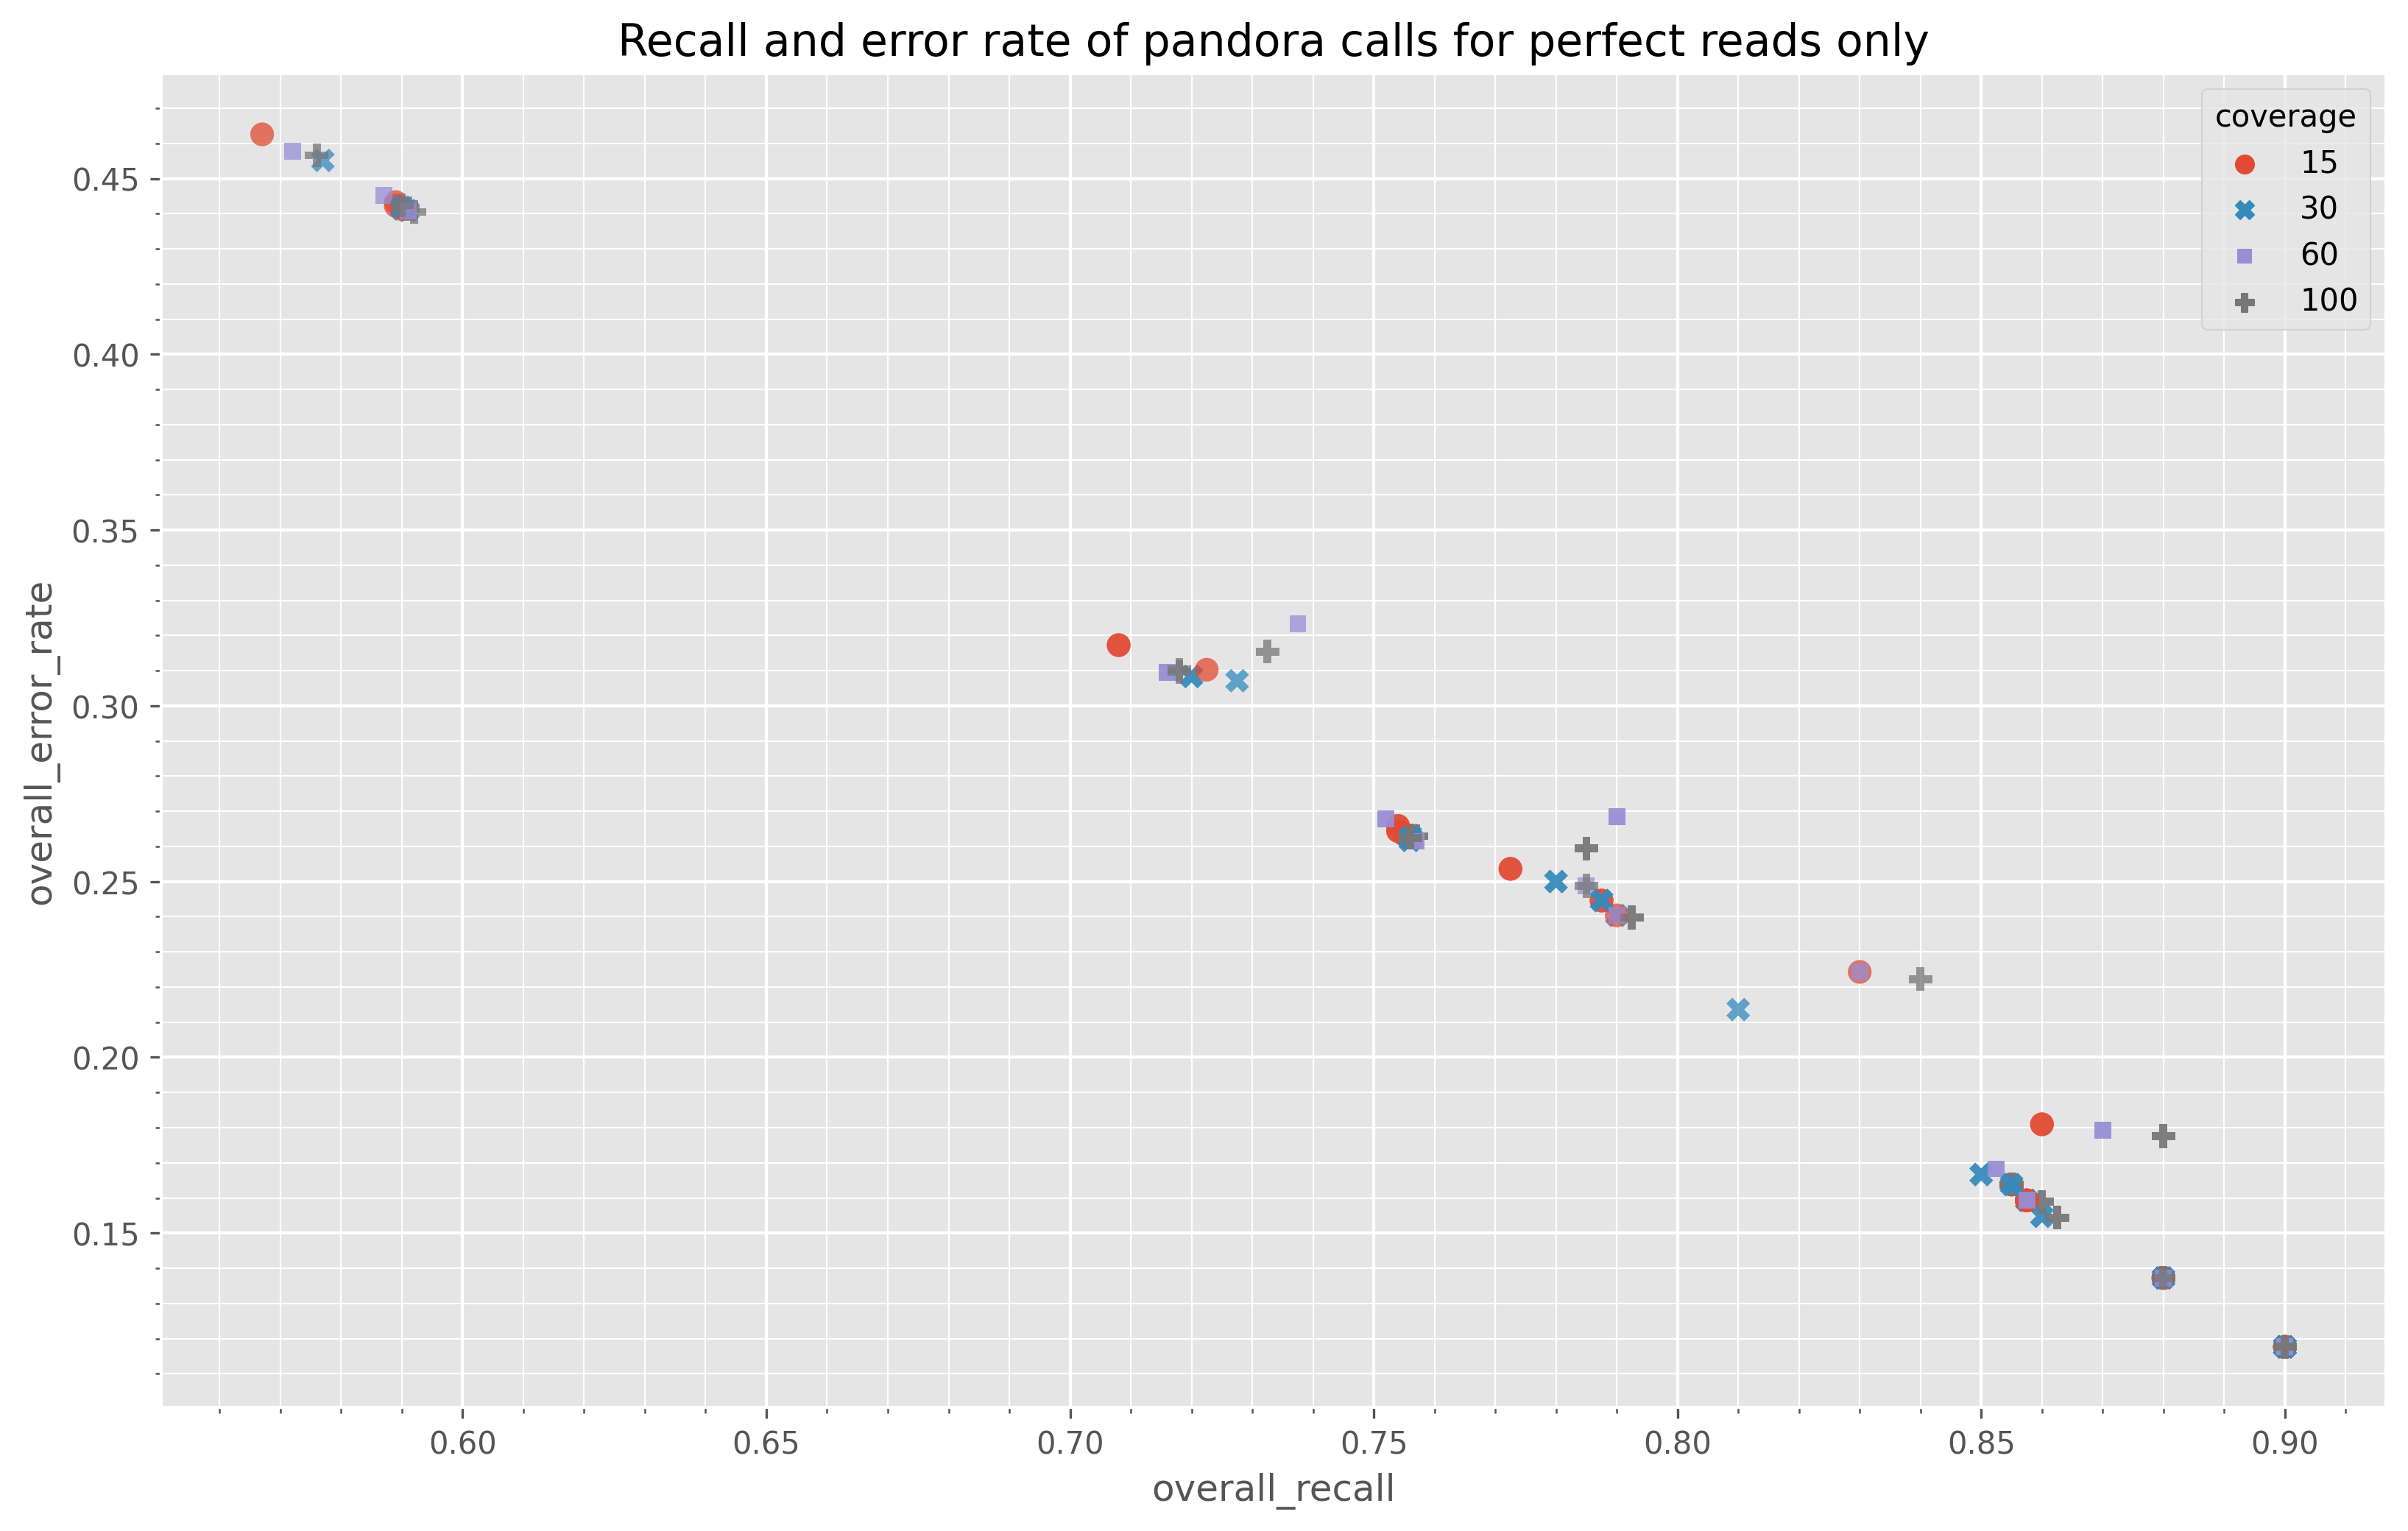

In [121]:
x="overall_recall"
y="overall_error_rate"
hue="coverage"
data = perfect_df
pal = CMAP[:len(set(data[hue]))]

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
plot = sns.scatterplot(x=x, 
                       y=y, 
                       data=data, 
                       ax=ax, 
                       style=hue,
                       palette=pal, 
                       hue=hue, 
                       legend="full", 
                       linewidth=lw,
                       alpha=alpha,
                       s=POINT_SIZE)

_ = plot.set(title="Recall and error rate of pandora calls for perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

In [122]:
data.groupby([hue])[[x, y]].describe().T

coverage                        15         30         60         100
overall_recall     count  36.000000  36.000000  36.000000  36.000000
                   mean    0.795542   0.796431   0.797861   0.799736
                   std     0.097198   0.095049   0.096140   0.096528
                   min     0.567000   0.577000   0.572000   0.576000
                   25%     0.754000   0.756000   0.755000   0.756000
                   50%     0.810000   0.800000   0.810000   0.816250
                   75%     0.865000   0.865000   0.872500   0.880000
                   max     0.900000   0.900000   0.900000   0.900000
overall_error_rate count  36.000000  36.000000  36.000000  36.000000
                   mean    0.228527   0.225767   0.229589   0.227492
                   std     0.100684   0.099972   0.100344   0.100202
                   min     0.117647   0.117647   0.117647   0.117647
                   25%     0.153799   0.150407   0.153799   0.150123
                   50%     0.232342   0.226988   0.232342   0.231015
                   75%     0.264748   0.262619   0.267957   0.262966
                   max     0.462559   0.455146   0.457820   0.456604

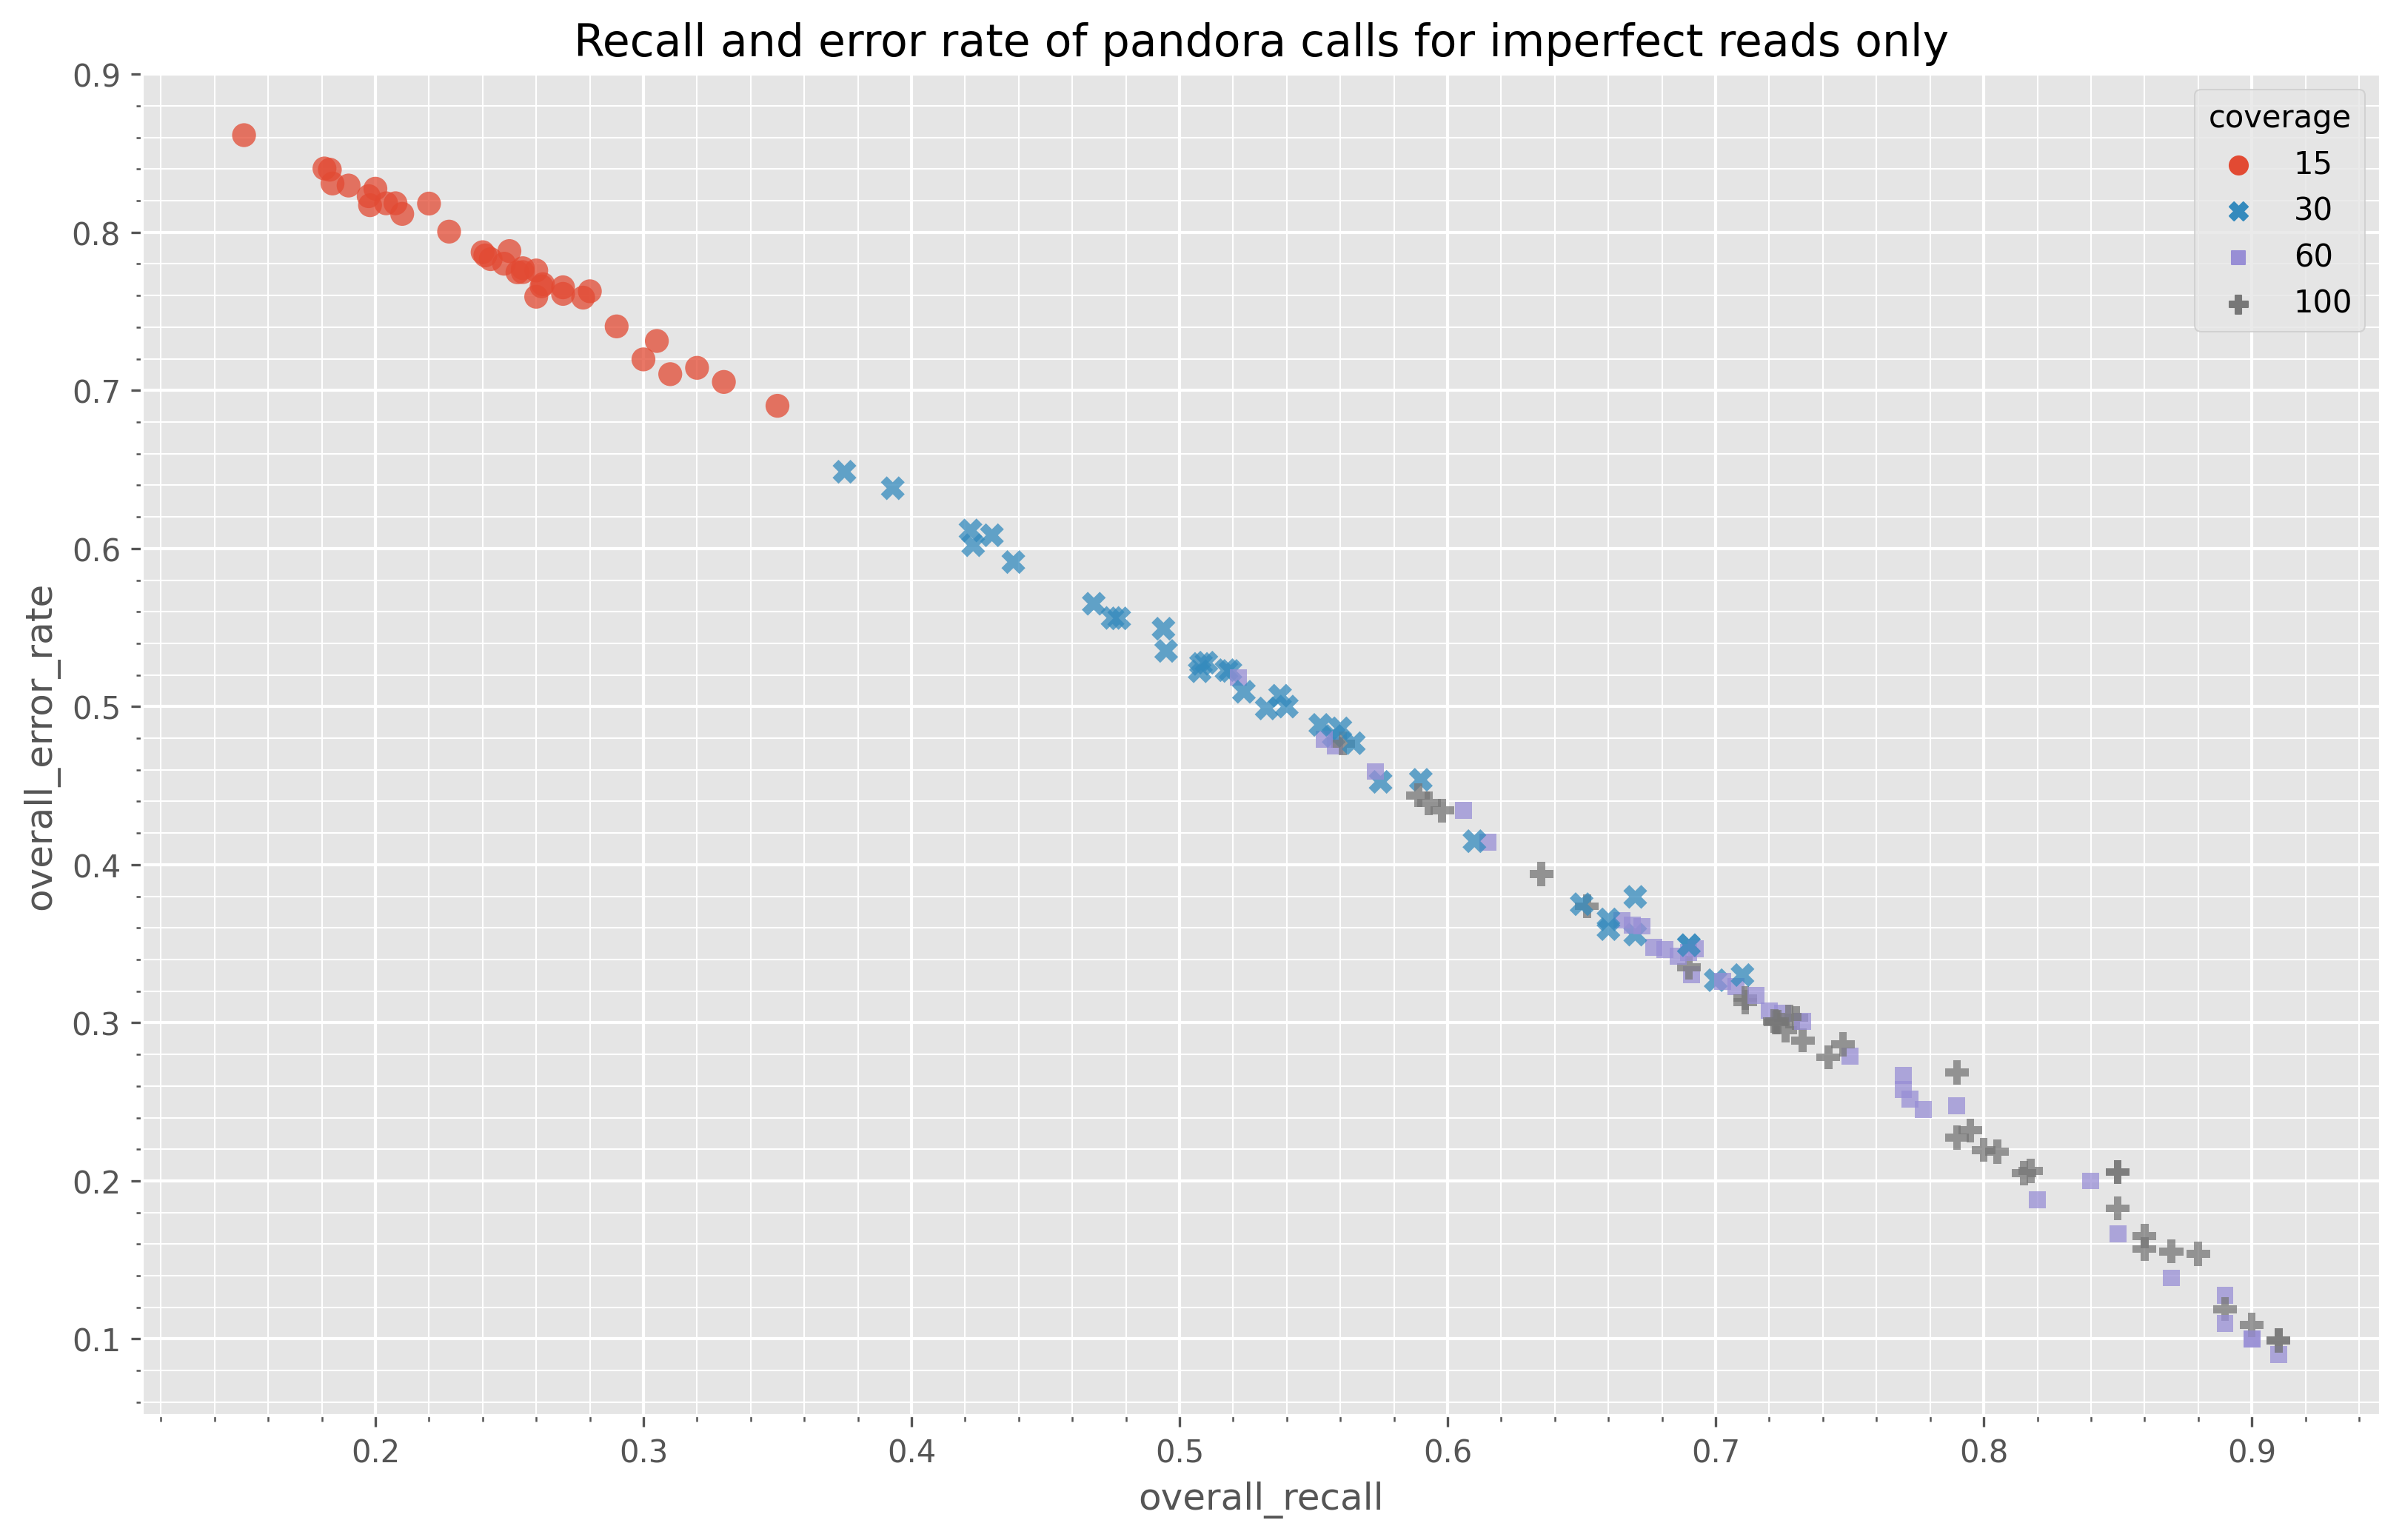

In [123]:
data = imperfect_df
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
plot = sns.scatterplot(x=x, 
                       y=y, 
                       data=data, 
                       ax=ax, 
                       style=hue,
                       palette=pal, 
                       hue=hue, 
                       legend="full", 
                       linewidth=lw,
                       alpha=alpha,
                       s=POINT_SIZE)
_ = plot.set(title="Recall and error rate of pandora calls for imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

In [124]:
data.groupby([hue])[[x, y]].describe().T

coverage                        15         30         60         100
overall_recall     count  36.000000  36.000000  36.000000  36.000000
                   mean    0.246819   0.547125   0.732069   0.765431
                   std     0.046845   0.093065   0.105333   0.097505
                   min     0.151000   0.375000   0.522000   0.561000
                   25%     0.206625   0.489875   0.675875   0.719250
                   50%     0.251500   0.535000   0.717500   0.768750
                   75%     0.271875   0.620000   0.797500   0.850000
                   max     0.350000   0.710000   0.910000   0.910000
overall_error_rate count  36.000000  36.000000  36.000000  36.000000
                   mean    0.780972   0.487313   0.293771   0.261401
                   std     0.042394   0.092844   0.114371   0.100983
                   min     0.690265   0.326923   0.090000   0.099010
                   25%     0.760611   0.406058   0.233859   0.199332
                   50%     0.778717   0.503440   0.312557   0.273364
                   75%     0.818222   0.550906   0.351099   0.306132
                   max     0.861468   0.648547   0.518450   0.476679

From this we can see that coverage again has an impact on the relationship.Once you get below 60x coverage the error rate increases quite a bit, although 30x isn't too bad.

## Effect of maximum nesting level

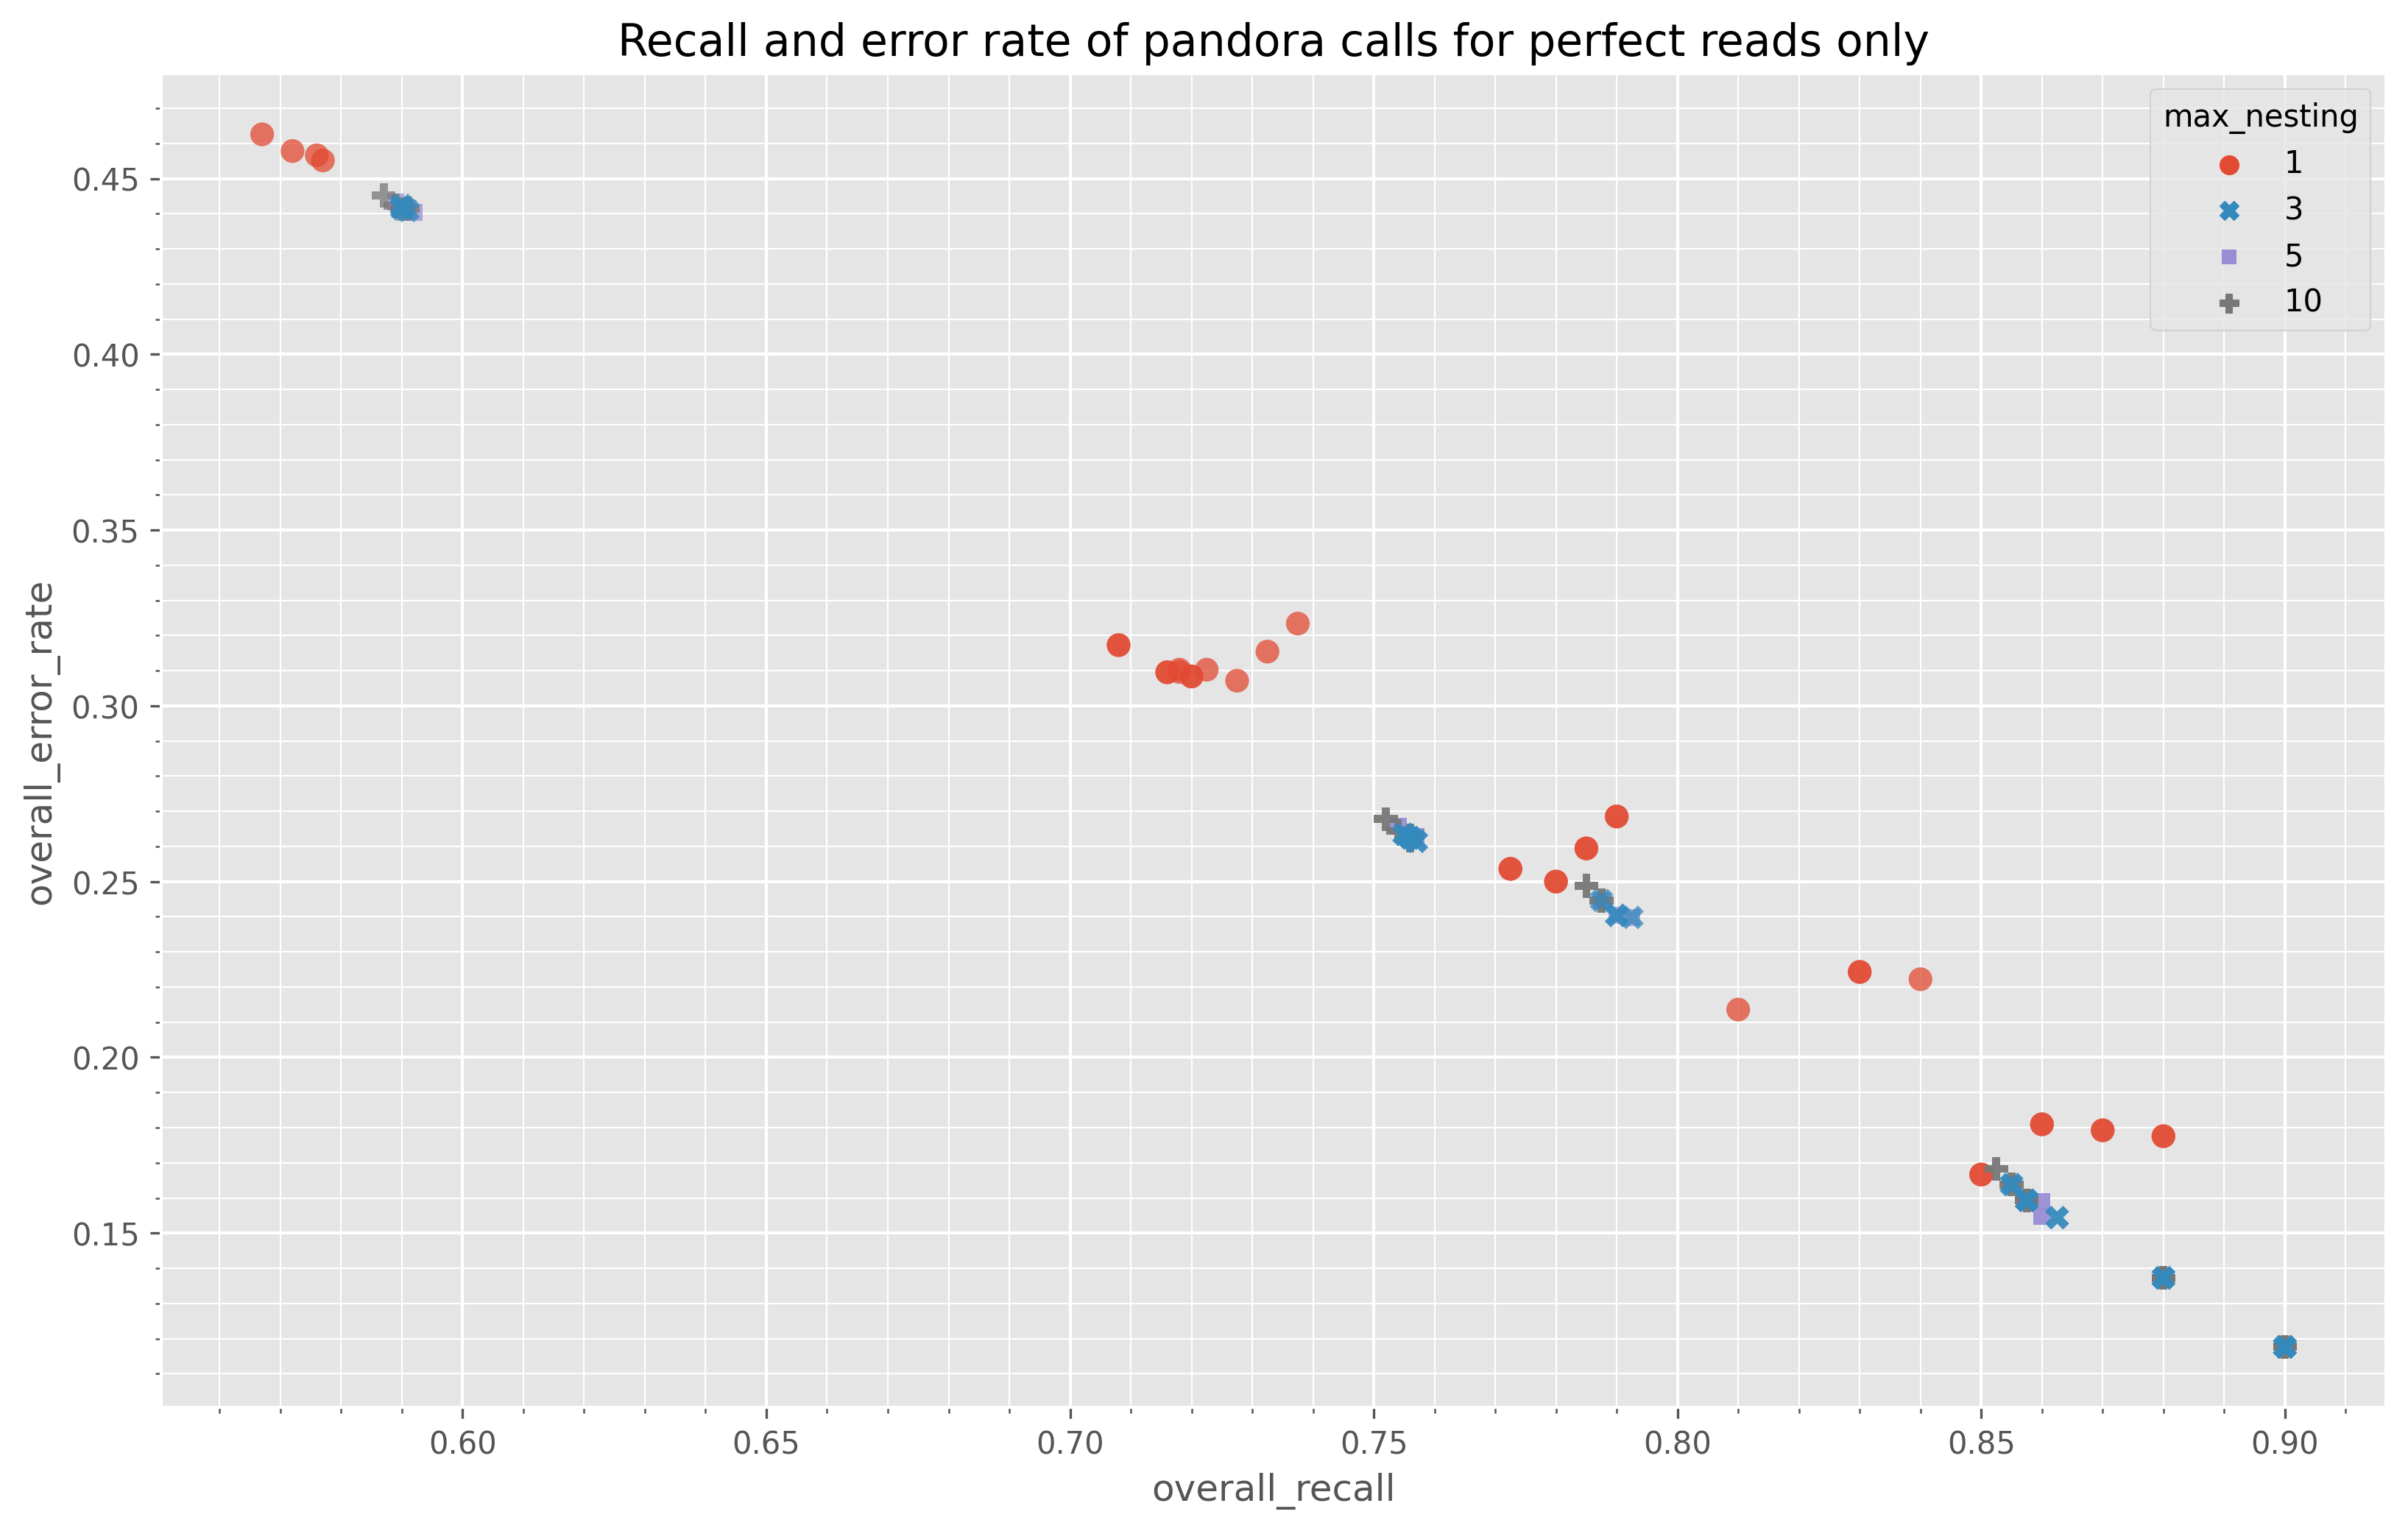

In [127]:
hue = "max_nesting"
data = perfect_df
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
plot = sns.scatterplot(x=x, 
                       y=y, 
                       data=data, 
                       ax=ax, 
                       style=hue,
                       palette=pal, 
                       hue=hue, 
                       legend="full", 
                       linewidth=lw,
                       alpha=alpha,
                       s=POINT_SIZE)
_ = plot.set(title="Recall and error rate of pandora calls for perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

In [128]:
data.groupby([hue])[[x, y]].describe().T

max_nesting                      1          3          5          10
overall_recall     count  36.000000  36.000000  36.000000  36.000000
                   mean    0.761694   0.809833   0.809625   0.808417
                   std     0.088096   0.095781   0.095626   0.096044
                   min     0.567000   0.590000   0.589000   0.587000
                   25%     0.718000   0.756000   0.756000   0.756000
                   50%     0.776250   0.856250   0.855000   0.853750
                   75%     0.832500   0.880000   0.880000   0.880000
                   max     0.880000   0.900000   0.900000   0.900000
overall_error_rate count  36.000000  36.000000  36.000000  36.000000
                   mean    0.275972   0.210970   0.211582   0.212852
                   std     0.083460   0.100077   0.100103   0.100344
                   min     0.166667   0.117647   0.117647   0.117647
                   25%     0.220065   0.137255   0.137255   0.137255
                   50%     0.263976   0.161564   0.163814   0.166053
                   75%     0.310267   0.262439   0.262902   0.263158
                   max     0.462559   0.442344   0.443289   0.445180

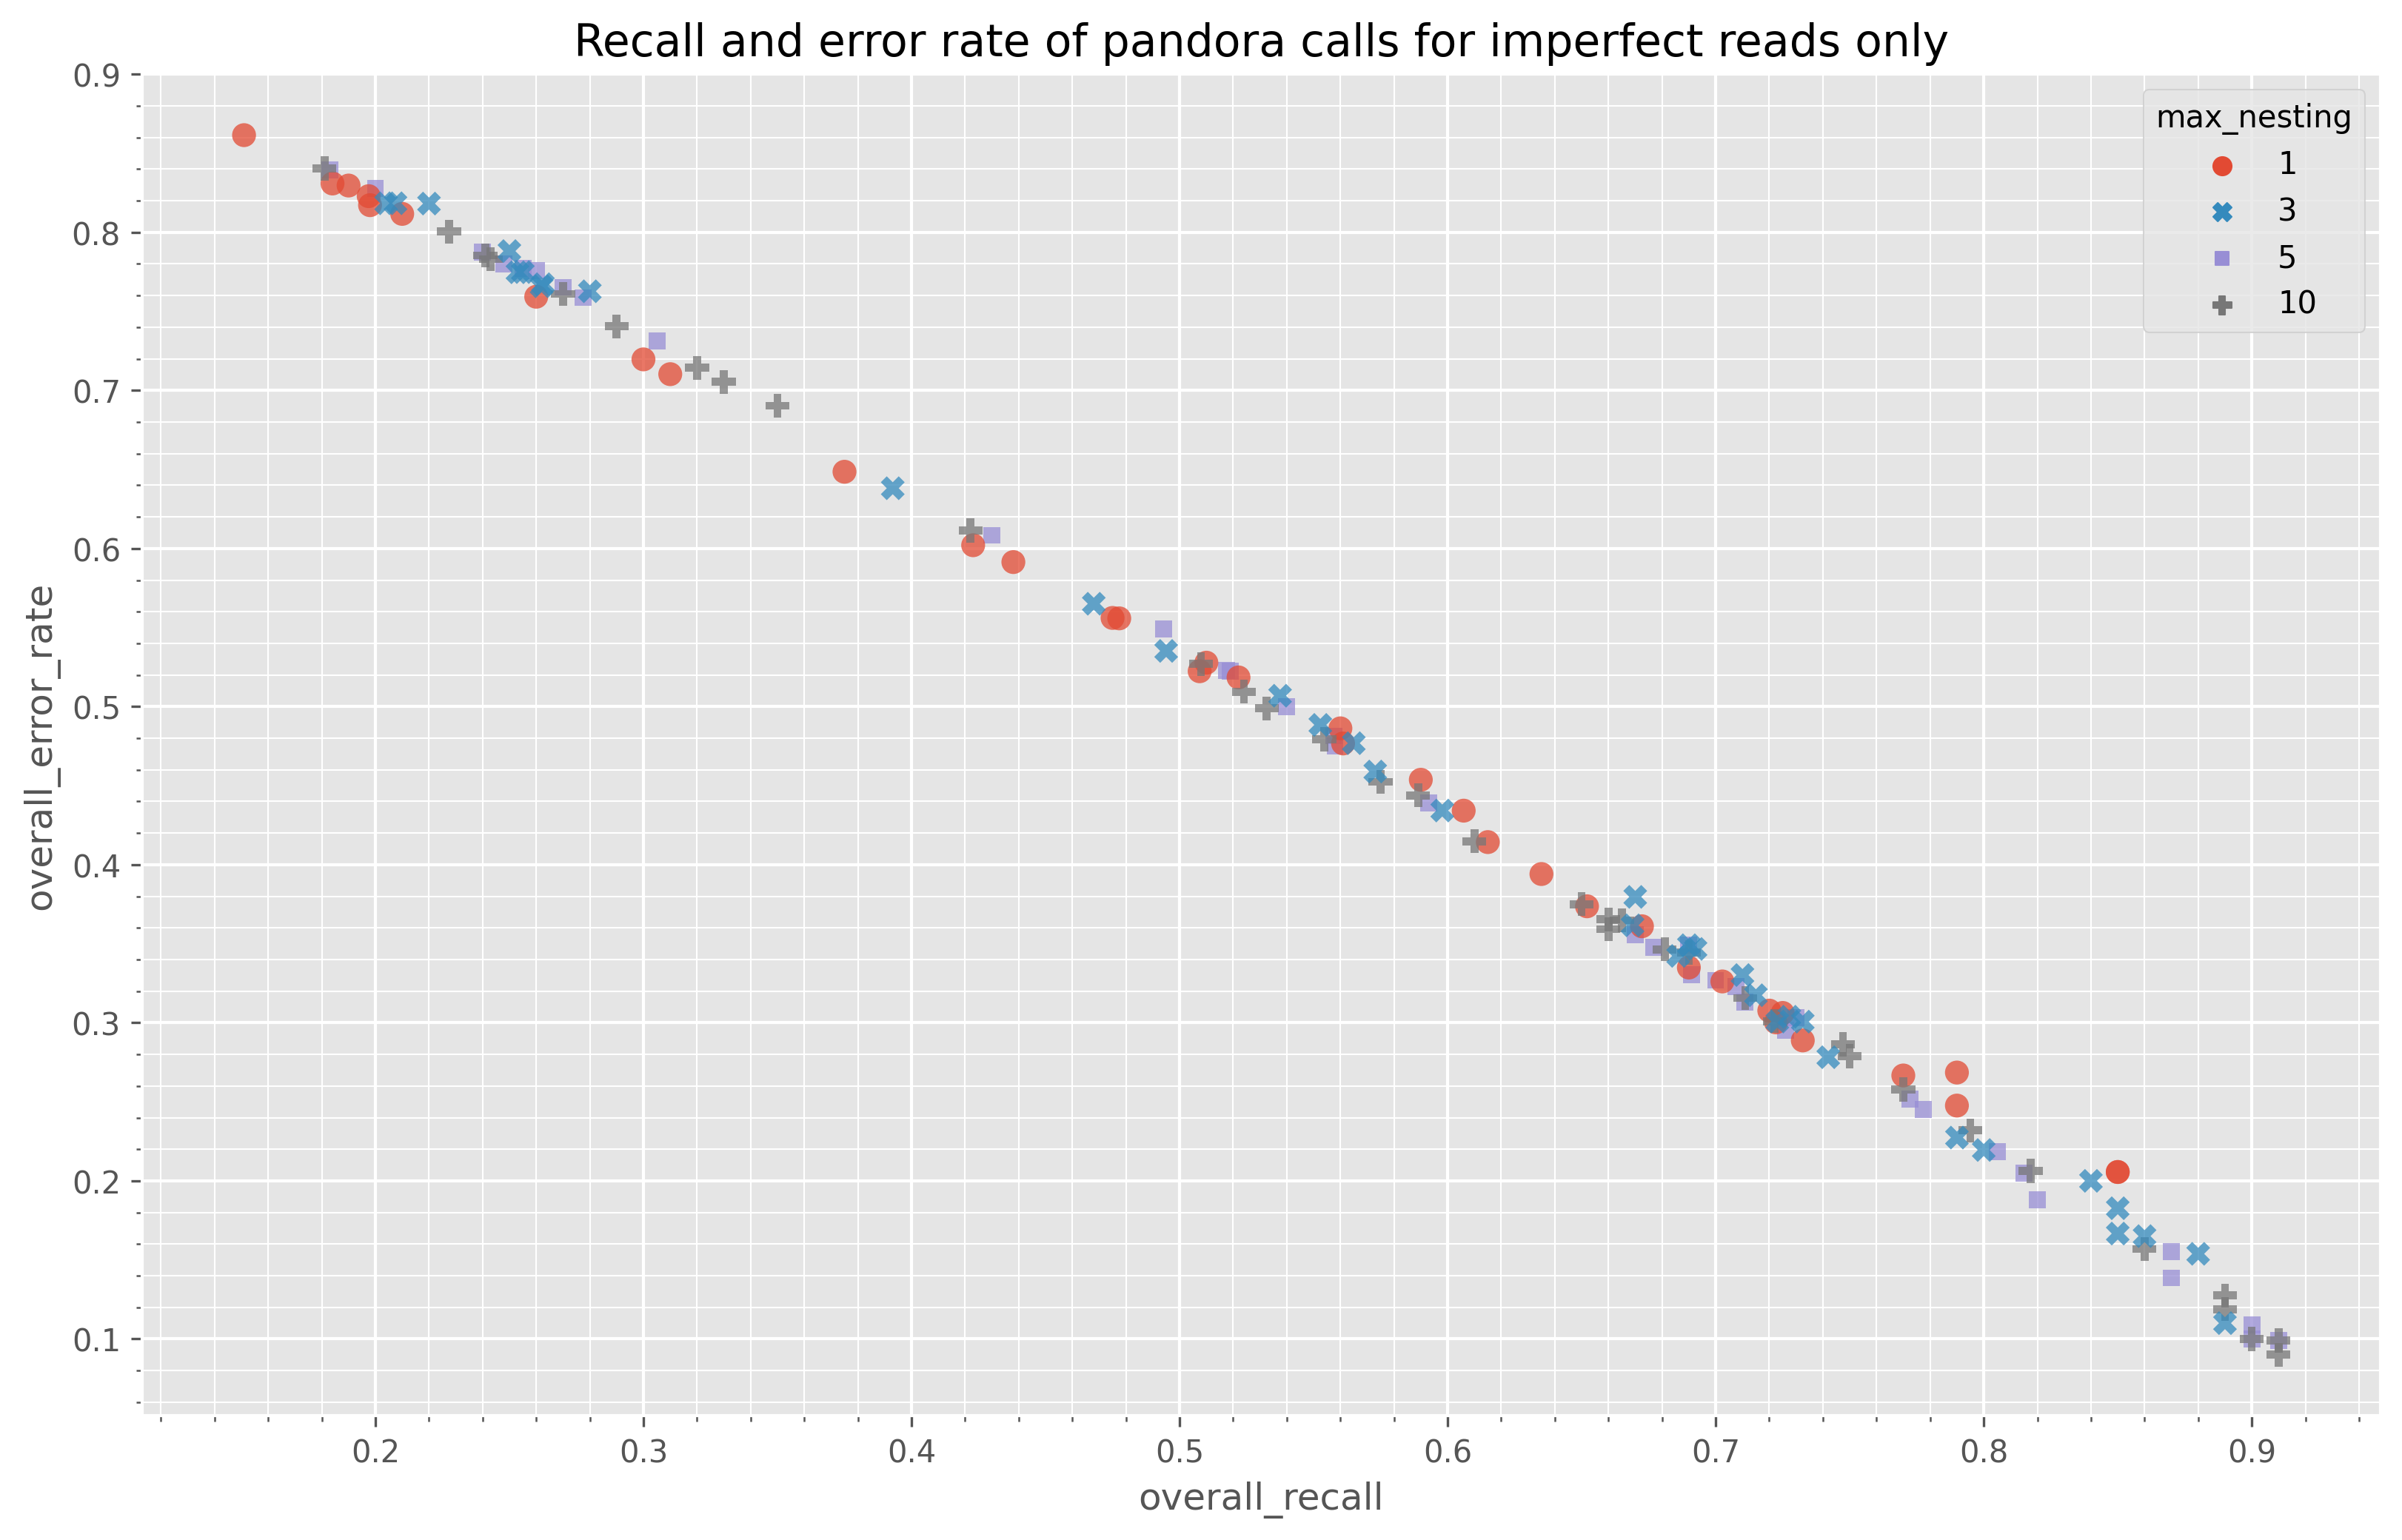

In [129]:
data = imperfect_df
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
plot = sns.scatterplot(x=x, 
                       y=y, 
                       data=data, 
                       ax=ax, 
                       style=hue,
                       palette=pal, 
                       hue=hue, 
                       legend="full", 
                       linewidth=lw,
                       alpha=alpha,
                       s=POINT_SIZE)
_ = plot.set(title="Recall and error rate of pandora calls for imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

In [130]:
data.groupby([hue])[[x, y]].describe().T

max_nesting                      1          3          5          10
overall_recall     count  36.000000  36.000000  36.000000  36.000000
                   mean    0.526736   0.580375   0.588611   0.595722
                   std     0.213573   0.228677   0.232482   0.225167
                   min     0.151000   0.204000   0.183000   0.181000
                   25%     0.358750   0.364750   0.398750   0.404000
                   50%     0.560500   0.669500   0.673500   0.655000
                   75%     0.706875   0.734875   0.773750   0.755000
                   max     0.850000   0.890000   0.910000   0.910000
overall_error_rate count  36.000000  36.000000  36.000000  36.000000
                   mean    0.503814   0.450768   0.438786   0.430089
                   std     0.205719   0.230900   0.238944   0.230748
                   min     0.205607   0.110000   0.099010   0.090000
                   25%     0.321527   0.295090   0.250148   0.273592
                   50%     0.481459   0.370635   0.352413   0.370192
                   75%     0.663981   0.669269   0.639104   0.631130
                   max     0.861468   0.818381   0.839614   0.840388

These results are quite interesting in the fact that the perfect reads has a different relationship to the imperfect ones.  
In the perfect reads we see the different levels clustering together (which is actually based on the number of SNPs - see below). We do see that nesting levels of 3 and 5 give the lowest error rate and highest recall, on average.  

We do see the same overall result with the imperfect reads, however we do not see the same clustering based on the number of SNPs per gene (not shown). As with the precision-recall relationship, coverage is the parameter that is responsible for separating the groups. Within each coverage group though we still see maximum nesting level of 3 or 5 having the lower error rate and higher recall.  

As with precision-recall, a default value of 5 for maximum nesting seems the most appropriate.

## Effect of number of SNPs

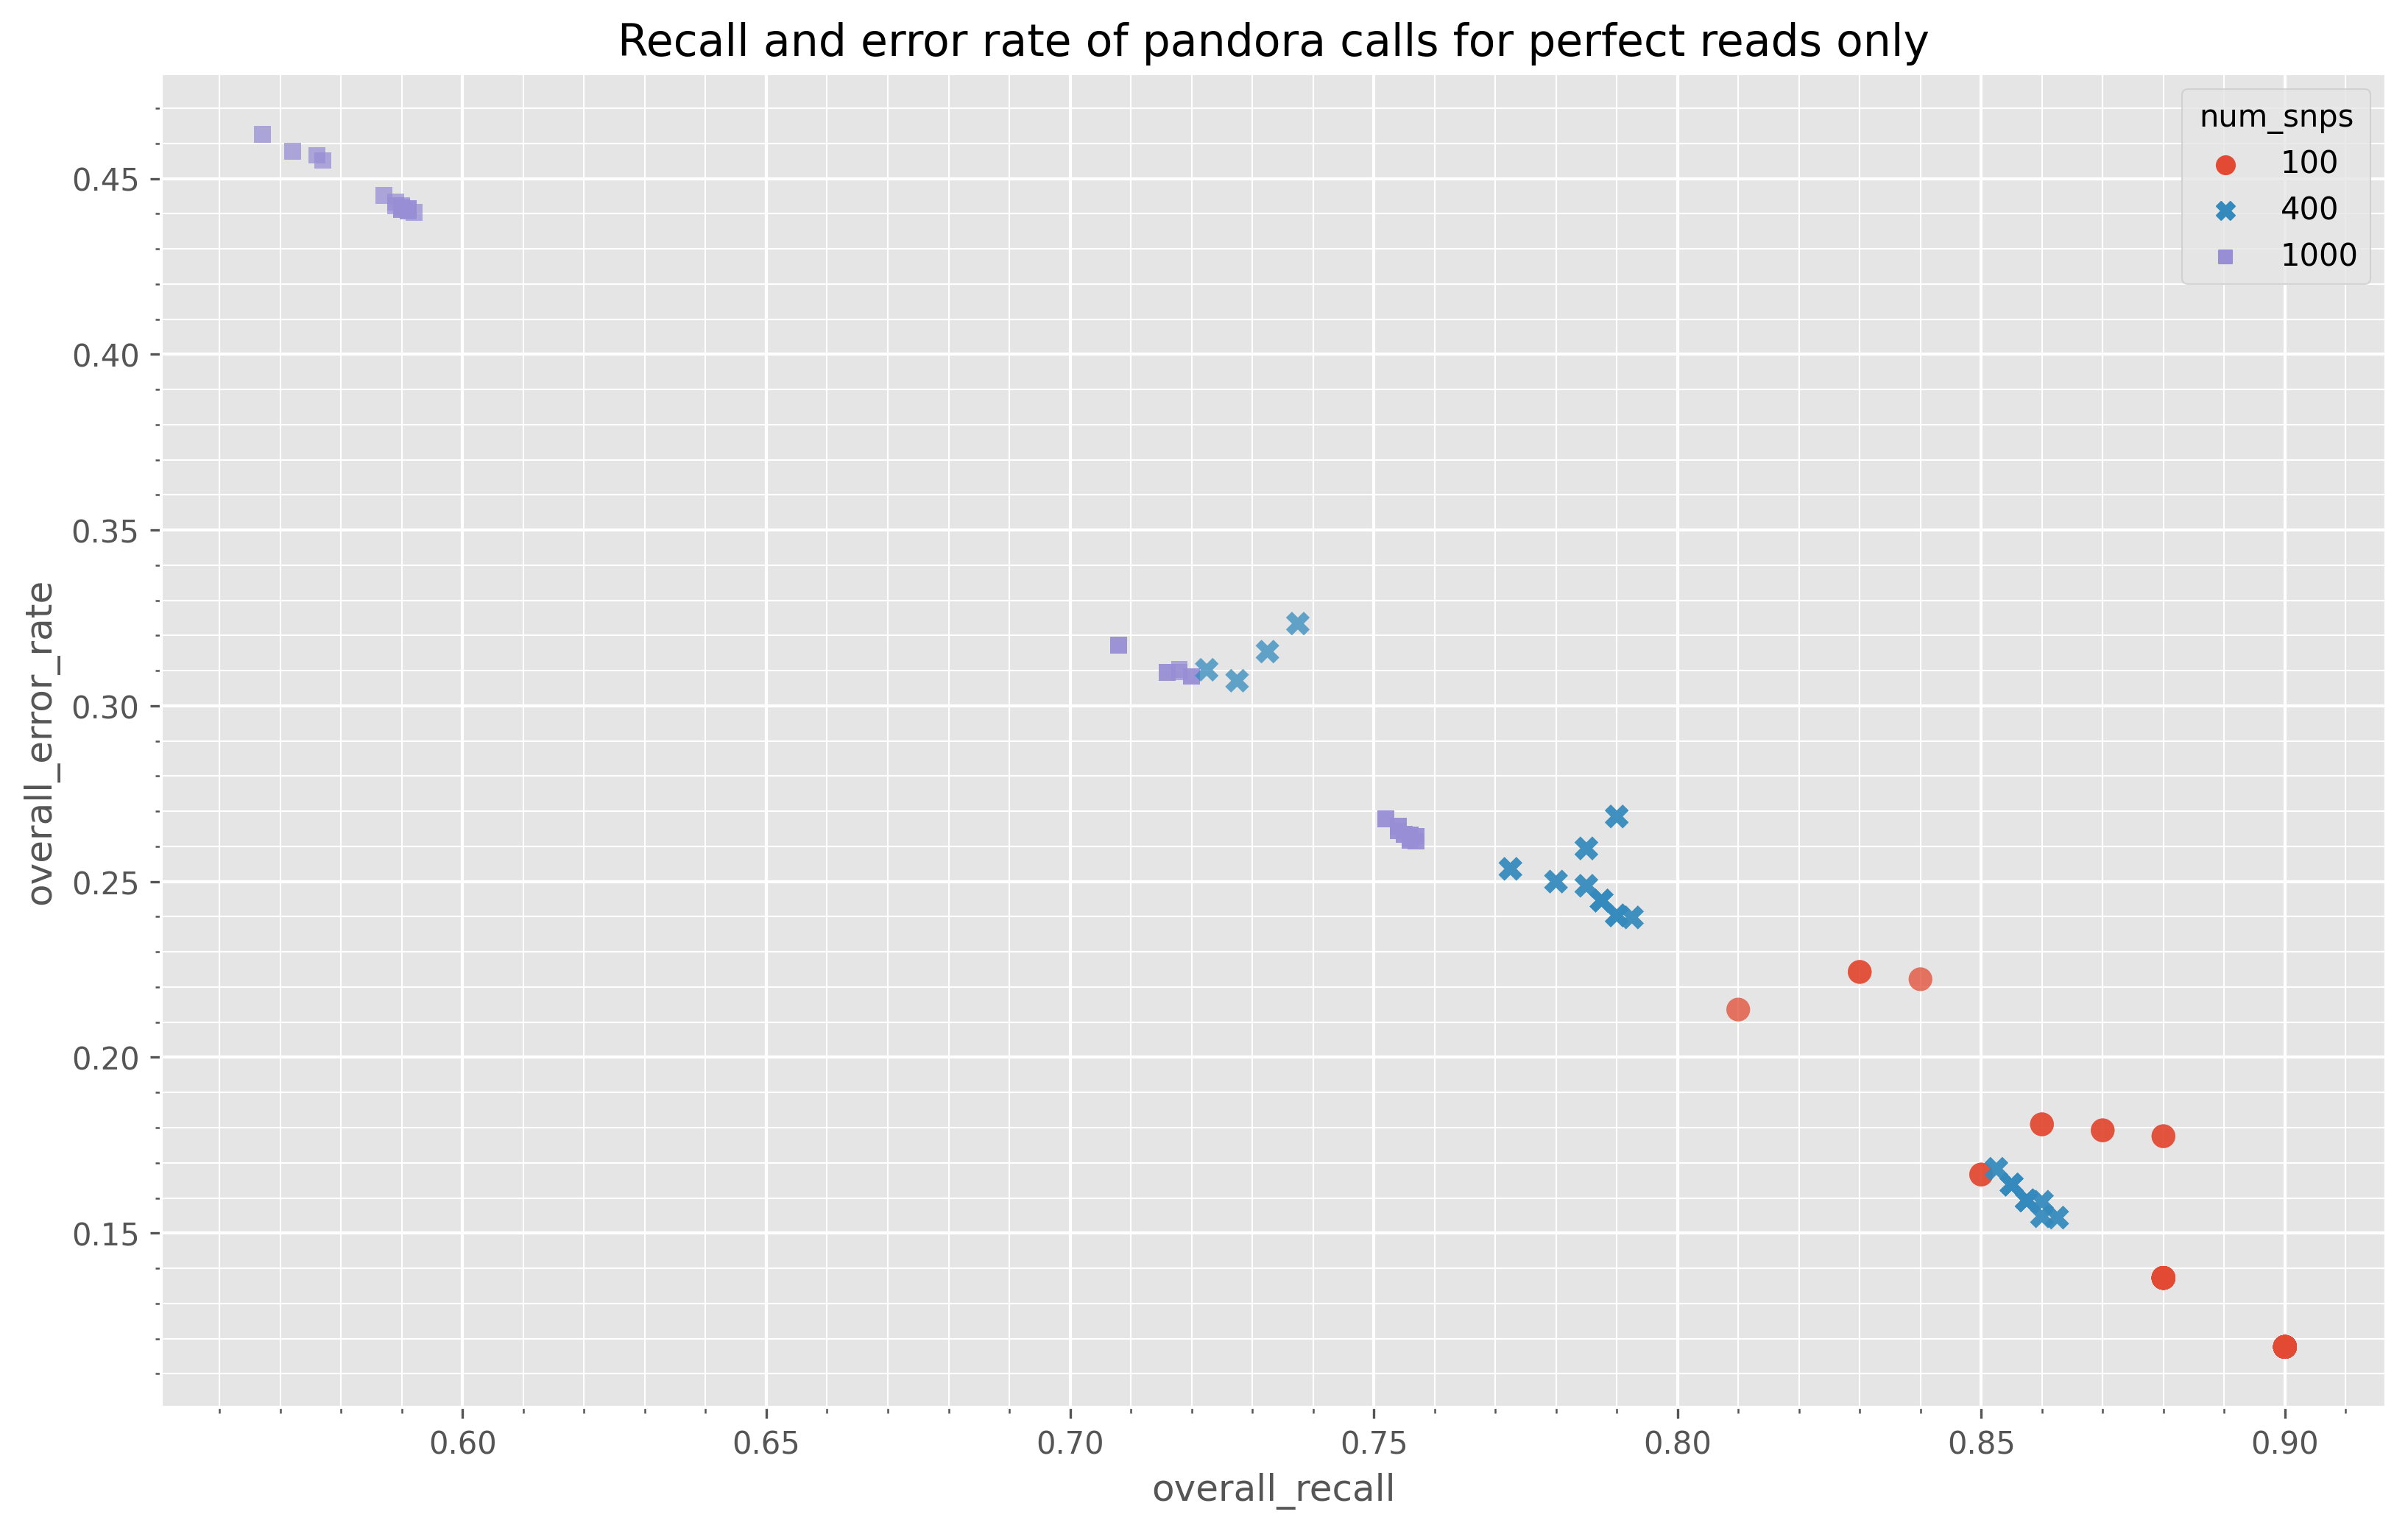

In [133]:
hue = "num_snps"
data = perfect_df
pal = CMAP[:len(set(data[hue]))]
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
plot = sns.scatterplot(x=x, 
                       y=y, 
                       data=data, 
                       ax=ax, 
                       style=hue,
                       palette=pal, 
                       hue=hue, 
                       legend="full", 
                       linewidth=lw,
                       alpha=alpha,
                       s=POINT_SIZE)
_ = plot.set(title="Recall and error rate of pandora calls for perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

In [134]:
data.groupby([hue])[[x, y]].describe().T

num_snps                       100        400        1000
overall_recall     count  48.000000  48.000000  48.000000
                   mean    0.883125   0.816823   0.692229
                   std     0.022328   0.043545   0.077531
                   min     0.810000   0.722500   0.567000
                   25%     0.880000   0.786875   0.591000
                   50%     0.890000   0.822500   0.736000
                   75%     0.900000   0.857500   0.756000
                   max     0.900000   0.862500   0.757000
overall_error_rate count  48.000000  48.000000  48.000000
                   mean    0.140914   0.210388   0.332229
                   std     0.032325   0.053461   0.083143
                   min     0.117647   0.154412   0.261463
                   25%     0.117647   0.159314   0.263094
                   50%     0.127451   0.204050   0.288064
                   75%     0.144608   0.249103   0.441288
                   max     0.224299   0.323394   0.462559

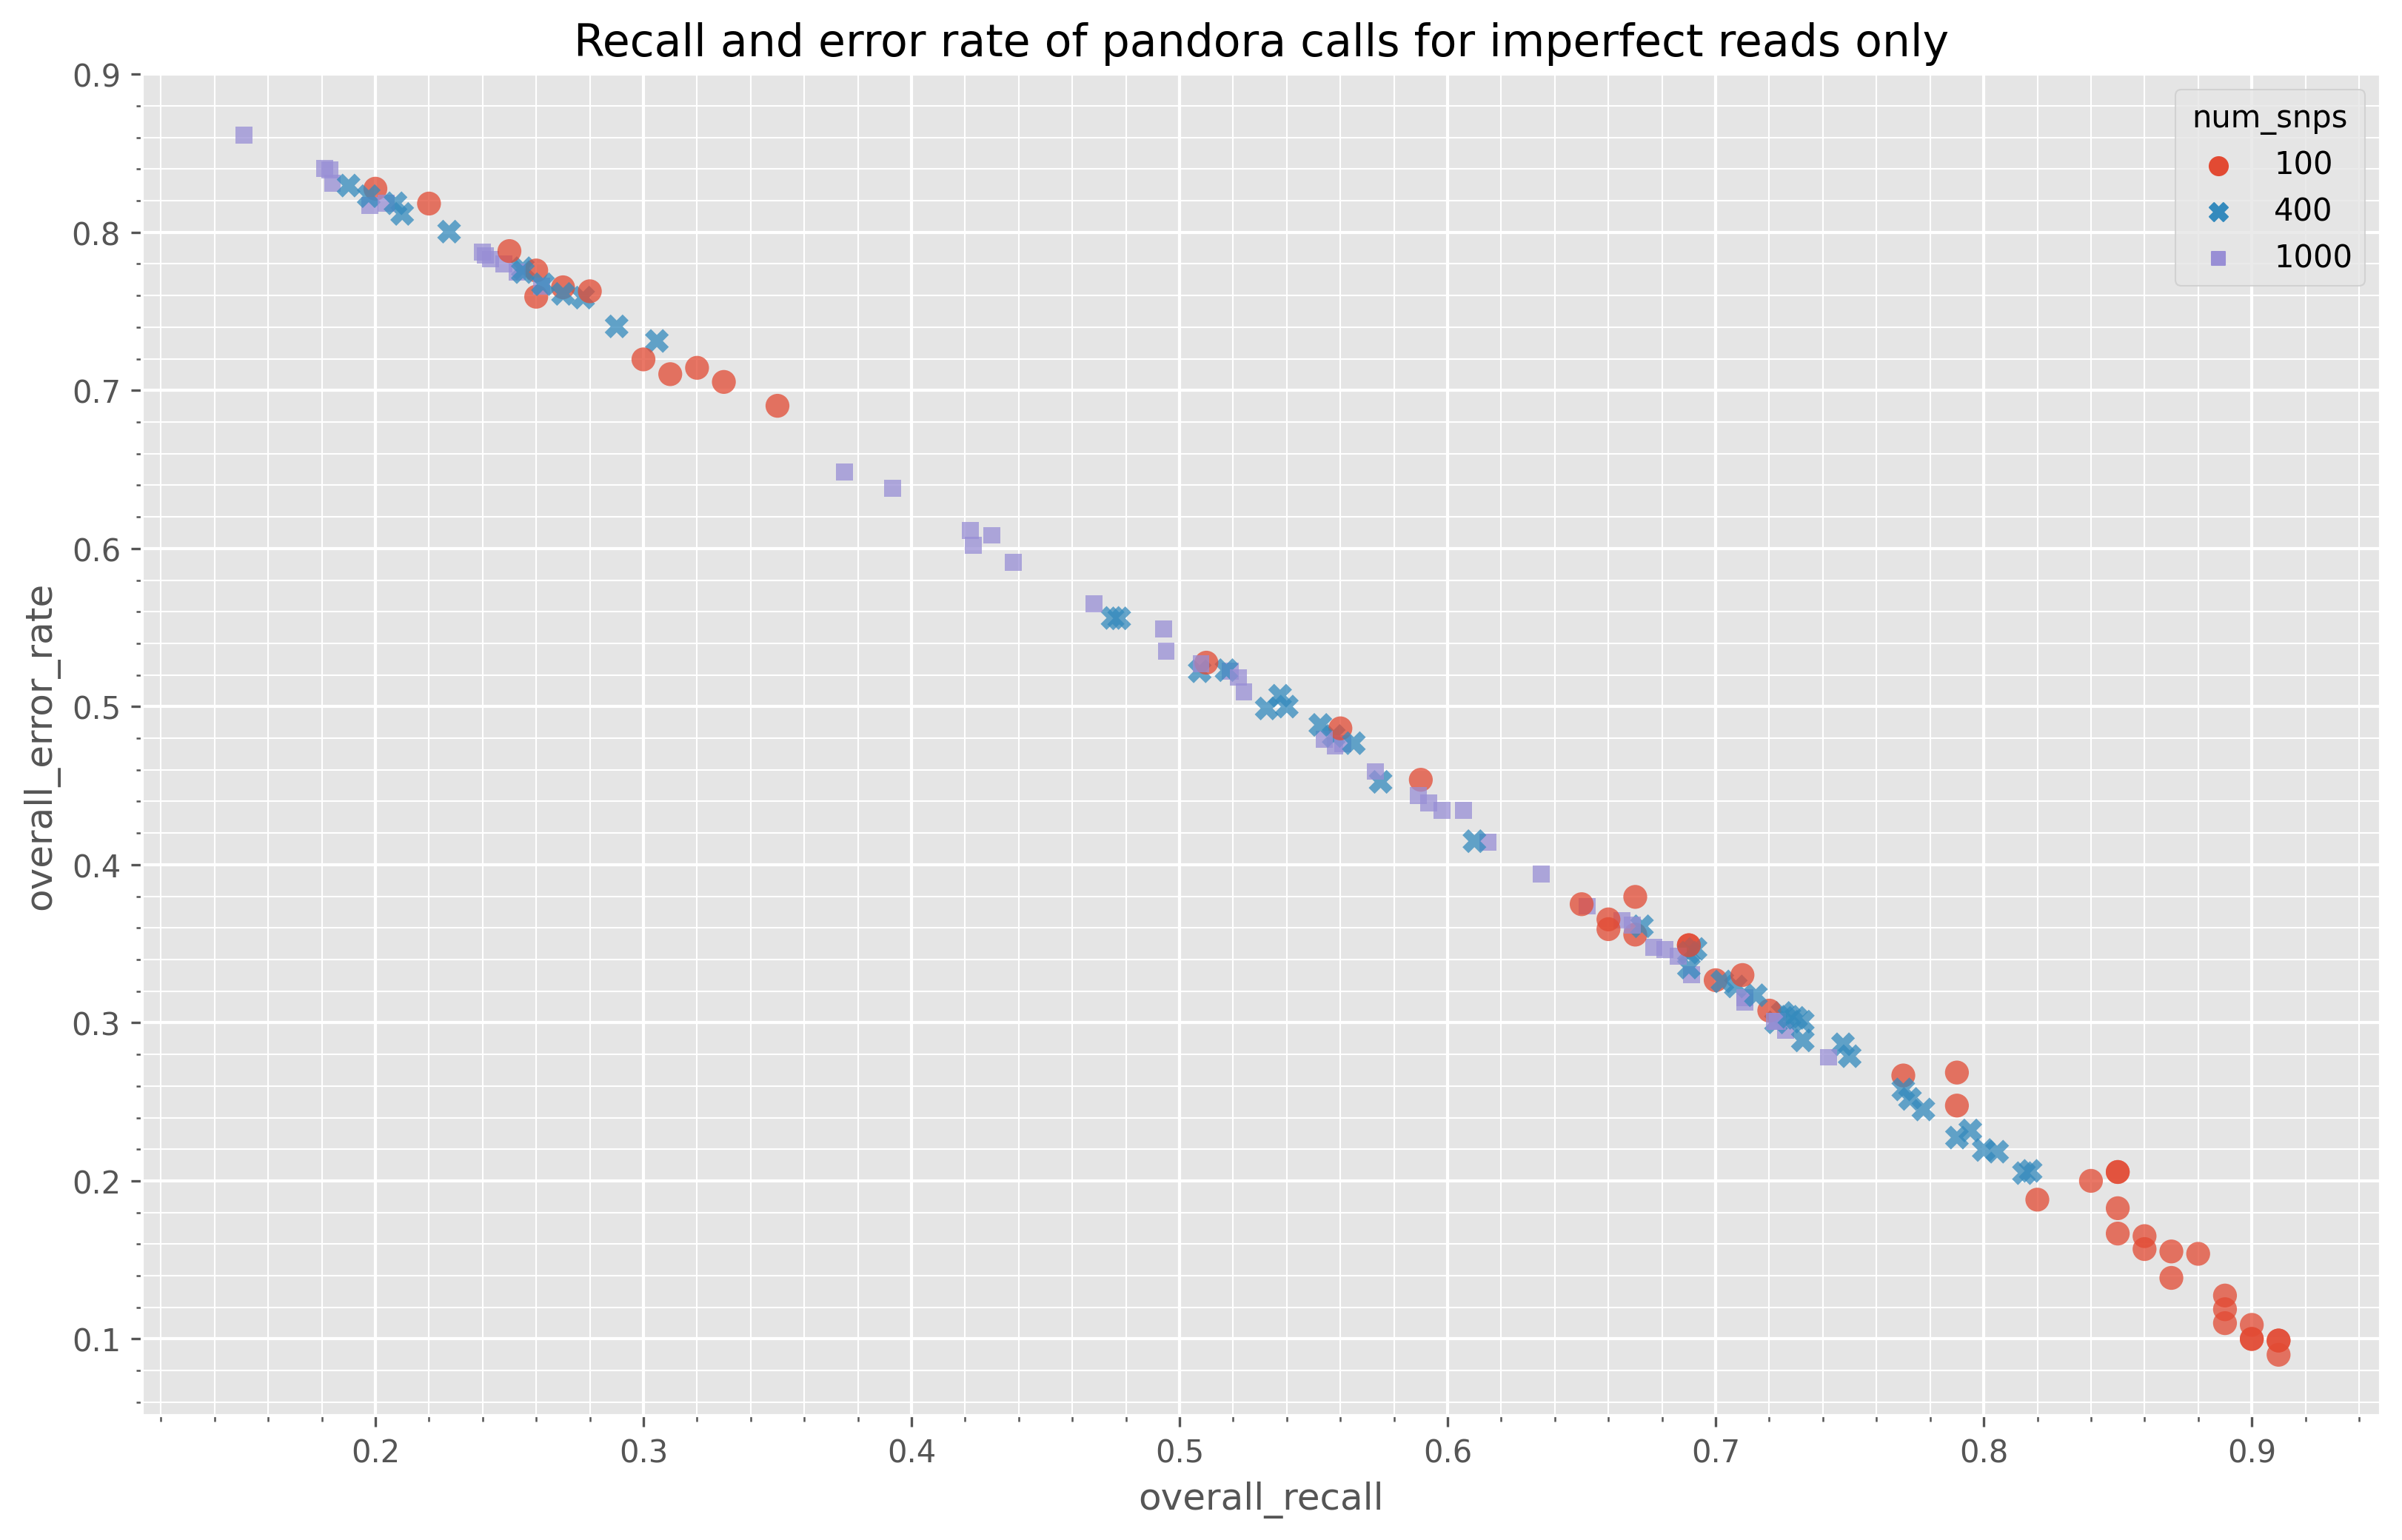

In [135]:
data = imperfect_df

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
plot = sns.scatterplot(x=x, 
                       y=y, 
                       data=data, 
                       ax=ax, 
                       style=hue,
                       palette=pal, 
                       hue=hue, 
                       legend="full", 
                       linewidth=lw,
                       alpha=alpha,
                       s=POINT_SIZE)
_ = plot.set(title="Recall and error rate of pandora calls for imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

In [136]:
data.groupby([hue])[[x, y]].describe().T

num_snps                       100        400        1000
overall_recall     count  48.000000  48.000000  48.000000
                   mean    0.660000   0.568229   0.490354
                   std     0.243800   0.210719   0.186027
                   min     0.200000   0.190000   0.151000
                   25%     0.470000   0.432500   0.346750
                   50%     0.715000   0.641250   0.523000
                   75%     0.862500   0.732500   0.655250
                   max     0.910000   0.817500   0.742000
overall_error_rate count  48.000000  48.000000  48.000000
                   mean    0.367850   0.461577   0.538165
                   std     0.249602   0.211593   0.184292
                   min     0.090000   0.204878   0.278210
                   25%     0.156482   0.297390   0.371472
                   50%     0.317308   0.387957   0.513907
                   75%     0.568400   0.599875   0.677876
                   max     0.827586   0.829596   0.861468

As we saw in the precision-recall plots, number of SNPs per gene has some impact on the recall - the more SNPs we have per gene, the lower the recall.  

For perfect reads we certainly see a lower error rate with lower SNPs per gene.  
Imperfect reads have a similar relationship, but it is not as pronounced as with the perfect reads.

## Effect of *de novo* k-mer size

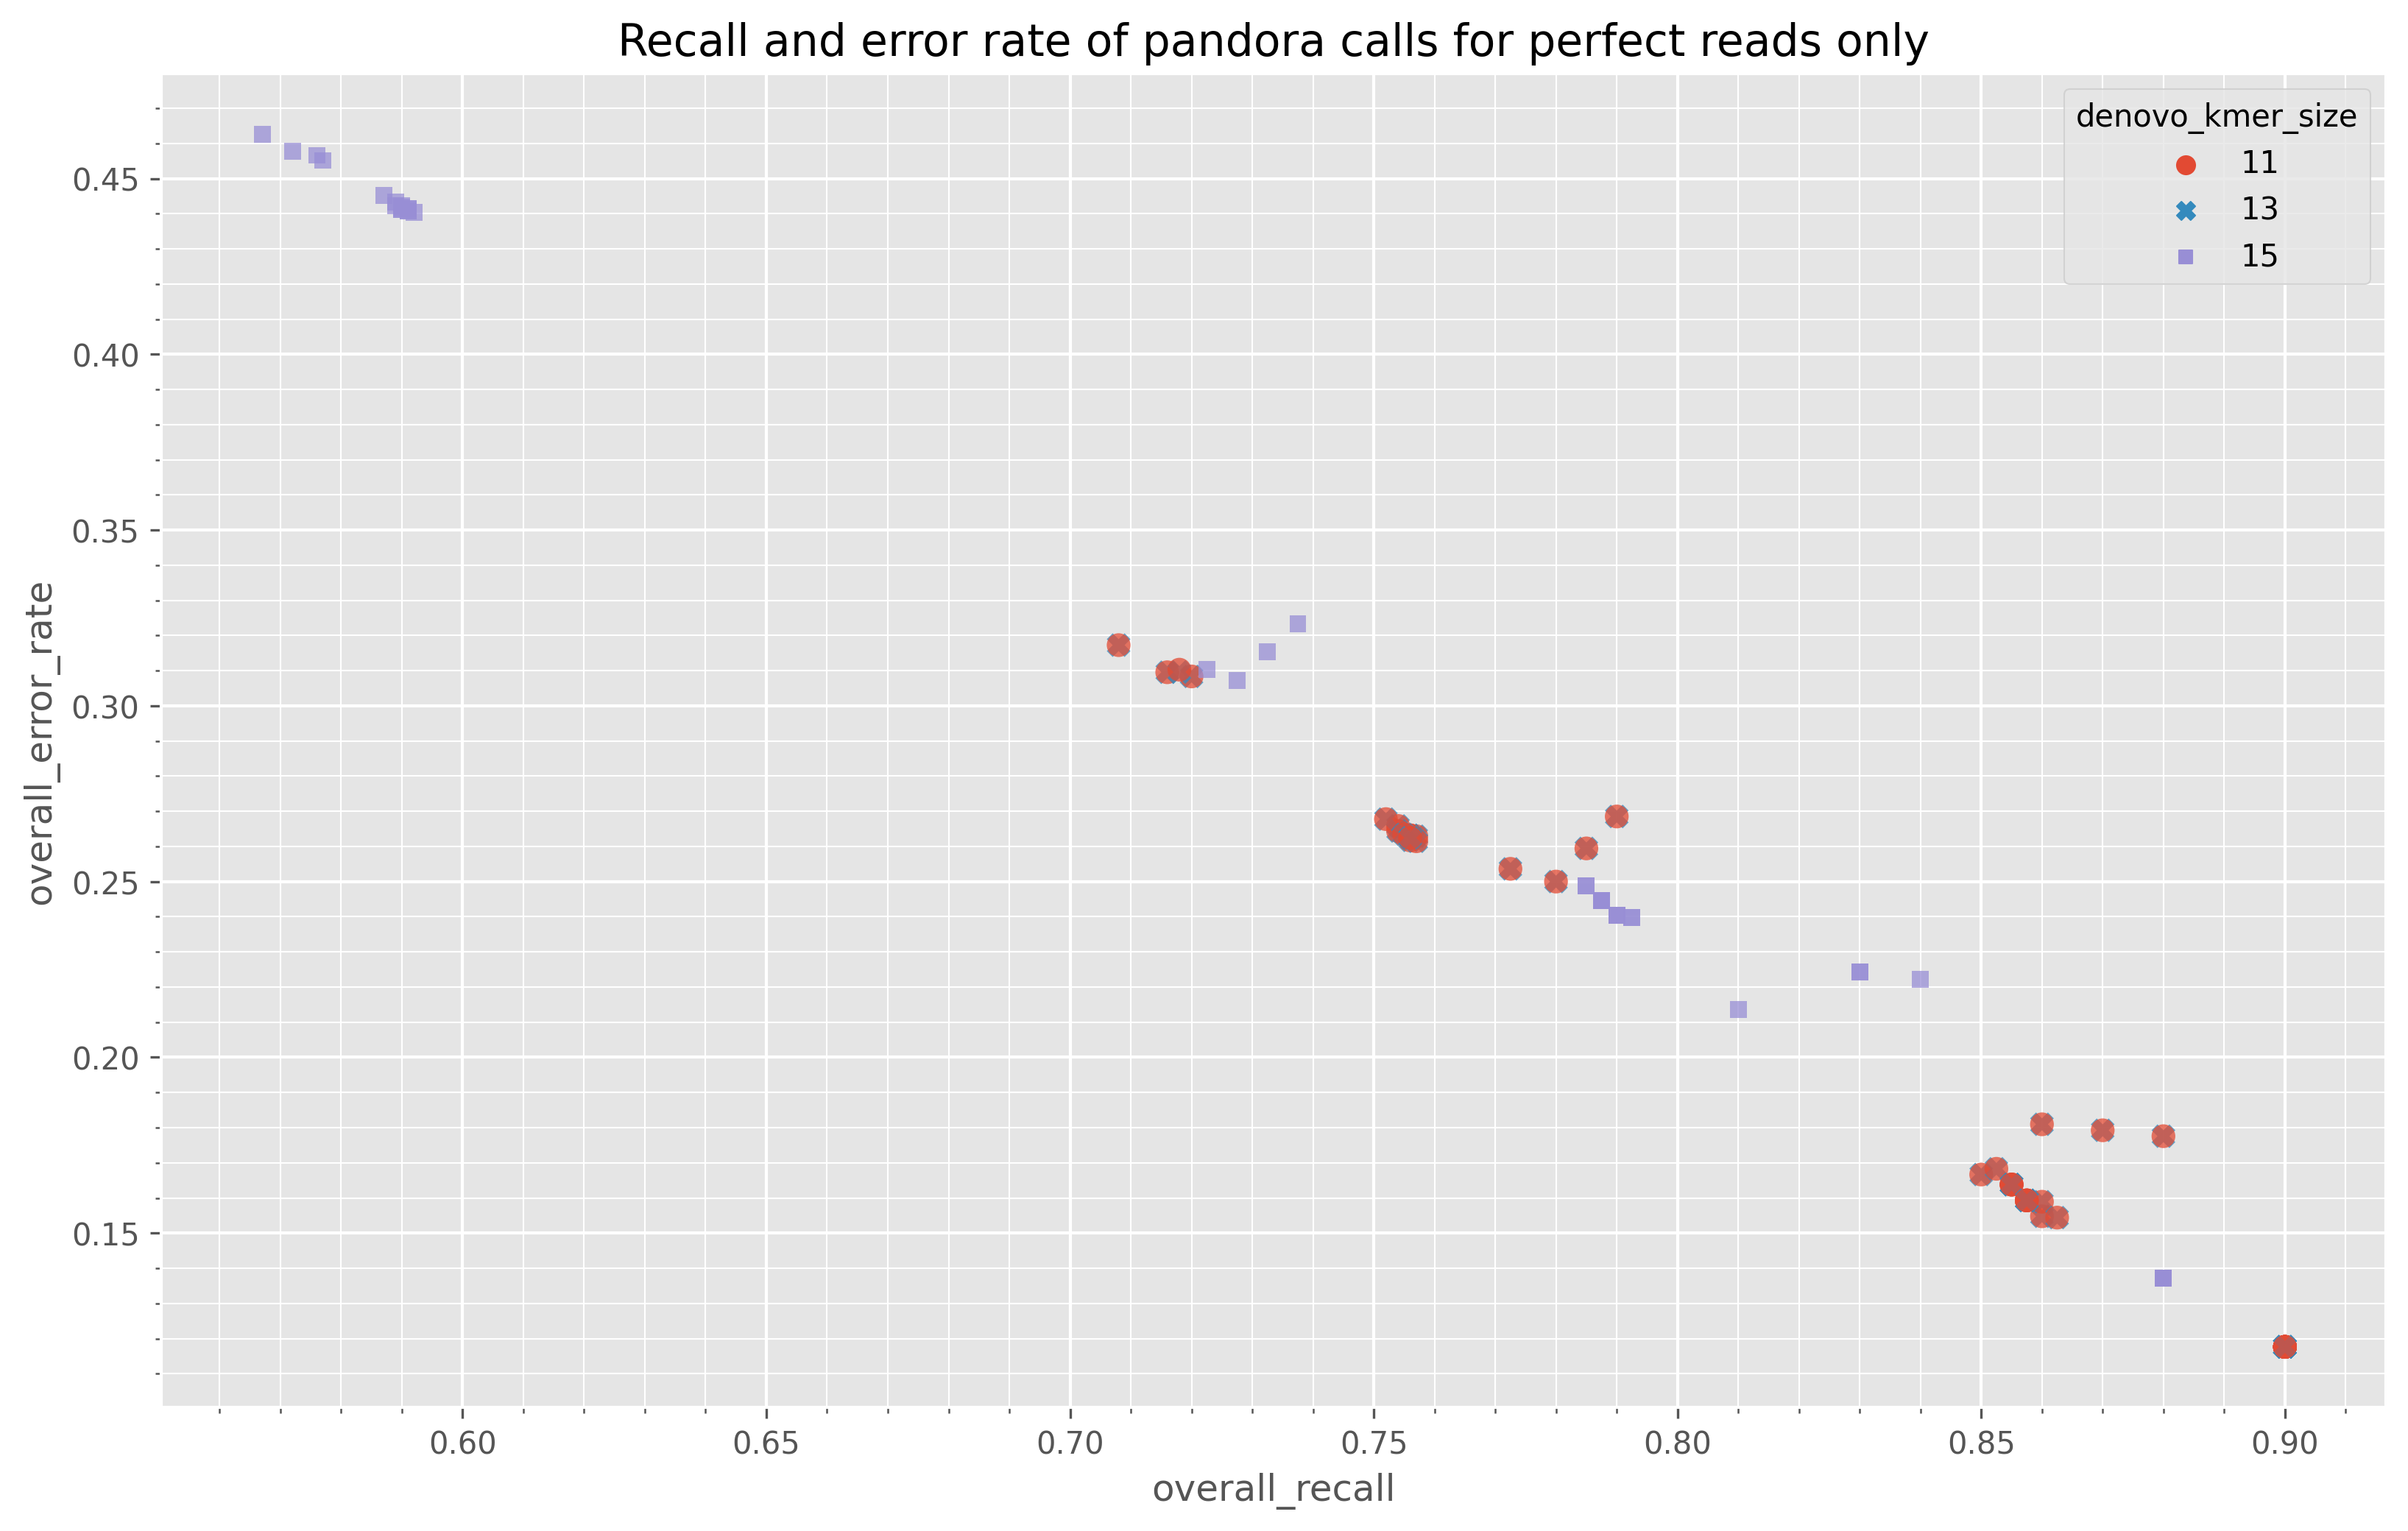

In [137]:
hue = "denovo_kmer_size"
data = perfect_df
pal = CMAP[:len(set(data[hue]))]
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
plot = sns.scatterplot(x=x, 
                       y=y, 
                       data=data, 
                       ax=ax, 
                       style=hue,
                       palette=pal, 
                       hue=hue, 
                       legend="full", 
                       linewidth=lw,
                       alpha=alpha,
                       s=POINT_SIZE)
_ = plot.set(title="Recall and error rate of pandora calls for perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

In [138]:
data.groupby([hue])[[x, y]].describe().T

denovo_kmer_size                 11         13         15
overall_recall     count  48.000000  48.000000  48.000000
                   mean    0.824990   0.824990   0.742198
                   std     0.065333   0.065333   0.119953
                   min     0.708000   0.708000   0.567000
                   25%     0.756000   0.756000   0.591000
                   50%     0.855000   0.855000   0.787500
                   75%     0.885000   0.885000   0.850000
                   max     0.900000   0.900000   0.880000
overall_error_rate count  48.000000  48.000000  48.000000
                   mean    0.197568   0.197554   0.288409
                   std     0.067438   0.067414   0.123535
                   min     0.117647   0.117647   0.137255
                   25%     0.145221   0.145221   0.194508
                   50%     0.167480   0.167480   0.244604
                   75%     0.262555   0.262555   0.441288
                   max     0.317261   0.317261   0.462559

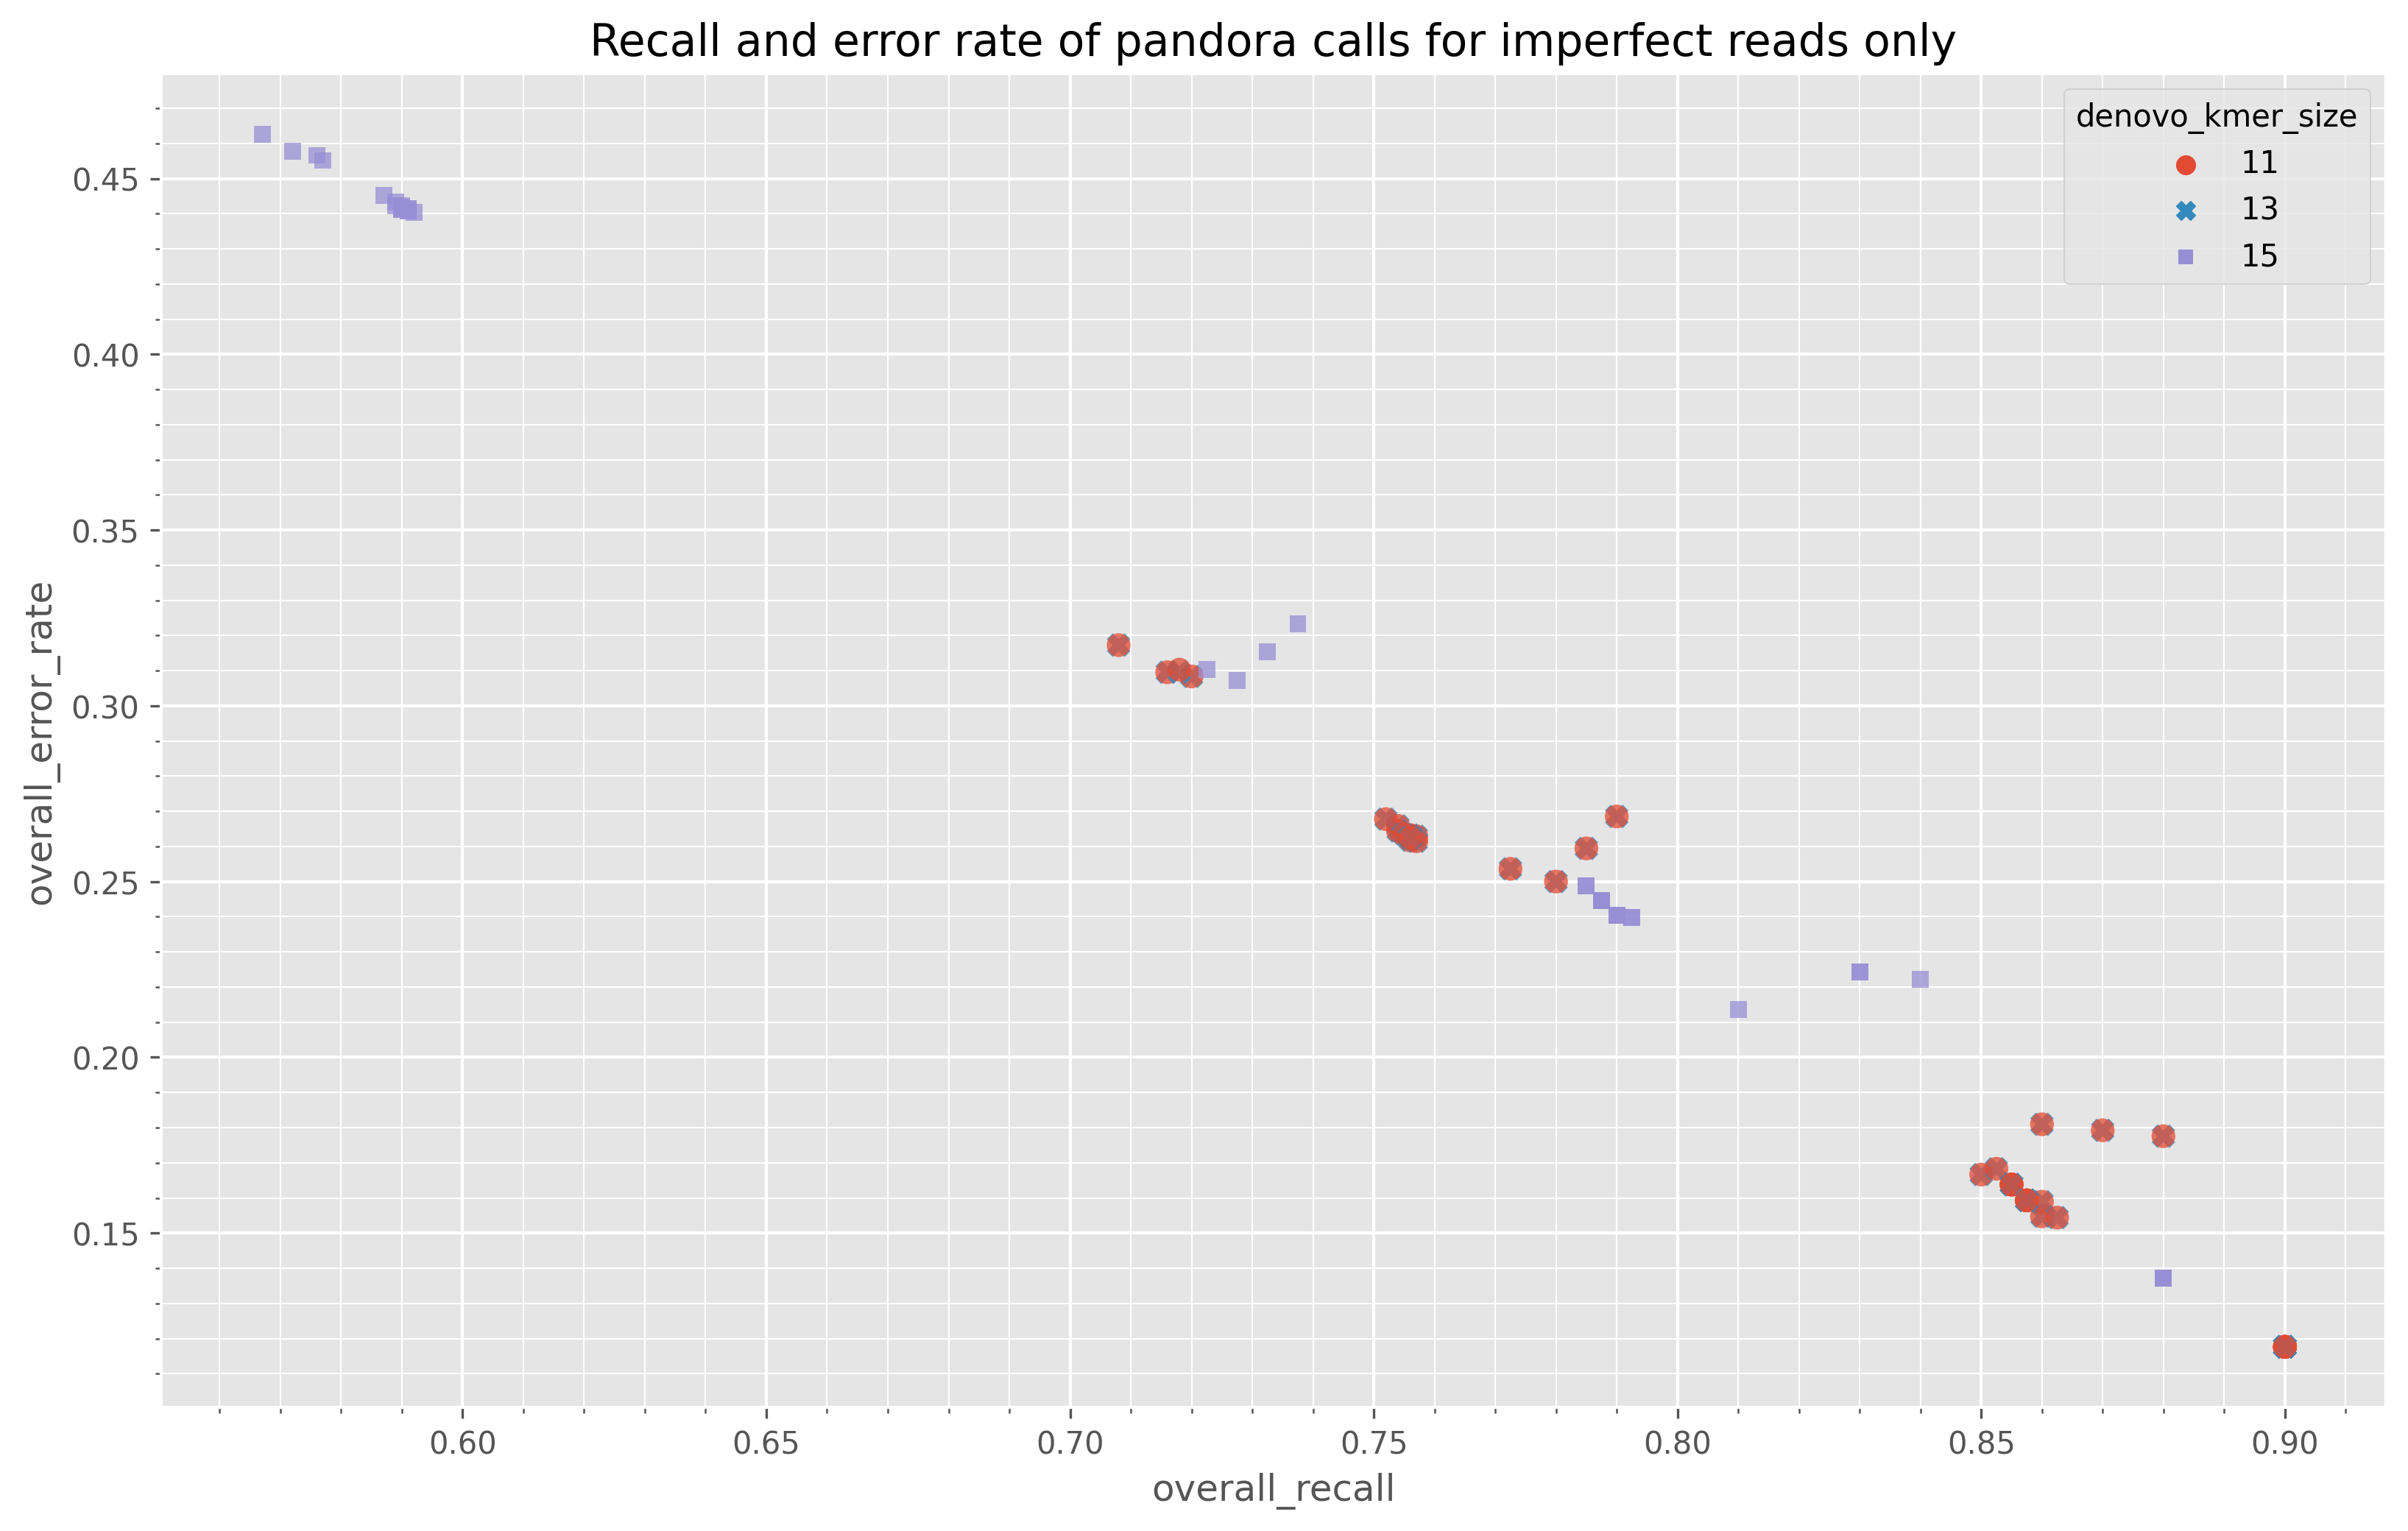

In [139]:
data = perfect_df
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
plot = sns.scatterplot(x=x, 
                       y=y, 
                       data=data, 
                       ax=ax, 
                       style=hue,
                       palette=pal, 
                       hue=hue, 
                       legend="full", 
                       linewidth=lw,
                       alpha=alpha,
                       s=POINT_SIZE)
_ = plot.set(title="Recall and error rate of pandora calls for imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

As with the precision-recall relationship *de novo* k-mer size has a fairly small effect of the recall-error rate relationship. When breaking down in to coverage bands though, we again see that a value of 11 or 13 is likely the best.

## Compare no-*de novo* with *de novo*

In [140]:
results_no_denovo = [Result.from_json(p) for p in Path("../analysis/").rglob("*no_denovo/results.json")]

In [141]:
results_no_denovo_dicts = [r.as_dict() for r in results_no_denovo]
results_no_denovo_df = pd.DataFrame(results_no_denovo_dicts)

In [142]:
results_no_denovo_df

denovo_precision  denovo_recall  overall_recall  overall_precision  \
0                 0.0            0.0           0.003           0.016129   
1                 0.0            0.0           0.003           0.016129   
2                 0.0            0.0           0.003           0.016129   
3                 0.0            0.0           0.004           0.017167   
4                 0.0            0.0           0.004           0.017167   
..                ...            ...             ...                ...   
283               0.0            0.0           0.020           0.068966   
284               0.0            0.0           0.020           0.068966   
285               0.0            0.0           0.020           0.068966   
286               0.0            0.0           0.020           0.068966   
287               0.0            0.0           0.020           0.068966   

     overall_accuracy  overall_error_rate  denovo_kmer_size  num_snps  \
0            0.002536            0.997464                13      1000   
1            0.002536            0.997464                15      1000   
2            0.002536            0.997464                11      1000   
3            0.003255            0.996745                13      1000   
4            0.003255            0.996745                15      1000   
..                ...                 ...               ...       ...   
283          0.015748            0.984252                15       100   
284          0.015748            0.984252                11       100   
285          0.015748            0.984252                13       100   
286          0.015748            0.984252                15       100   
287          0.015748            0.984252                11       100   

     coverage  max_nesting read_quality  conf_threshold  
0          15            5    imperfect               0  
1          15            5    imperfect               0  
2          15            5    imperfect               0  
3          30            5    imperfect               0  
4          30            5    imperfect               0  
..        ...          ...          ...             ...  
283        60            3      perfect               0  
284        60            3      perfect               0  
285       100            3      perfect               0  
286       100            3      perfect               0  
287       100            3      perfect               0  

[288 rows x 12 columns]

# Summary
Coverage is the factor which most impacts the precision-recall relationship. After this, the number of SNPs per gene also has some impact, but given the assumption we will be assessing bacterial with a 1-4 variants per gene this should not effect us.  

For further analysis, parameters will be set as such:  
- Number of SNPs per gene: 4
- Maximum nesting level: 5
- De novo kmer size: 11
- Coverage: ??

In [201]:
max_conf = 500
max_nesting = 5
denovo_kmer_size = 13
read_quality = "imperfect"
num_snps = 400
results_dicts_conf = []
for conf_threshold in range(0, max_conf, 10):
    for r in results:
        if (r.denovo_kmer_size == denovo_kmer_size and 
            r.max_nesting == max_nesting and 
            r.read_quality == read_quality and 
            r.num_snps == num_snps):
            results_dicts_conf.append(r.as_dict(conf_threshold=conf_threshold))
df_with_denovo = pd.DataFrame(results_dicts_conf)
df_with_denovo["method"] = "with_denovo"
#df = conf_df.query("denovo_kmer_size==@denovo_kmer_size & num_snps==@num_snps & max_nesting==@max_nesting & read_quality==@read_quality")

In [202]:
results_no_denovo_dicts_conf = []
for conf_threshold in range(0, max_conf, 10):
    for r in results_no_denovo:
        if (r.denovo_kmer_size == denovo_kmer_size and 
                r.max_nesting == max_nesting and 
                r.read_quality == read_quality and 
                r.num_snps == num_snps):
            results_no_denovo_dicts_conf.append(r.as_dict(conf_threshold=conf_threshold))
df_no_denovo = pd.DataFrame(results_no_denovo_dicts_conf)
df_no_denovo["method"] = "no_denovo"

In [203]:
df = pd.concat([df_with_denovo, df_no_denovo])
df = df.reset_index()
df.query

index  denovo_precision  denovo_recall  overall_recall  \
0        0               0.0            0.0          0.3050   
1        1               0.0            0.0          0.5575   
2        2               0.0            0.0          0.7775   
3        3               0.0            0.0          0.8150   
4        4               0.0            0.0          0.2800   
..     ...               ...            ...             ...   
395    195               0.0            0.0          0.0000   
396    196               0.0            0.0          0.0000   
397    197               0.0            0.0          0.0000   
398    198               0.0            0.0          0.0000   
399    199               0.0            0.0          0.0000   

     overall_precision  overall_accuracy  overall_error_rate  \
0             0.693182          0.268722            0.731278   
1             0.881423          0.518605            0.481395   
2             0.962848          0.754854            0.245146   
3             0.970238          0.795122            0.204878   
4             0.736842          0.254545            0.745455   
..                 ...               ...                 ...   
395           0.000000          0.000000            1.000000   
396           0.000000          0.000000            1.000000   
397           0.000000          0.000000            1.000000   
398           0.000000          0.000000            1.000000   
399           0.000000          0.000000            1.000000   

     denovo_kmer_size  num_snps  coverage  max_nesting read_quality  \
0                  13       400        15            5    imperfect   
1                  13       400        30            5    imperfect   
2                  13       400        60            5    imperfect   
3                  13       400       100            5    imperfect   
4                  13       400        15            5    imperfect   
..                ...       ...       ...          ...          ...   
395                13       400       100            5    imperfect   
396                13       400        15            5    imperfect   
397                13       400        30            5    imperfect   
398                13       400        60            5    imperfect   
399                13       400       100            5    imperfect   

     conf_threshold       method  
0                 0  with_denovo  
1                 0  with_denovo  
2                 0  with_denovo  
3                 0  with_denovo  
4                10  with_denovo  
..              ...          ...  
395             480    no_denovo  
396             490    no_denovo  
397             490    no_denovo  
398             490    no_denovo  
399             490    no_denovo  

[400 rows x 14 columns]

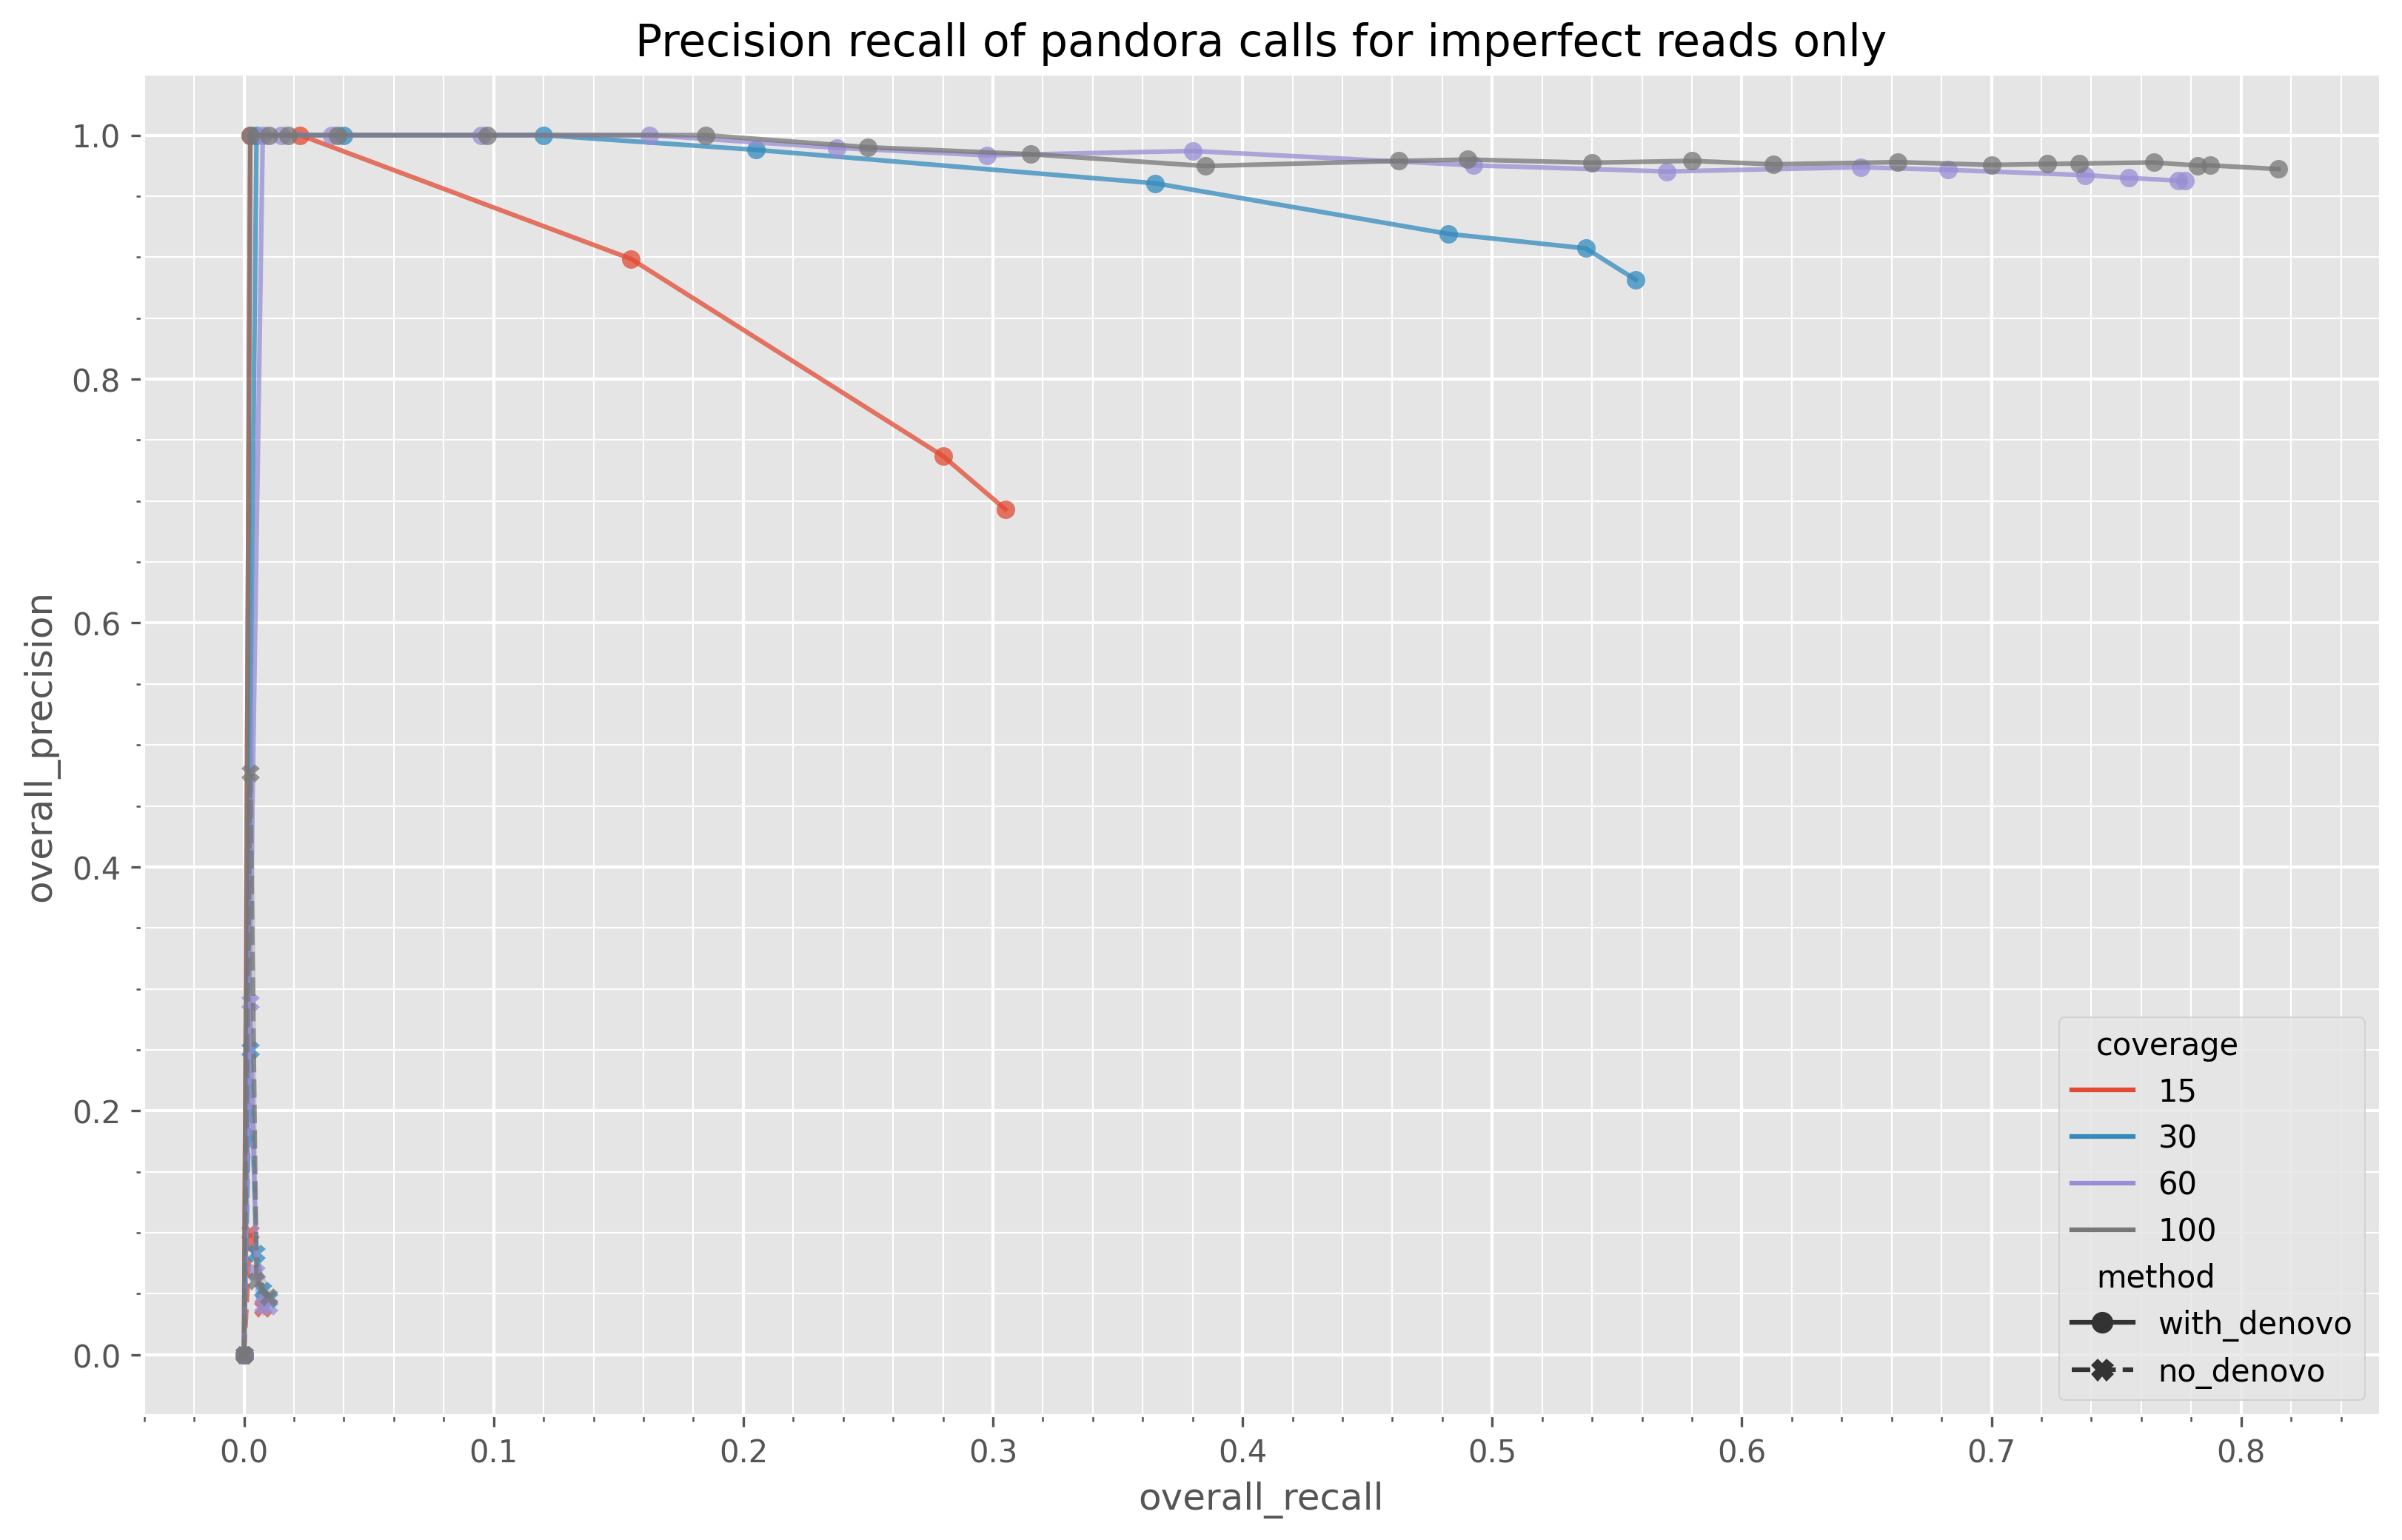

In [204]:
x="overall_recall"
y="overall_precision"
hue="coverage"
style = "method"
data = df.sort_values(["conf_threshold"])
pal = CMAP[:len(set(data[hue]))]

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
plot = sns.lineplot(x=x, 
                       y=y, 
                       data=data, 
                       ax=ax, 
                       style=style,
                       palette=pal, 
                       hue=hue, 
                    sort=False,
                       legend="full", markers=True, markeredgewidth=0, alpha=alpha)

# plot = sns.scatterplot(x=x, 
#                        y=y, 
#                        data=data, 
#                        ax=ax, 
#                        style=style,
#                        palette=pal, 
#                        hue=hue, 
# #                        legend=None, 
#                        linewidth=lw,
#                        alpha=alpha,
#                        s=POINT_SIZE/2)

_ = plot.set(title="Precision recall of pandora calls for imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

[(0.95, 1.01)]

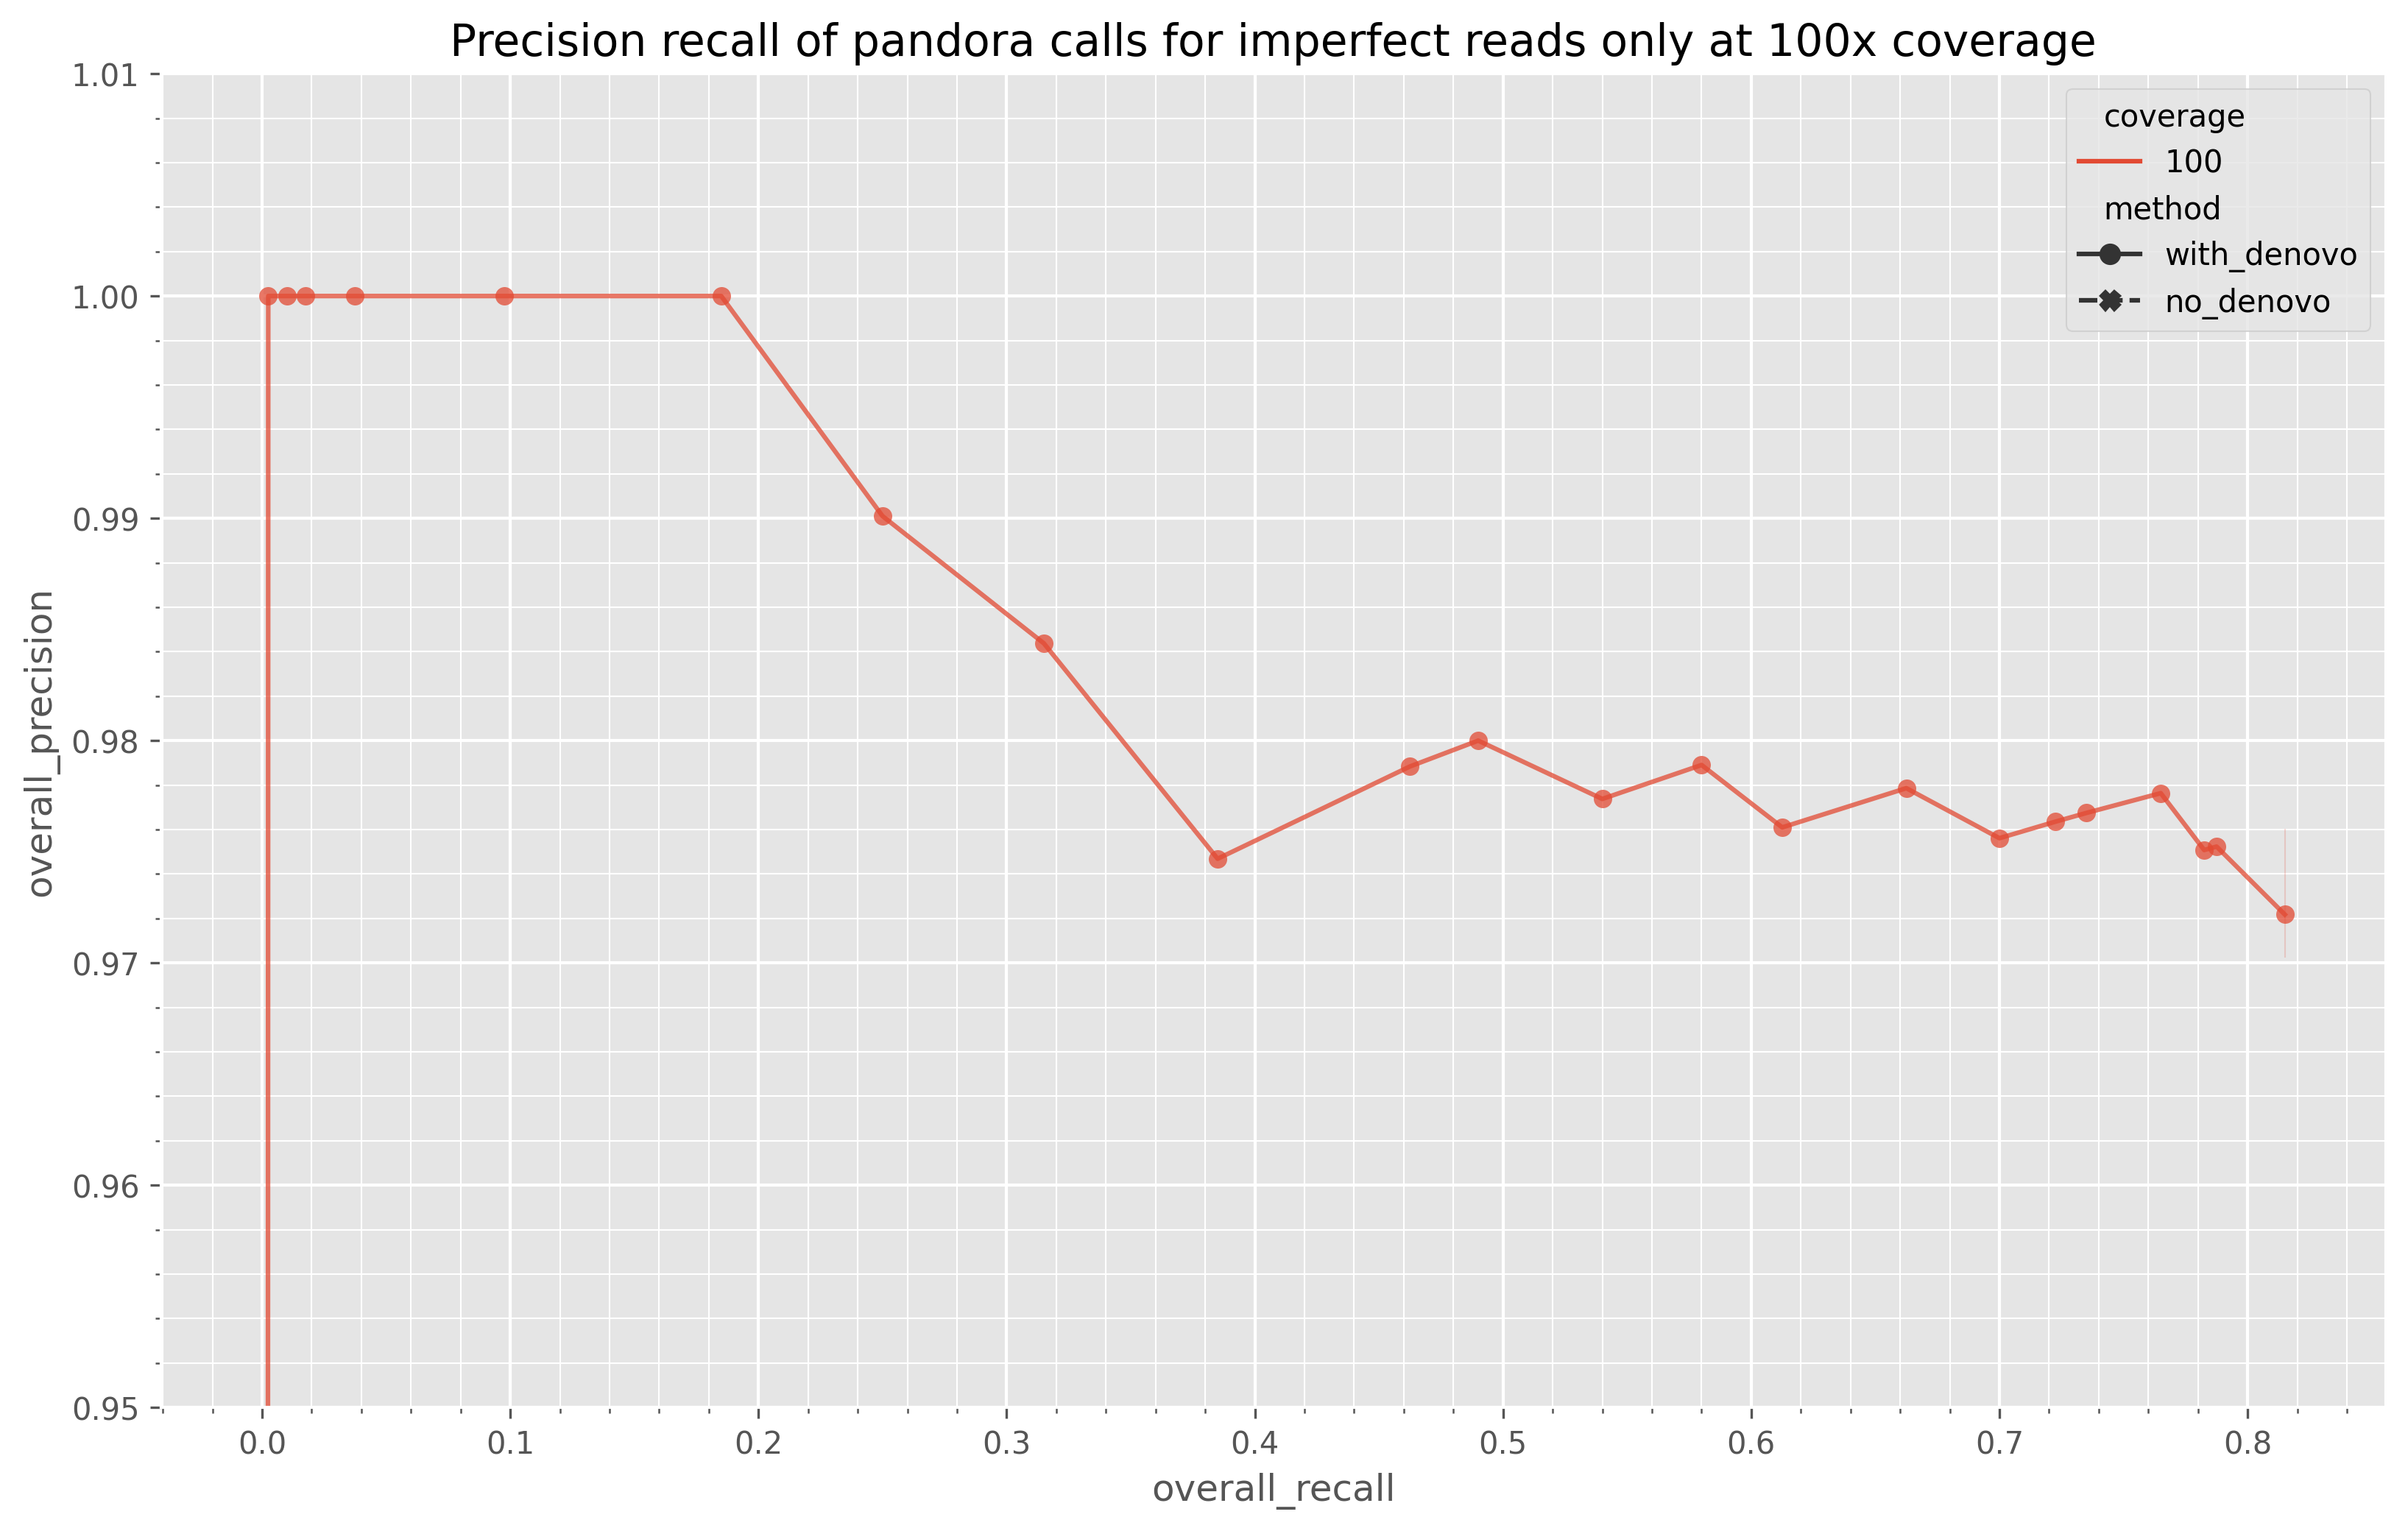

In [207]:
data = df[df["coverage"] == 100]
pal = CMAP[:len(set(data[hue]))]
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
plot = sns.lineplot(x=x, 
                       y=y, 
                       data=data, 
                       ax=ax, 
                       style=style,
                       palette=pal, 
                       hue=hue, 
                    sort=False,
                       legend="full", markers=True, markeredgewidth=0, alpha=alpha)
_ = plot.set(title="Precision recall of pandora calls for imperfect reads only at 100x coverage")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)
plot.set(ylim=(.95, 1.01))

The record with the maximum precision value for the no-*de novo* data.

In [208]:
df_no_denovo.loc[df_no_denovo["overall_precision"].idxmax()]

denovo_precision            0.0
denovo_recall               0.0
overall_recall           0.0025
overall_precision           1.0
overall_accuracy         0.0025
overall_error_rate       0.9975
denovo_kmer_size             13
num_snps                    400
coverage                    100
max_nesting                   5
read_quality          imperfect
conf_threshold              190
method                no_denovo
Name: 79, dtype: object

The record with the maximum recall value for the no-*de novo* data.

In [209]:
df_no_denovo.loc[df_no_denovo["overall_recall"].idxmax()]

denovo_precision            0.0
denovo_recall               0.0
overall_recall             0.01
overall_precision      0.042105
overall_accuracy       0.008147
overall_error_rate     0.991853
denovo_kmer_size             13
num_snps                    400
coverage                     30
max_nesting                   5
read_quality          imperfect
conf_threshold                0
method                no_denovo
Name: 1, dtype: object

## Investigating loss of recall

In this first step we look at whether all of the simulated genes are present in the consesnsus sequence. If there are genes missing, we need to figure out whether these genes contained SNPs. If so, these SNPs are an easy way to explain part of the recall loss. So the question we are asking here is:  
**How much recall do we lose from genes missed?**

In [210]:
import pysam
import numpy as np
import itertools
from pathlib import Path
from typing import Tuple
NUM_SNPS = 400
MAX_NESTING = 5
READ_QUALITY = "imperfect"
DENOVO_K = 13

In [242]:
prg_file = Path(f"../data/prgs/max_nesting_lvl_{MAX_NESTING}/combined.prg.fa")
assert prg_file.is_file()
stats = dict()

The first step is figuring out how many genes were found in the consensus sequence.

In [243]:
consensus_sequences = list(Path("../hps").rglob(f"*/analysis/{MAX_NESTING}/{NUM_SNPS}/{READ_QUALITY}/*/{DENOVO_K}/map_with_discovery/pandora.consensus.fq.gz"))

In [244]:
genes_in_prg = set()
with pysam.FastxFile(prg_file) as fh:
    for record in fh:
        genes_in_prg.add(record.name)
num_genes_in_prg = len(genes_in_prg)

In [245]:
genes_in_consensus = dict()
for consensus in consensus_sequences:
    covg = consensus.parts[-4]
    genes = set()
    with pysam.FastxFile(consensus) as fh:
        for record in fh:
            genes.add(record.name)
    genes_in_consensus[covg] = genes
    stats[covg] = {"num_genes_in_consensus": len(genes)}
    print(f"{len(genes)} / {num_genes_in_prg} genes found for {covg}x coverage")

98 / 100 genes found for 15x coverage
88 / 100 genes found for 30x coverage
95 / 100 genes found for 60x coverage
96 / 100 genes found for 100x coverage


*Observation: it is strange that 15x (lowest coverage) discovers more genes than the other coverages.*

Now to determine which genes are not present in the consensus sequence.

In [246]:
genes_not_present_in_consensus = dict()
for covg, genes_present in genes_in_consensus.items():
    genes_not_present_in_consensus[covg] = genes_in_prg - genes_present
    stats[covg]["num_absent_genes"] = len(genes_in_prg - genes_present)

In [247]:
genes_not_present_in_consensus

{'15': {'GC00000093_18', 'GC00012688'},
 '30': {'GC00000004_22',
  'GC00000093_18',
  'GC00000419_1',
  'GC00000462_1',
  'GC00001046_9',
  'GC00001736_2',
  'GC00002809_1',
  'GC00003034_2',
  'GC00005796',
  'GC00010217',
  'GC00011051',
  'GC00012688'},
 '60': {'GC00000093_18',
  'GC00000419_1',
  'GC00000462_1',
  'GC00011051',
  'GC00012688'},
 '100': {'GC00000093_18', 'GC00000462_1', 'GC00011051', 'GC00012688'}}

For the next step, we need to get the gene coordinates for the introduced SNPs. To introduce the SNPs, a random path was selected from the PRG for each gene and then all these random paths were concatenated into a single linear sequence. Then SNPs were introduced on this. As the ordering of genes on this linear sequence is not stored anywhere I need to find each gene's coordinates in this linear sequence, and then convert the index of a SNP on the linear sequence to a coordinate on the gene sequence.

In [248]:
def get_indices_of_gene_in_ref(ref: str, gene: str) -> Tuple[int, int]:
    """Returns the start and end indixes of gene in ref. The indices are returned in the 
    form [start, end] that is, start and end are inclusive."""
    start = ref.index(gene)
    end = start + len(gene) - 1
    return start, end
#test
assert get_indices_of_gene_in_ref("AAAFOOAAAA", "FOO") == (3, 5)
assert get_indices_of_gene_in_ref("AAAFOO", "FOO") == (3, 5)
assert get_indices_of_gene_in_ref("FOOAAA", "FOO") == (0, 2)

In [249]:
analysis_dir = Path("../hps/nobackup/iqbal/mbhall/pandora_simulations/analysis")
combined_random_paths = analysis_dir / f"{MAX_NESTING}/combined_random_paths.fa"
individual_random_paths = analysis_dir / f"{MAX_NESTING}/random_paths.fa"
vcf_of_introduced_snps = analysis_dir / f"{MAX_NESTING}/{NUM_SNPS}/combined_random_paths_mutated.vcf"

In [250]:
with pysam.FastxFile(combined_random_paths) as fh:
    linear_sequence = next(fh).sequence

While we're at it, lets take a quick look at how long each of the absent genes is.

In [251]:
absent_genes = set.union(*genes_not_present_in_consensus.values())

In [252]:
gene_coordinates_on_ref = dict()
with pysam.FastxFile(individual_random_paths) as fh:
    for record in fh:
        name = record.name[:-2] # the seq name has had an _0 added to the end
        idx = get_indices_of_gene_in_ref(linear_sequence, record.sequence)
        assert idx not in gene_coordinates_on_ref
        gene_coordinates_on_ref[idx] = name
        if name in absent_genes:
            print(f"{name}\t{len(record.sequence)}bp")
assert len(gene_coordinates_on_ref) == len(genes_in_prg)

GC00001046_9	219bp
GC00012688	162bp
GC00011051	261bp
GC00000419_1	246bp
GC00001736_2	183bp
GC00010217	192bp
GC00000004_22	237bp
GC00000462_1	183bp
GC00002809_1	219bp
GC00000093_18	147bp
GC00003034_2	165bp
GC00005796	177bp


In [253]:
snp_positions = []
with pysam.VariantFile(vcf_of_introduced_snps) as vcf:
    for entry in vcf:
        snp_positions.append(entry.pos-1)
snp_positions = np.array(sorted(snp_positions))
assert len(snp_positions) == NUM_SNPS

[W::vcf_parse] Contig '1' is not defined in the header. (Quick workaround: index the file with tabix.)


In [254]:
gene_snp_coordinates = dict()
for (start, end), gene_name in gene_coordinates_on_ref.items():
    start_idx = np.searchsorted(snp_positions, start, 'left')
    end_idx = np.searchsorted(snp_positions, end, 'right')
    snp_positions_in_gene = np.arange(start_idx, end_idx).tolist()
    positions_in_linear = []
    positions_in_gene = []
    for i in snp_positions_in_gene:
        pos = snp_positions[i]
        positions_in_linear.append(pos)
        positions_in_gene.append(pos - start)
    gene_snp_coordinates[gene_name] = {"positions_in_linear": positions_in_linear, 
                                      "positions_in_gene": positions_in_gene,
                                      "gene_length": end-start}
    

total = 0
for d in gene_snp_coordinates.values():
    total += len(d["positions_in_gene"])
assert total == NUM_SNPS

In [255]:
for covg, genes in genes_in_consensus.items():
    num_snps_on_absent_genes = 0
    genes_missing_for_covg = genes_in_prg - set(genes)
    for gene in genes_missing_for_covg:
        if gene in absent_genes:
            num_snps_on_absent_genes += len(gene_snp_coordinates[gene]["positions_in_linear"])
    stats[covg]["num_snps_on_absent_genes"] = num_snps_on_absent_genes
        
    print(f"{covg}x: There are {num_snps_on_absent_genes} / 400 SNPs ({round(num_snps_on_absent_genes/400*100, 2)}%) on {len(genes_missing_for_covg)} missing genes.")

15x: There are 3 / 400 SNPs (0.75%) on 2 missing genes.
30x: There are 19 / 400 SNPs (4.75%) on 12 missing genes.
60x: There are 11 / 400 SNPs (2.75%) on 5 missing genes.
100x: There are 9 / 400 SNPs (2.25%) on 4 missing genes.


Now let's see how many present SNPs are within twice the denovo kmer size of the start and end of the gene it is in. Due to the way denovo discovery works, we cannot find SNPs within ($2*k$)-bases of the start and end of the gene.

In [256]:
for covg, genes in genes_in_consensus.items():
    num_near_ends = []
    for gene in genes:
        length = gene_snp_coordinates[gene]["gene_length"]
        for pos in gene_snp_coordinates[gene]["positions_in_gene"]: 
            is_near_end = True if (pos < (DENOVO_K*2)) or (pos >= (length-DENOVO_K*2)) else False
            num_near_ends.append(is_near_end)
            
    assert len(num_near_ends) == (NUM_SNPS - stats[covg]["num_snps_on_absent_genes"])
    stats[covg]["num_snps_near_ends"] = sum(num_near_ends)
    print(f"{covg}x:\t{stats[covg]['num_snps_near_ends']} / {NUM_SNPS} SNPs ({round(stats[covg]['num_snps_near_ends']/NUM_SNPS*100, 2)}%) are within {2*DENOVO_K} bases of the ends.")

15x:	38 / 400 SNPs (9.5%) are within 26 bases of the ends.
30x:	31 / 400 SNPs (7.75%) are within 26 bases of the ends.
60x:	35 / 400 SNPs (8.75%) are within 26 bases of the ends.
100x:	36 / 400 SNPs (9.0%) are within 26 bases of the ends.


So to summarise how many SNPs are missing due to both missing genes and being near the ends of genes.

In [257]:
for covg, d in stats.items():
    total_missing = d["num_snps_near_ends"] + d["num_snps_on_absent_genes"]
    print(f"{covg}x:\t{total_missing} / {NUM_SNPS} of SNPs ({round(total_missing/NUM_SNPS*100, 2)}%) are not currently discoverable.")

15x:	41 / 400 of SNPs (10.25%) are not currently discoverable.
30x:	50 / 400 of SNPs (12.5%) are not currently discoverable.
60x:	46 / 400 of SNPs (11.5%) are not currently discoverable.
100x:	45 / 400 of SNPs (11.25%) are not currently discoverable.


Looking at how many false negatives we had.

Load the result json files into a custom class that gives easy access to evaluation metrics.

In [258]:
for r in results:
    if (r.denovo_kmer_size == denovo_kmer_size and 
            r.max_nesting == max_nesting and 
            r.read_quality == read_quality and 
            r.num_snps == num_snps):
        fns = r.overall_false_negatives()
        undiscoverable = stats[str(r.coverage)]["num_snps_near_ends"] + stats[str(r.coverage)]["num_snps_on_absent_genes"]
        print(f"{r.coverage}x:\t{undiscoverable}/{fns} false negatives ({round(undiscoverable/fns*100, 2)}%) are undiscoverable.")

15x:	41/278 false negatives (14.75%) are undiscoverable.
30x:	50/177 false negatives (28.25%) are undiscoverable.
60x:	46/89 false negatives (51.69%) are undiscoverable.
100x:	45/74 false negatives (60.81%) are undiscoverable.


In [260]:
fns

74